# EDA

In [1]:
!pip install lifelines

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from lifelines import KaplanMeierFitter, CoxPHFitter, statistics
import scipy.stats as stats
from scipy.stats import chi2_contingency, fisher_exact, zscore, skew, kurtosis
from itertools import combinations
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.preprocessing import StandardScaler
from copy import deepcopy

sns.set(style = "whitegrid")

In [3]:
import warnings
warnings.filterwarnings("ignore")

## Operational Data

### Train - Operational Readouts

In [4]:
train_op = pd.read_csv("train_operational_readouts.csv")
train_op

vehicle_id  time_step      171_0    666_0        427_0    837_0  \
0                 0       11.2   167985.0  10787.0    7413813.0   2296.0   
1                 0       11.4   167985.0  10787.0    7413813.0   2296.0   
2                 0       19.6   331635.0  14525.0   13683604.0   2600.0   
3                 0       20.2   354975.0  15015.0   14540449.0   2616.0   
4                 0       21.0   365550.0  15295.0   14966985.0   2720.0   
...             ...        ...        ...      ...          ...      ...   
1122447       33643      101.0  2136810.0  41412.0   81068654.0  10365.0   
1122448       33643      107.0  2283285.0  44660.0   86639835.0  12317.0   
1122449       33643      113.8  2462865.0  48370.0   93439419.0  13910.0   
1122450       33643      119.8  2627250.0  51101.0   99682931.0  14854.0   
1122451       33643      125.8  2741460.0  52949.0  104122894.0  15222.0   

          167_0      167_1       167_2      167_3  ...    397_26   397_27  \
0        4110.0  1296420.0   1628265.0   630345.0  ...   95728.0  15609.0   
1        4111.0  1302855.0   1628265.0   630345.0  ...   95729.0  15610.0   
2           NaN        NaN         NaN        NaN  ...  142900.0  19263.0   
3           NaN        NaN         NaN        NaN  ...  150565.0  19832.0   
4           NaN        NaN         NaN        NaN  ...  155913.0  20573.0   
...         ...        ...         ...        ...  ...       ...      ...   
1122447   843.0  6408272.0  10964376.0  6092347.0  ...  727848.0  34448.0   
1122448   843.0  6596477.0  12358026.0  6721702.0  ...  780576.0  37488.0   
1122449   843.0  6669542.0  12830421.0  7415497.0  ...  837953.0  40050.0   
1122450   843.0  7074468.0  13604706.0  7747492.0  ...  898070.0  42866.0   
1122451   843.0  7988418.0  16274631.0  8095988.0  ...  936034.0  45137.0   

         397_28  397_29   397_30    397_31    397_32    397_33   397_34  \
0        1984.0     8.0    784.0  150228.0  261904.0   93172.0  17874.0   
1        1984.0     8.0    784.0  150228.0  261905.0   93172.0  17874.0   
2        2441.0    12.0   1420.0  204832.0  313485.0  106464.0  19306.0   
3        2522.0    12.0   1444.0  211688.0  318901.0  107745.0  19406.0   
4        2562.0    12.0   1445.0  213956.0  323997.0  109514.0  19535.0   
...         ...     ...      ...       ...       ...       ...      ...   
1122447  6540.0    36.0  19500.0  612343.0  626033.0  100155.0  17033.0   
1122448  6964.0    40.0  20484.0  652688.0  670517.0  107367.0  18901.0   
1122449  7524.0    44.0  21688.0  698824.0  722453.0  115851.0  21237.0   
1122450  7992.0    48.0  22732.0  757856.0  777630.0  123155.0  22357.0   
1122451  8493.0    48.0  23484.0  801725.0  814410.0  128663.0  23453.0   

         397_35  
0         452.0  
1         452.0  
2         452.0  
3         453.0  
4         454.0  
...         ...  
1122447    24.0  
1122448    24.0  
1122449    28.0  
1122450    32.0  
1122451    32.0  

[1122452 rows x 107 columns]

The dataset contains both histogram and numerical counter variables, which are structured differently but serve different roles in predictive modeling for PdM approaches. The dataset is split into two main categories:

* **Numerical Counters:** These variables represent accumulative data, typically used for tracking the evolution of a phenomenon over time. They are suitable for capturing trends and can be treated as sequential time-series features.

* **Histogram Variables:** These variables represent discretized values of continuous features over a defined range, grouped into bins. These variables are well-suited for representing distributions of data across specific intervals, and their binning can aid in simplifying complex, continuous distributions into more interpretable forms.

By categorizing these variables, the format allows for more appropriate pre-processing in time-series models, such as **Autoencoders (AE)**, **Long Short-Term Memory (LSTM)**, or a combination of **LSTM-AE** for anomaly detection (AD).

The histogram variables can capture the distribution of sensor data in discrete intervals, while the numerical counters help track trends over time, both contributing essential information to the modeling process.

---
Before diving into analyzing each category of variables, some general checks are done, namely:
* Verifying if there are any duplicate rows.
* Verifying if the time_step is increasing for all vehicles;

In [5]:
print("Number of duplicate rows:", train_op.duplicated().sum())

Number of duplicate rows: 0


In [6]:
train_op_sorted = train_op.sort_values(["vehicle_id","time_step"])

# Verify if the time step is increasing for each vehicle
time_step_increasing = (train_op_sorted.groupby("vehicle_id")["time_step"].apply(lambda x: (x.diff().dropna() > 0).all()))

# Conclusion
if time_step_increasing.all():
    print("The time step variable is increasing for all vehicles.")
else:
    print("The time step variable is not increasing for all vehicles. \n Vehicles with problems: \n")
    print(time_step_increasing[~time_step_increasing].index().tolist())

The time step variable is increasing for all vehicles.


In [7]:
# Define the dataset variables
histogram_variables = {
    "167": 10,
    "272": 10,
    "291": 11,
    "158": 10,
    "459": 20,
    "397": 36
}

numerical_counters = ["171_0", "666_0", "427_0", "837_0", "309_0", "835_0", "370_0", "100_0"]

# Print results
print("Numerical Counters:", numerical_counters)
print("\nHistogram Variables:")
for var, bins in histogram_variables.items():
    print(f"Variable ID: {var}, Bins: {bins}")

Numerical Counters: ['171_0', '666_0', '427_0', '837_0', '309_0', '835_0', '370_0', '100_0']

Histogram Variables:
Variable ID: 167, Bins: 10
Variable ID: 272, Bins: 10
Variable ID: 291, Bins: 11
Variable ID: 158, Bins: 10
Variable ID: 459, Bins: 20
Variable ID: 397, Bins: 36


Understanding the separation of numerical counters and histogram variables is important for the modeling phase, in particular when applying models such as AE, LSTM, and LSTM-AE for AD.

* **Numerical counters** can be treated as time-series data, allowing the model to track temporal changes in system behavior. In addition, the cumulative nature of these variables can be explored by visualizing the differences between time steps.

* In contrast, **histogram variables** can be used to understand the distribution of data at specific moments, which can increase model interpretability and robustness.

This classification will increase the complexity in data analysis and preprocessing, and could potentialy lead to loss of information.
* On the one hand, it is important to ensure that histogram varialbes are discretized correctly, while numerical counters must maintain their temporal continuity;
* On the other hand, the binning process of continuous data into histograms introduces the risk of losing subtle variations that might be important to detect anomalies - and therefore decrease the model performance in the anomaly prediction task.

In [8]:
train_vehicle_stats = (
    train_op
      .groupby("vehicle_id")["time_step"]
      .agg(["count","min","max"])
      .rename(columns={"count":"n_obs","min":"t_min","max":"t_max"})
      .reset_index()
)

train_vehicle_stats["duration"] = train_vehicle_stats["t_max"] - train_vehicle_stats["t_min"]
train_vehicle_stats

vehicle_id  n_obs  t_min  t_max  duration
0               0    172   11.2  507.4     496.2
1               2     33    1.4  281.0     279.6
2               3     71    0.2  291.2     291.0
3               4     17    3.8  203.0     199.2
4               5     44    0.0  357.6     357.6
...           ...    ...    ...    ...       ...
23545       33639     17   10.6  112.6     102.0
23546       33640     33    4.6  123.2     118.6
23547       33641     18    8.0  116.0     108.0
23548       33642     27    5.0  126.4     121.4
23549       33643     26   20.0  125.8     105.8

[23550 rows x 5 columns]

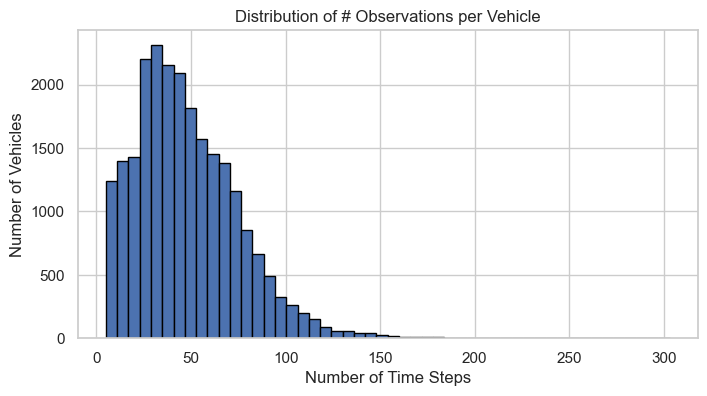

In [9]:
# Distribution of sequence lengths (# observations)
plt.figure(figsize=(8,4))
plt.hist(train_vehicle_stats['n_obs'], bins=50, edgecolor='black')
plt.title("Distribution of # Observations per Vehicle")
plt.xlabel("Number of Time Steps")
plt.ylabel("Number of Vehicles")
plt.show()

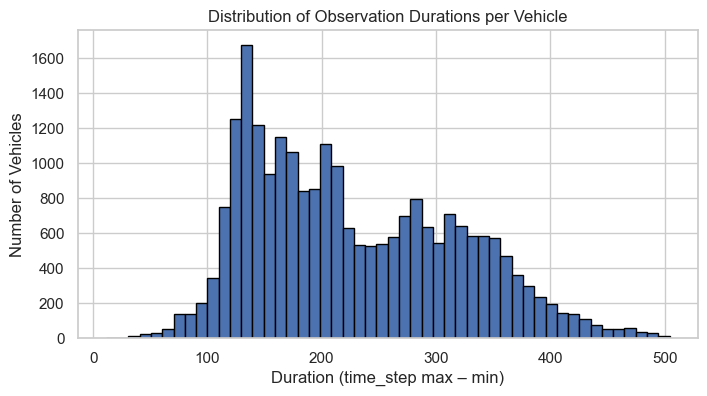

In [10]:
# Distribution of actual time‐span per vehicle
plt.figure(figsize=(8,4))
plt.hist(train_vehicle_stats['duration'], bins=50, edgecolor='black')
plt.title("Distribution of Observation Durations per Vehicle")
plt.xlabel("Duration (time_step max – min)")
plt.ylabel("Number of Vehicles")
plt.show()

In [11]:
print("Min.:", train_vehicle_stats["n_obs"].min())
print("Max.:", train_vehicle_stats["n_obs"].max())

Min.: 5
Max.: 303


Summary statistics:
  n_obs: skew=0.99, kurtosis=1.93
  duration: skew=0.50, kurtosis=-0.65


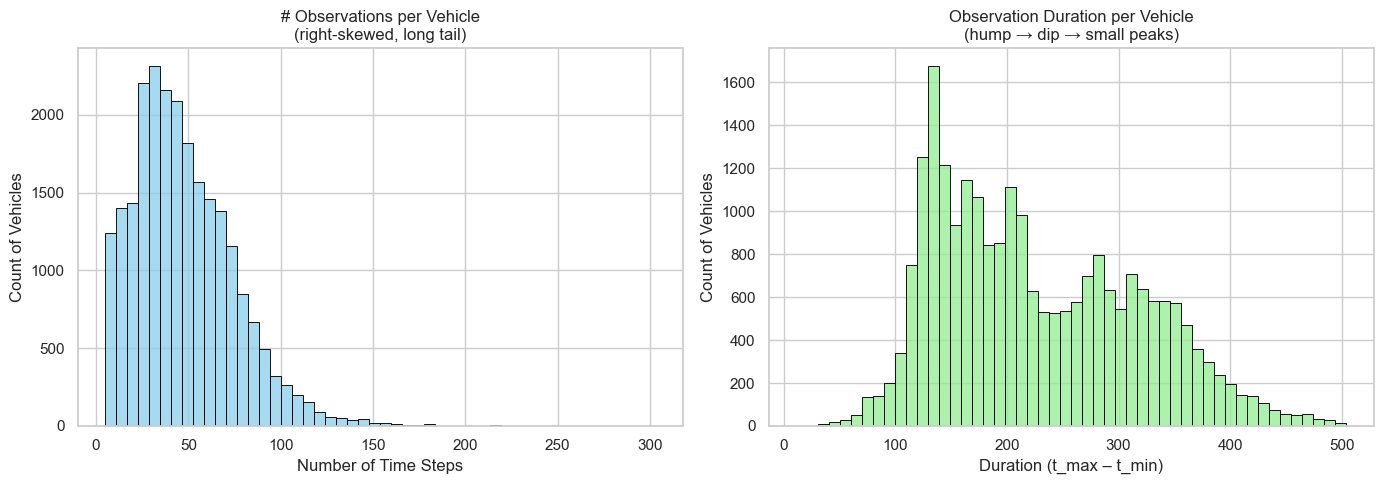

In [12]:
# Assuming vehicle_stats from earlier:
# vehicle_stats has columns ['vehicle_id','n_obs','t_min','t_max','duration']

# Compute summary stats
train_stats = {
    'n_obs': {
        'skewness': skew(train_vehicle_stats['n_obs']),
        'kurtosis': kurtosis(train_vehicle_stats['n_obs'])
    },
    'duration': {
        'skewness': skew(train_vehicle_stats['duration']),
        'kurtosis': kurtosis(train_vehicle_stats['duration'])
    }
}

print("Summary statistics:")
for var, vals in train_stats.items():
    print(f"  {var}: skew={vals['skewness']:.2f}, kurtosis={vals['kurtosis']:.2f}")

# Plot side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5))

sns.histplot(train_vehicle_stats['n_obs'], bins=50, ax=ax1, color='skyblue', edgecolor='black')
ax1.set_title('# Observations per Vehicle\n(right-skewed, long tail)')
ax1.set_xlabel('Number of Time Steps')
ax1.set_ylabel('Count of Vehicles')

sns.histplot(train_vehicle_stats['duration'], bins=50, ax=ax2, color='lightgreen', edgecolor='black')
ax2.set_title('Observation Duration per Vehicle\n(hump → dip → small peaks)')
ax2.set_xlabel('Duration (t_max – t_min)')
ax2.set_ylabel('Count of Vehicles')

plt.tight_layout()
plt.show()

To investigate the structure and consistency of Missing Values (NaNs) in the dataset, an analysis was conducted to determine whether NaNs appeared jointly across histograms bins and whether they exhibited temporal clustering.

This was done to:

* Verify if missing values in histograms affected entire attributes rather than individual bins, ensuring appropriate handling in predictive models;
* Identify potential sensor failures (by detecting temporal clusters of NaNs), as consecutive missing values could indicate systematic issues rather than random noise.

Understanding these patters is important to improve the data preprocessing phase.

#### Numerical Counters

In [13]:
train_op_num = train_op[["vehicle_id", "time_step"] + numerical_counters]
train_op_num

vehicle_id  time_step      171_0    666_0        427_0    837_0  \
0                 0       11.2   167985.0  10787.0    7413813.0   2296.0   
1                 0       11.4   167985.0  10787.0    7413813.0   2296.0   
2                 0       19.6   331635.0  14525.0   13683604.0   2600.0   
3                 0       20.2   354975.0  15015.0   14540449.0   2616.0   
4                 0       21.0   365550.0  15295.0   14966985.0   2720.0   
...             ...        ...        ...      ...          ...      ...   
1122447       33643      101.0  2136810.0  41412.0   81068654.0  10365.0   
1122448       33643      107.0  2283285.0  44660.0   86639835.0  12317.0   
1122449       33643      113.8  2462865.0  48370.0   93439419.0  13910.0   
1122450       33643      119.8  2627250.0  51101.0   99682931.0  14854.0   
1122451       33643      125.8  2741460.0  52949.0  104122894.0  15222.0   

          309_0        835_0  370_0       100_0  
0          70.0    8036751.0    0.0    858410.0  
1          70.0    8040811.0    0.0    860571.0  
2          70.0   12777022.0    0.0   1379191.0  
3          70.0   13612083.0    0.0   1428606.0  
4          70.0   14041353.0    0.0   1460547.0  
...         ...          ...    ...         ...  
1122447  1247.0   84411912.0    0.0   7511933.0  
1122448  1443.0   90774342.0    0.0   8322863.0  
1122449  1569.0   97839903.0    0.0   8940438.0  
1122450  1681.0  104628494.0    0.0   9674133.0  
1122451  1681.0  110937045.0    0.0  10971028.0  

[1122452 rows x 10 columns]

In [14]:
train_repair = pd.read_csv("train_tte.csv")
train_rep = train_repair[["vehicle_id","in_study_repair"]]
train_rep

vehicle_id  in_study_repair
0               0                0
1               2                0
2               3                0
3               4                0
4               5                0
...           ...              ...
23545       33639                0
23546       33640                0
23547       33641                0
23548       33642                0
23549       33643                0

[23550 rows x 2 columns]

In [15]:
train_op_num.isnull().sum()

vehicle_id       0
time_step        0
171_0            0
666_0           40
427_0         6405
837_0           39
309_0           34
835_0           39
370_0         6398
100_0         6401
dtype: int64

The number of missing values is very small when compared with the total number of observations.

In [16]:
sensors = ['666_0','427_0','837_0','309_0','835_0','370_0','100_0']

train_op_num[sensors] = (
    train_op_num
    .groupby('vehicle_id')[sensors]
    .apply(lambda df: df.ffill().bfill())
    .reset_index(level=0, drop=True)
)

In [17]:
train_op_num.isnull().sum()

vehicle_id    0
time_step     0
171_0         0
666_0         0
427_0         0
837_0         0
309_0         0
835_0         0
370_0         0
100_0         0
dtype: int64

As previously mentioned, the numerical counters are cumulative variables. As such, the values should increase or stay the same.

In [18]:
# Compute time gaps

train_op_num = train_op_num.sort_values(["vehicle_id", "time_step"]).reset_index(drop=True)
train_op_num["time_diff"] = train_op_num.groupby("vehicle_id")["time_step"].diff()
train_op_num

vehicle_id  time_step      171_0    666_0        427_0    837_0  \
0                 0       11.2   167985.0  10787.0    7413813.0   2296.0   
1                 0       11.4   167985.0  10787.0    7413813.0   2296.0   
2                 0       19.6   331635.0  14525.0   13683604.0   2600.0   
3                 0       20.2   354975.0  15015.0   14540449.0   2616.0   
4                 0       21.0   365550.0  15295.0   14966985.0   2720.0   
...             ...        ...        ...      ...          ...      ...   
1122447       33643      101.0  2136810.0  41412.0   81068654.0  10365.0   
1122448       33643      107.0  2283285.0  44660.0   86639835.0  12317.0   
1122449       33643      113.8  2462865.0  48370.0   93439419.0  13910.0   
1122450       33643      119.8  2627250.0  51101.0   99682931.0  14854.0   
1122451       33643      125.8  2741460.0  52949.0  104122894.0  15222.0   

          309_0        835_0  370_0       100_0  time_diff  
0          70.0    8036751.0    0.0    858410.0        NaN  
1          70.0    8040811.0    0.0    860571.0        0.2  
2          70.0   12777022.0    0.0   1379191.0        8.2  
3          70.0   13612083.0    0.0   1428606.0        0.6  
4          70.0   14041353.0    0.0   1460547.0        0.8  
...         ...          ...    ...         ...        ...  
1122447  1247.0   84411912.0    0.0   7511933.0        6.0  
1122448  1443.0   90774342.0    0.0   8322863.0        6.0  
1122449  1569.0   97839903.0    0.0   8940438.0        6.8  
1122450  1681.0  104628494.0    0.0   9674133.0        6.0  
1122451  1681.0  110937045.0    0.0  10971028.0        6.0  

[1122452 rows x 11 columns]

In [19]:
# We should have the same number of Missing Values as the same number of trucks.

train_op_num["time_diff"].isnull().sum()

23550

In [20]:
(train_op_num["time_diff"] < 0).sum()

0

In [21]:
train_op_num = train_op_num[train_op_num["time_diff"].isna() | (train_op_num["time_diff"] >= 1 )]
train_op_num

vehicle_id  time_step      171_0    666_0        427_0    837_0  \
0                 0       11.2   167985.0  10787.0    7413813.0   2296.0   
2                 0       19.6   331635.0  14525.0   13683604.0   2600.0   
5                 0       28.0   542490.0  21063.0   21590525.0   3280.0   
8                 0       31.2   630075.0  23682.0   24916133.0   3457.0   
10                0       33.6   683580.0  26181.0   26980272.0   4169.0   
...             ...        ...        ...      ...          ...      ...   
1122447       33643      101.0  2136810.0  41412.0   81068654.0  10365.0   
1122448       33643      107.0  2283285.0  44660.0   86639835.0  12317.0   
1122449       33643      113.8  2462865.0  48370.0   93439419.0  13910.0   
1122450       33643      119.8  2627250.0  51101.0   99682931.0  14854.0   
1122451       33643      125.8  2741460.0  52949.0  104122894.0  15222.0   

          309_0        835_0  370_0       100_0  time_diff  
0          70.0    8036751.0    0.0    858410.0        NaN  
2          70.0   12777022.0    0.0   1379191.0        8.2  
5          70.0   20443403.0    0.0   1815033.0        7.0  
8          70.0   23600133.0    0.0   1962919.0        1.8  
10         70.0   25598215.0    0.0   2075064.0        2.2  
...         ...          ...    ...         ...        ...  
1122447  1247.0   84411912.0    0.0   7511933.0        6.0  
1122448  1443.0   90774342.0    0.0   8322863.0        6.0  
1122449  1569.0   97839903.0    0.0   8940438.0        6.8  
1122450  1681.0  104628494.0    0.0   9674133.0        6.0  
1122451  1681.0  110937045.0    0.0  10971028.0        6.0  

[953263 rows x 11 columns]

The time step is increasing for all trucks (as previously concluded).

---

Let"s now verify if the monotonicity is verified by the numerical counters.

In [22]:
train_op_num.isnull().sum()

vehicle_id        0
time_step         0
171_0             0
666_0             0
427_0             0
837_0             0
309_0             0
835_0             0
370_0             0
100_0             0
time_diff     23550
dtype: int64

In [23]:
# Detect resets/monotonicity violations

num_diffs = train_op_num.groupby("vehicle_id")[numerical_counters].diff()

# Negative steps per column?
neg_counts = (num_diffs < 0).sum()
print("Number of decreases (potential resets) by counter:\n", neg_counts)

Number of decreases (potential resets) by counter:
 171_0    2
666_0    0
427_0    0
837_0    0
309_0    0
835_0    0
370_0    0
100_0    0
dtype: int64


Only variable "171_0" has numerical resets; in particular, there are 7 decreases/resets.
Let"s analyze these results in more detail.

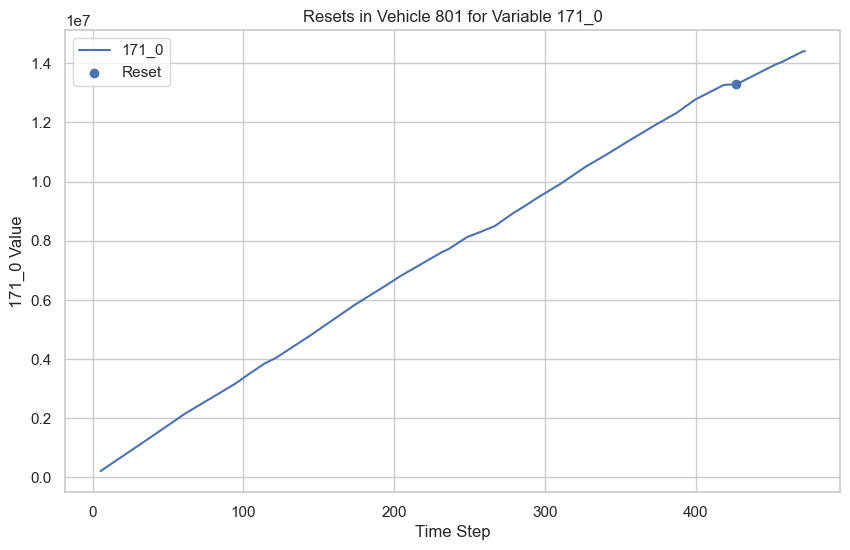

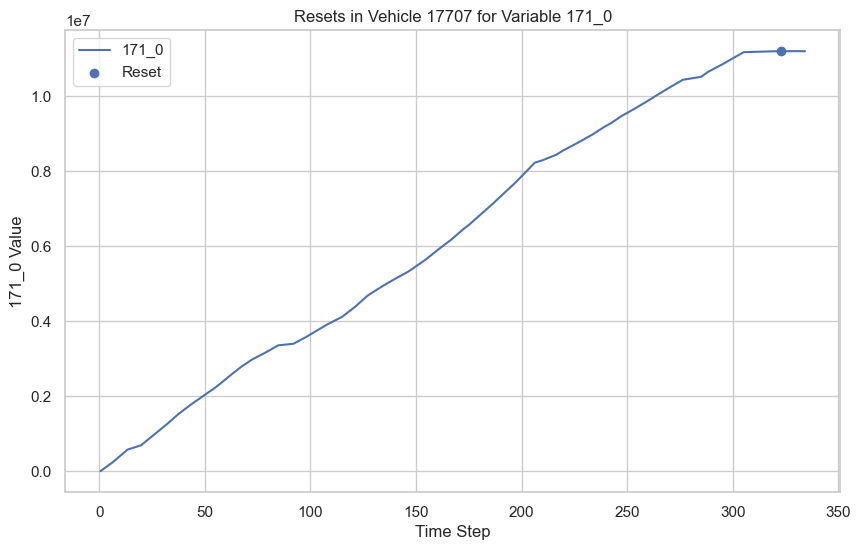

In [24]:
# Identify rows where resets (negative diffs) occur
reset_indices = num_diffs[num_diffs < 0].dropna(how="all").index

# Loop through the vehicle IDs where resets happened
for vehicle_id in train_op_num["vehicle_id"].unique():
    # Filter the data for the specific vehicle and the variables with resets
    vehicle_data = train_op_num[train_op_num["vehicle_id"] == vehicle_id]

    # Only consider the rows where resets happened (those with negative diffs)
    resets_for_vehicle = reset_indices[reset_indices.isin(vehicle_data.index)]

    if not resets_for_vehicle.empty:
        # Plot the variable for the vehicle
        plt.figure(figsize=(10, 6))
        plt.plot(vehicle_data["time_step"], vehicle_data["171_0"], label="171_0")

        # Mark the resets on the plot
        plt.scatter(vehicle_data.loc[resets_for_vehicle, "time_step"],
                    vehicle_data.loc[resets_for_vehicle, "171_0"],
                    zorder=5, label="Reset")

        plt.title(f"Resets in Vehicle {vehicle_id} for Variable 171_0")
        plt.xlabel("Time Step")
        plt.ylabel("171_0 Value")
        plt.legend()
        plt.grid(True)
        plt.show()


In [25]:
def fix_resets_iterative(vehicle_data, col):
    """
    Iteratively fix resets for a given counter column by interpolation
    and accumulating correct deltas after each reset.
    """
    vehicle_data = vehicle_data.copy()
    while True:
        diffs = vehicle_data[col].diff()
        reset_indices = diffs[diffs < 0].index

        if len(reset_indices) == 0:
            break  # No more resets, exit loop

        reset_idx = reset_indices[0]  # Handle one reset at a time

        prev_idx = reset_idx - 1
        prev_value = vehicle_data.loc[prev_idx, col]

        # At reset_idx, set it to previous value
        vehicle_data.loc[reset_idx, col] = prev_value  # Could interpolate if needed

        # After reset_idx, accumulate using original diffs (before fixing)
        for idx in range(reset_idx + 1, vehicle_data.index[-1] + 1):
            if idx not in vehicle_data.index:
                break
            delta = diffs[idx]  # original difference BEFORE fix
            vehicle_data.loc[idx, col] = vehicle_data.loc[idx - 1, col] + (delta if pd.notna(delta) else 0)

    return vehicle_data

In [26]:
train_op_num_fixed = train_op_num.copy()

for vehicle_id in [801, 837, 4314, 8959, 17707, 18824, 23425]:
    vehicle_data = train_op_num[train_op_num["vehicle_id"] == vehicle_id].copy()

    for col in numerical_counters:
        vehicle_data_fixed = fix_resets_iterative(vehicle_data, col)
        train_op_num_fixed.loc[vehicle_data.index, col] = vehicle_data_fixed[col]

In [27]:
(train_op_num_fixed.groupby("vehicle_id")[numerical_counters].diff()<0).sum()

171_0    0
666_0    0
427_0    0
837_0    0
309_0    0
835_0    0
370_0    0
100_0    0
dtype: int64

In [28]:
# List of vehicles corrected
corrected_vehicles = [801, 837, 4314, 8959, 17707, 18824, 23425]

for vehicle_id in corrected_vehicles:
    vehicle_data_before = train_op_num[train_op_num["vehicle_id"] == vehicle_id]
    vehicle_data_after = train_op_num_fixed[train_op_num_fixed["vehicle_id"] == vehicle_id]

    reset_indices_before = vehicle_data_before[vehicle_data_before["171_0"].diff() < 0].index
    reset_indices_after = vehicle_data_after[vehicle_data_after["171_0"].diff() < 0].index

    print(f"\nVehicle {vehicle_id} reset comparison:")
    for idx in reset_indices_before:
      print(f"Before reset at time_step {vehicle_data_before.loc[idx, 'time_step']}: {vehicle_data_before.loc[idx, '171_0']}")
      # Print the same index after fix to check if it was corrected
      after_value = vehicle_data_after.loc[vehicle_data_after["time_step"] == vehicle_data_before.loc[idx, "time_step"], "171_0"].values
      print(f"After fix: {after_value}")


Vehicle 801 reset comparison:
Before reset at time_step 426.8: 13287525.0
After fix: [13287540.]

Vehicle 837 reset comparison:

Vehicle 4314 reset comparison:

Vehicle 8959 reset comparison:

Vehicle 17707 reset comparison:
Before reset at time_step 323.0: 11206095.0
After fix: [11206110.]

Vehicle 18824 reset comparison:

Vehicle 23425 reset comparison:


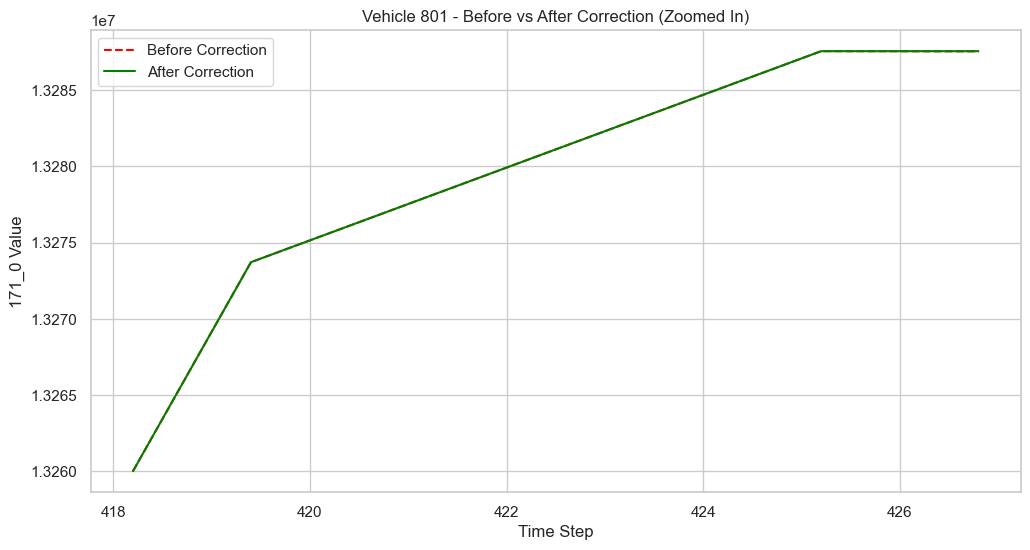

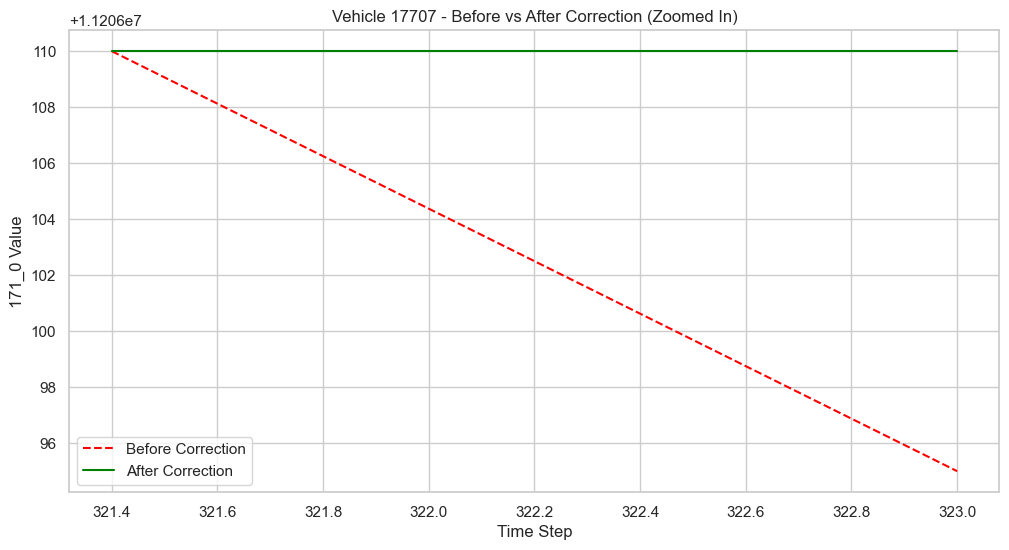

In [29]:
for vehicle_id in corrected_vehicles:
    vehicle_data_before = train_op_num[train_op_num["vehicle_id"] == vehicle_id]
    vehicle_data_after = train_op_num_fixed[train_op_num_fixed["vehicle_id"] == vehicle_id]

    # Select a window around the reset points
    reset_indices_before = vehicle_data_before[vehicle_data_before["171_0"].diff() < 0].index
    reset_indices_after = vehicle_data_after[vehicle_data_after["171_0"].diff() < 0].index

    if reset_indices_before.size > 0:
        reset_time_step = vehicle_data_before.loc[reset_indices_before[0], "time_step"]
        window_start = reset_time_step - 10  # 10 time steps before reset
        window_end = reset_time_step + 10    # 10 time steps after reset

        # Zoom into the time window for before and after
        zoomed_before = vehicle_data_before[(vehicle_data_before["time_step"] >= window_start) & (vehicle_data_before["time_step"] <= window_end)]
        zoomed_after = vehicle_data_after[(vehicle_data_after["time_step"] >= window_start) & (vehicle_data_after["time_step"] <= window_end)]

        plt.figure(figsize=(12, 6))
        plt.plot(zoomed_before["time_step"], zoomed_before["171_0"], label="Before Correction", color="red", linestyle="--")
        plt.plot(zoomed_after["time_step"], zoomed_after["171_0"], label="After Correction", color="green")
        plt.title(f"Vehicle {vehicle_id} - Before vs After Correction (Zoomed In)")
        plt.xlabel("Time Step")
        plt.ylabel("171_0 Value")
        plt.legend()
        plt.grid(True)
        plt.show()

In [30]:
train_op_norm = train_op_num_fixed.copy()

# Compute normalized differences (i.e., rate of change)
for col in numerical_counters:
    nd = col + "_nd"
    train_op_norm[nd] = train_op_norm.groupby("vehicle_id")[col].diff() / train_op_norm["time_diff"]

# Drop the original counter columns (keep only normalized differences)
train_op_norm = train_op_norm[["vehicle_id", "time_step"] + [col + "_nd" for col in numerical_counters]]

train_op_norm

vehicle_id  time_step      171_0_nd     666_0_nd      427_0_nd  \
0                 0       11.2           NaN          NaN           NaN   
2                 0       19.6  19957.317073   455.853659  7.646087e+05   
5                 0       28.0  30122.142857   934.000000  1.129560e+06   
8                 0       31.2  48658.333333  1455.000000  1.847560e+06   
10                0       33.6  24320.454545  1135.909091  9.382450e+05   
...             ...        ...           ...          ...           ...   
1122447       33643      101.0  12842.500000   327.833333  4.712712e+05   
1122448       33643      107.0  24412.500000   541.333333  9.285302e+05   
1122449       33643      113.8  26408.823529   545.588235  9.999388e+05   
1122450       33643      119.8  27397.500000   455.166667  1.040585e+06   
1122451       33643      125.8  19035.000000   308.000000  7.399938e+05   

           837_0_nd   309_0_nd      835_0_nd  370_0_nd       100_0_nd  
0               NaN        NaN           NaN       NaN            NaN  
2         37.073171   0.000000  5.780818e+05       0.0   63509.878049  
5         97.142857   0.000000  1.095197e+06       0.0   62263.142857  
8         98.333333   0.000000  1.753739e+06       0.0   82158.888889  
10       323.636364   0.000000  9.082191e+05       0.0   50975.000000  
...             ...        ...           ...       ...            ...  
1122447  144.166667  14.000000  5.373317e+05       0.0   68091.666667  
1122448  325.333333  32.666667  1.060405e+06       0.0  135155.000000  
1122449  234.264706  18.529412  1.039053e+06       0.0   90819.852941  
1122450  157.333333  18.666667  1.131432e+06       0.0  122282.500000  
1122451   61.333333   0.000000  1.051425e+06       0.0  216149.166667  

[953263 rows x 10 columns]

Outlier counts per normalized-diff variable:
 171_0_nd     7741
666_0_nd    17793
427_0_nd     6157
837_0_nd    19287
309_0_nd    15286
835_0_nd    10966
370_0_nd    24681
100_0_nd    10886
dtype: int64


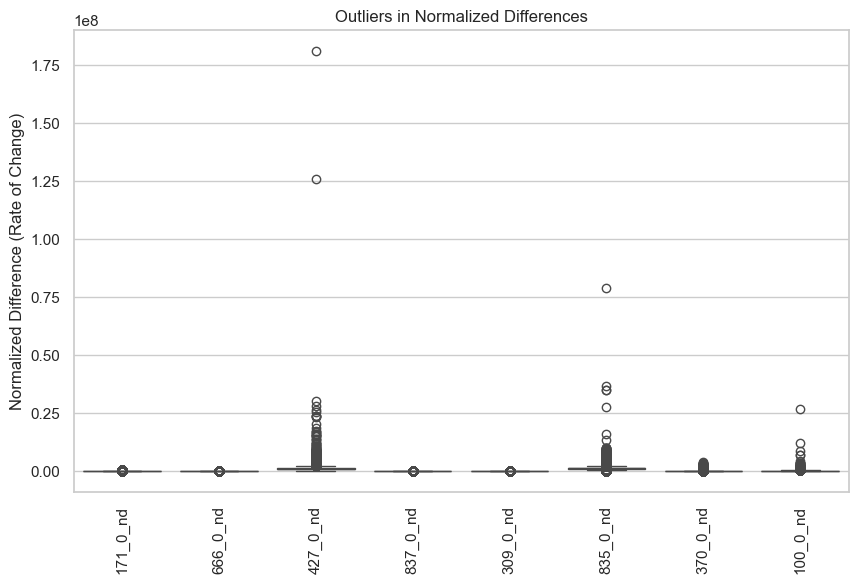

In [31]:
# Outlier Detection in normalized differences (z-score > 3)
# Columns for normalized differences
nd_cols = [c + "_nd" for c in numerical_counters]
# Replace infinities (e.g., divide by zero) with NaN
train_op_norm[nd_cols] = train_op_norm[nd_cols].replace([np.inf, -np.inf], np.nan)

# Compute z-scores for normalized differences
z = train_op_norm[nd_cols].apply(lambda col: zscore(col.fillna(0)))
outlier_mask = (np.abs(z) > 3)
print("Outlier counts per normalized-diff variable:\n", outlier_mask.sum())

plt.figure(figsize=(10, 6))
sns.boxplot(data=train_op_norm[nd_cols])
plt.title("Outliers in Normalized Differences")
plt.ylabel("Normalized Difference (Rate of Change)")
plt.xticks(rotation=90)
plt.show()

          171_0_nd  666_0_nd  427_0_nd  837_0_nd  309_0_nd  835_0_nd  \
171_0_nd  1.000000  0.478814  0.825293  0.273551  0.092891  0.808978   
666_0_nd  0.478814  1.000000  0.435331  0.626825  0.242473  0.530285   
427_0_nd  0.825293  0.435331  1.000000  0.253905  0.095516  0.748712   
837_0_nd  0.273551  0.626825  0.253905  1.000000  0.572039  0.318370   
309_0_nd  0.092891  0.242473  0.095516  0.572039  1.000000  0.137808   
835_0_nd  0.808978  0.530285  0.748712  0.318370  0.137808  1.000000   
370_0_nd -0.061896  0.163070  0.044771  0.118792  0.077235  0.322788   
100_0_nd  0.191640  0.202308  0.435352  0.124770  0.078688  0.487315   

          370_0_nd  100_0_nd  
171_0_nd -0.061896  0.191640  
666_0_nd  0.163070  0.202308  
427_0_nd  0.044771  0.435352  
837_0_nd  0.118792  0.124770  
309_0_nd  0.077235  0.078688  
835_0_nd  0.322788  0.487315  
370_0_nd  1.000000  0.101944  
100_0_nd  0.101944  1.000000  


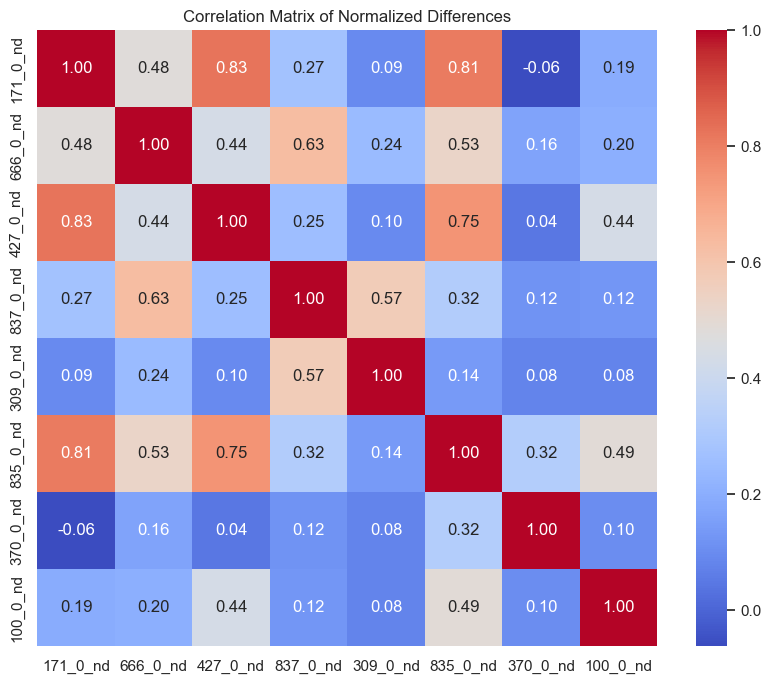

In [32]:
# Step 5: Correlation Matrix for normalized differences
corr = train_op_norm[nd_cols].corr()
print(corr)

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix of Normalized Differences")
plt.show()

In [33]:
corr

171_0_nd  666_0_nd  427_0_nd  837_0_nd  309_0_nd  835_0_nd  \
171_0_nd  1.000000  0.478814  0.825293  0.273551  0.092891  0.808978   
666_0_nd  0.478814  1.000000  0.435331  0.626825  0.242473  0.530285   
427_0_nd  0.825293  0.435331  1.000000  0.253905  0.095516  0.748712   
837_0_nd  0.273551  0.626825  0.253905  1.000000  0.572039  0.318370   
309_0_nd  0.092891  0.242473  0.095516  0.572039  1.000000  0.137808   
835_0_nd  0.808978  0.530285  0.748712  0.318370  0.137808  1.000000   
370_0_nd -0.061896  0.163070  0.044771  0.118792  0.077235  0.322788   
100_0_nd  0.191640  0.202308  0.435352  0.124770  0.078688  0.487315   

          370_0_nd  100_0_nd  
171_0_nd -0.061896  0.191640  
666_0_nd  0.163070  0.202308  
427_0_nd  0.044771  0.435352  
837_0_nd  0.118792  0.124770  
309_0_nd  0.077235  0.078688  
835_0_nd  0.322788  0.487315  
370_0_nd  1.000000  0.101944  
100_0_nd  0.101944  1.000000

In [34]:
# Compare “last-step” normalized diffs (healthy vs fault)
# 1) Get last observation per vehicle
last = (train_op_norm
        .sort_values(["vehicle_id", "time_step"])
        .groupby("vehicle_id")
        .last()
        .reset_index())

# 2) Merge with repair information
cmp = last[["vehicle_id"] + nd_cols].merge(train_rep, on="vehicle_id")

# 3) Split and average
healthy = cmp[cmp["in_study_repair"] == 0][nd_cols].mean()
faulty  = cmp[cmp["in_study_repair"] == 1][nd_cols].mean()

comparison = pd.DataFrame({"healthy_mean": healthy, "faulty_mean": faulty})
print(comparison)

           healthy_mean   faulty_mean
171_0_nd   22152.729160  2.872973e+04
666_0_nd     710.822429  9.841694e+02
427_0_nd  839187.000379  1.078711e+06
837_0_nd     296.489676  4.830814e+02
309_0_nd     107.045716  2.092120e+02
835_0_nd  961008.350482  1.202220e+06
370_0_nd   43777.235013  5.020236e+04
100_0_nd  100092.374886  1.172546e+05


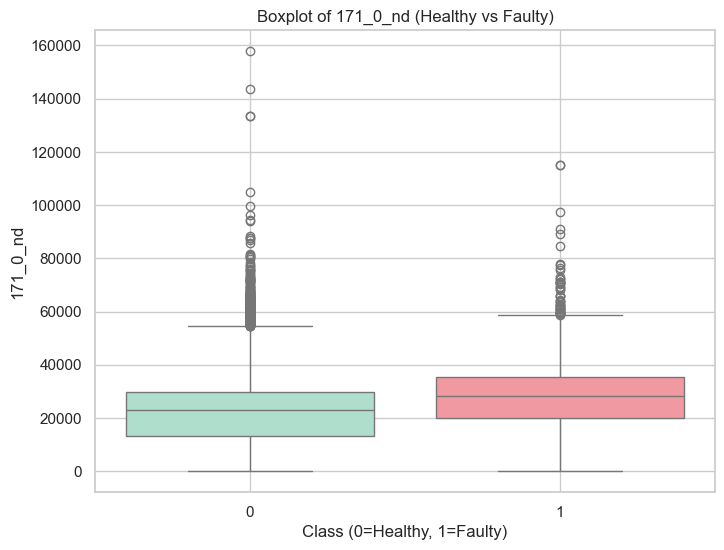

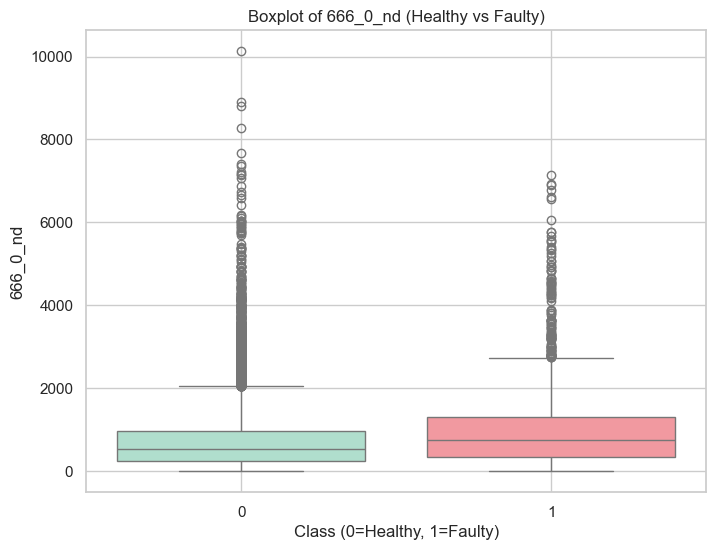

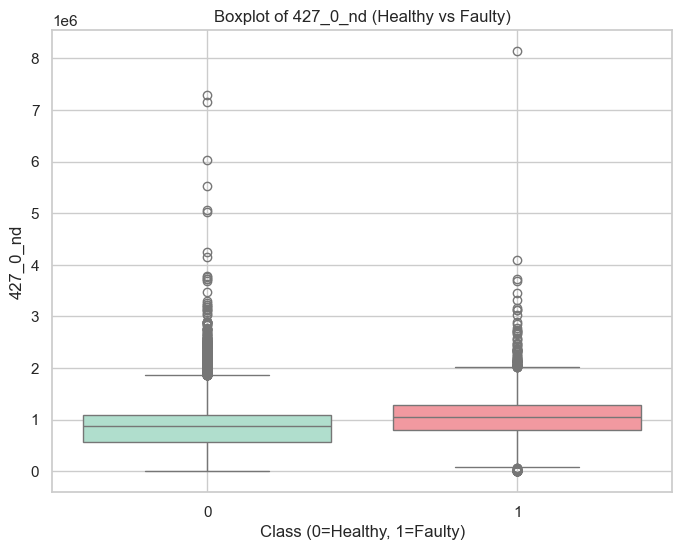

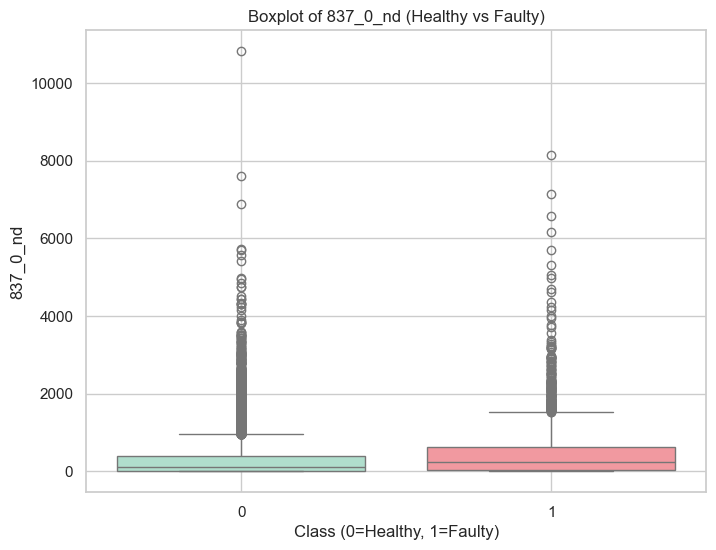

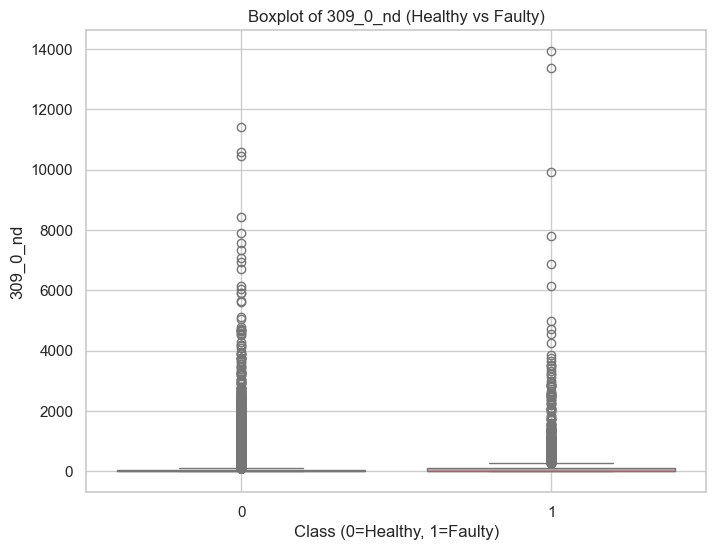

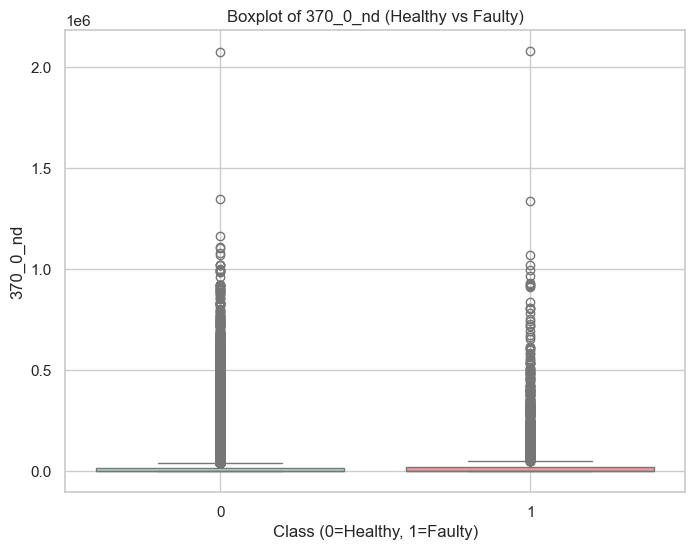

In [35]:
# Melt the dataframe into a long format, easier for seaborn
cmp_melted = cmp.melt(id_vars=["vehicle_id", "in_study_repair"],
                      value_vars=nd_cols,
                      var_name="Sensor",
                      value_name="Normalized_Diff")

# Softer pastel colors
palette = {0: "#a8e6cf", 1: "#ff8b94"}

# For each variable separately
for col in nd_cols:
    plt.figure(figsize=(8, 6))

    sns.boxplot(data=cmp, x="in_study_repair", y=col, hue="in_study_repair",
                palette=palette, dodge=False, legend=False)

    plt.title(f"Boxplot of {col} (Healthy vs Faulty)")
    plt.xlabel("Class (0=Healthy, 1=Faulty)")
    plt.ylabel(col)
    plt.grid(True)
    plt.show()

In [36]:
# Per-vehicle variability (standard deviation) of each rate
veh_stats = (train_op_norm
             .groupby("vehicle_id")[nd_cols]
             .agg(["mean", "std"])
             .sort_index())
veh_stats.head()

171_0_nd                  666_0_nd                   427_0_nd  \
                    mean           std        mean         std           mean   
vehicle_id                                                                      
0           22905.623364   8840.248972  812.052657  427.472908  286701.715794   
2           20783.106556   3437.639541  967.665491  266.567330  854780.634375   
3           24934.970606   9723.575419  731.495745  442.803763  899312.980987   
4           24068.129360  14167.100295  791.035001  665.270731  855713.532075   
5           16544.012870   9460.589550  657.990531  479.894960  626948.255538   

                             837_0_nd               309_0_nd             \
                      std        mean         std       mean        std   
vehicle_id                                                                
0           508794.030411   78.667823  108.523988   0.412375   1.666355   
2           131285.161234  231.530786  140.819876   5.287487  12.962868   
3           336933.944958  299.534065  214.070018  30.929897  31.664568   
4           506487.775553  555.809778  552.444687   3.021704   4.083025   
5           334722.185228  389.766560  290.889302  35.787933  59.969249   

                 835_0_nd                370_0_nd            100_0_nd  \
                     mean            std     mean  std           mean   
vehicle_id                                                              
0           860732.378586  345519.159523      0.0  0.0   18124.244049   
2           959468.412242  157180.115938      0.0  0.0  116072.216015   
3           840442.858423  327948.216873      0.0  0.0   42167.281596   
4           929295.942357  539375.627314      0.0  0.0   99355.828008   
5           694196.025997  404612.122218      0.0  0.0   90997.989794   

                          
                     std  
vehicle_id                
0           34452.003431  
2           38132.025453  
3           16410.062696  
4           58361.819363  
5           62781.703150

In [37]:
# Find per-vehicle constant features
nunique_per_vehicle = (train_op_norm
                       .groupby("vehicle_id")[nd_cols]
                       .nunique())

# If a sensor has only 1 unique value for a vehicle, it's constant for that vehicle
constant_mask = (nunique_per_vehicle == 1)

# Summarize:
constant_summary = constant_mask.sum(axis=0)

print("Number of vehicles where each sensor is constant:\n", constant_summary)

# Optionally, list sensors that are constant across *all* vehicles
fully_constant_sensors = constant_summary[constant_summary == constant_mask.shape[0]].index.tolist()
print("\nSensors constant across ALL vehicles:", fully_constant_sensors)

Number of vehicles where each sensor is constant:
 171_0_nd        0
666_0_nd        5
427_0_nd        2
837_0_nd      426
309_0_nd     1878
835_0_nd        0
370_0_nd    15054
100_0_nd        2
dtype: int64

Sensors constant across ALL vehicles: []


In [38]:
# Check the original 370_0 variable
nunique_original_370 = (train_op_num_fixed
                        .groupby("vehicle_id")["370_0"]
                        .nunique())

# How many vehicles have constant original 370_0?
constant_vehicles_370 = (nunique_original_370 == 1)

print(f"Number of vehicles with constant original 370_0: {constant_vehicles_370.sum()} / {nunique_original_370.shape[0]} vehicles")

# Optional: list vehicle IDs where 370_0 is constant
constant_vehicle_ids = constant_vehicles_370[constant_vehicles_370].index.tolist()
print("\nVehicles with constant 370_0:", constant_vehicle_ids[:10], "...")

Number of vehicles with constant original 370_0: 15054 / 23550 vehicles

Vehicles with constant 370_0: [0, 2, 3, 4, 5, 15, 17, 22, 25, 26] ...


In [39]:
train_op_norm

vehicle_id  time_step      171_0_nd     666_0_nd      427_0_nd  \
0                 0       11.2           NaN          NaN           NaN   
2                 0       19.6  19957.317073   455.853659  7.646087e+05   
5                 0       28.0  30122.142857   934.000000  1.129560e+06   
8                 0       31.2  48658.333333  1455.000000  1.847560e+06   
10                0       33.6  24320.454545  1135.909091  9.382450e+05   
...             ...        ...           ...          ...           ...   
1122447       33643      101.0  12842.500000   327.833333  4.712712e+05   
1122448       33643      107.0  24412.500000   541.333333  9.285302e+05   
1122449       33643      113.8  26408.823529   545.588235  9.999388e+05   
1122450       33643      119.8  27397.500000   455.166667  1.040585e+06   
1122451       33643      125.8  19035.000000   308.000000  7.399938e+05   

           837_0_nd   309_0_nd      835_0_nd  370_0_nd       100_0_nd  
0               NaN        NaN           NaN       NaN            NaN  
2         37.073171   0.000000  5.780818e+05       0.0   63509.878049  
5         97.142857   0.000000  1.095197e+06       0.0   62263.142857  
8         98.333333   0.000000  1.753739e+06       0.0   82158.888889  
10       323.636364   0.000000  9.082191e+05       0.0   50975.000000  
...             ...        ...           ...       ...            ...  
1122447  144.166667  14.000000  5.373317e+05       0.0   68091.666667  
1122448  325.333333  32.666667  1.060405e+06       0.0  135155.000000  
1122449  234.264706  18.529412  1.039053e+06       0.0   90819.852941  
1122450  157.333333  18.666667  1.131432e+06       0.0  122282.500000  
1122451   61.333333   0.000000  1.051425e+06       0.0  216149.166667  

[953263 rows x 10 columns]

In [40]:
train_op_norm = train_op_norm.drop(columns = ["370_0_nd", "835_0_nd"])
train_op_norm

vehicle_id  time_step      171_0_nd     666_0_nd      427_0_nd  \
0                 0       11.2           NaN          NaN           NaN   
2                 0       19.6  19957.317073   455.853659  7.646087e+05   
5                 0       28.0  30122.142857   934.000000  1.129560e+06   
8                 0       31.2  48658.333333  1455.000000  1.847560e+06   
10                0       33.6  24320.454545  1135.909091  9.382450e+05   
...             ...        ...           ...          ...           ...   
1122447       33643      101.0  12842.500000   327.833333  4.712712e+05   
1122448       33643      107.0  24412.500000   541.333333  9.285302e+05   
1122449       33643      113.8  26408.823529   545.588235  9.999388e+05   
1122450       33643      119.8  27397.500000   455.166667  1.040585e+06   
1122451       33643      125.8  19035.000000   308.000000  7.399938e+05   

           837_0_nd   309_0_nd       100_0_nd  
0               NaN        NaN            NaN  
2         37.073171   0.000000   63509.878049  
5         97.142857   0.000000   62263.142857  
8         98.333333   0.000000   82158.888889  
10       323.636364   0.000000   50975.000000  
...             ...        ...            ...  
1122447  144.166667  14.000000   68091.666667  
1122448  325.333333  32.666667  135155.000000  
1122449  234.264706  18.529412   90819.852941  
1122450  157.333333  18.666667  122282.500000  
1122451   61.333333   0.000000  216149.166667  

[953263 rows x 8 columns]

In [41]:
train_op_norm.columns

Index(['vehicle_id', 'time_step', '171_0_nd', '666_0_nd', '427_0_nd',
       '837_0_nd', '309_0_nd', '100_0_nd'],
      dtype='object')

In [42]:
# Remove "_nd" from column names, except for "vehicle_id" and "time_step"
train_op_norm_clean = train_op_norm.rename(
    columns={col: col.replace("_nd", "") for col in train_op_norm.columns if col not in ["vehicle_id", "time_step"]}
)
train_op_norm_clean

vehicle_id  time_step         171_0        666_0         427_0  \
0                 0       11.2           NaN          NaN           NaN   
2                 0       19.6  19957.317073   455.853659  7.646087e+05   
5                 0       28.0  30122.142857   934.000000  1.129560e+06   
8                 0       31.2  48658.333333  1455.000000  1.847560e+06   
10                0       33.6  24320.454545  1135.909091  9.382450e+05   
...             ...        ...           ...          ...           ...   
1122447       33643      101.0  12842.500000   327.833333  4.712712e+05   
1122448       33643      107.0  24412.500000   541.333333  9.285302e+05   
1122449       33643      113.8  26408.823529   545.588235  9.999388e+05   
1122450       33643      119.8  27397.500000   455.166667  1.040585e+06   
1122451       33643      125.8  19035.000000   308.000000  7.399938e+05   

              837_0      309_0          100_0  
0               NaN        NaN            NaN  
2         37.073171   0.000000   63509.878049  
5         97.142857   0.000000   62263.142857  
8         98.333333   0.000000   82158.888889  
10       323.636364   0.000000   50975.000000  
...             ...        ...            ...  
1122447  144.166667  14.000000   68091.666667  
1122448  325.333333  32.666667  135155.000000  
1122449  234.264706  18.529412   90819.852941  
1122450  157.333333  18.666667  122282.500000  
1122451   61.333333   0.000000  216149.166667  

[953263 rows x 8 columns]

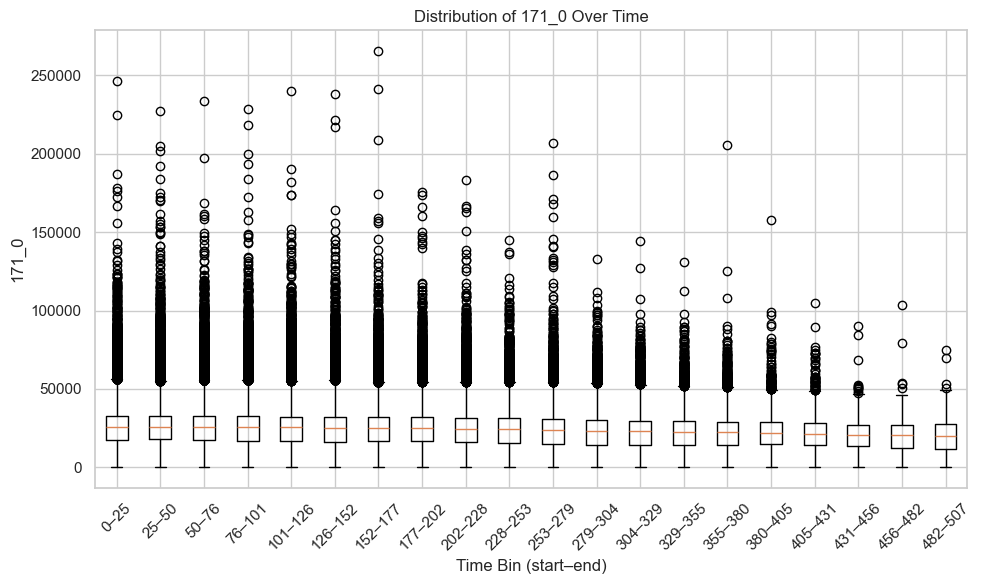

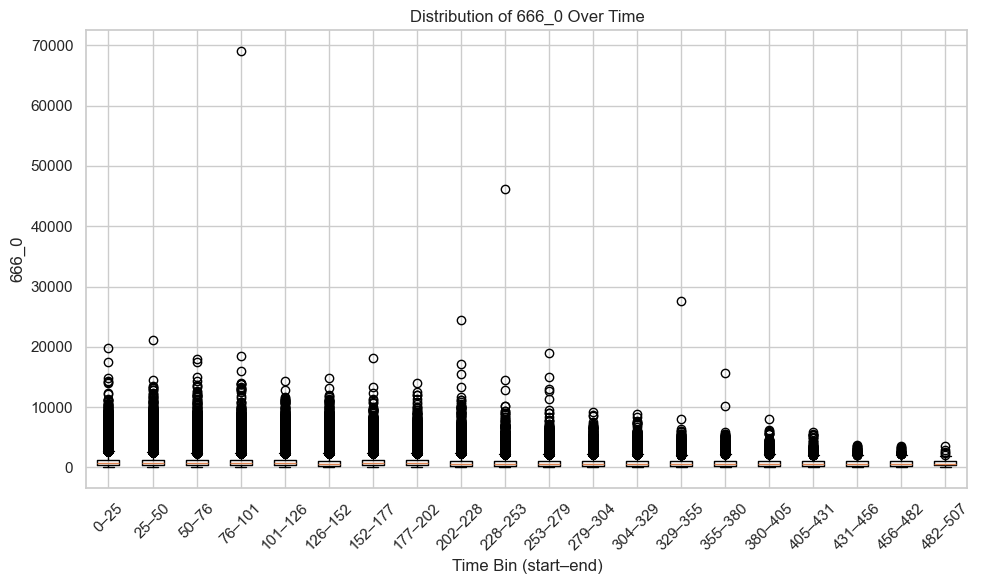

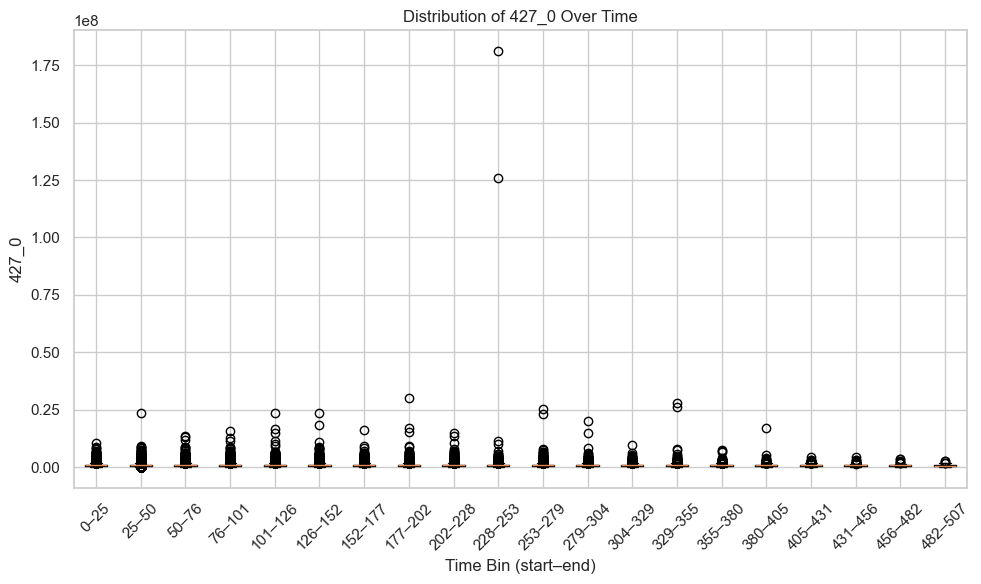

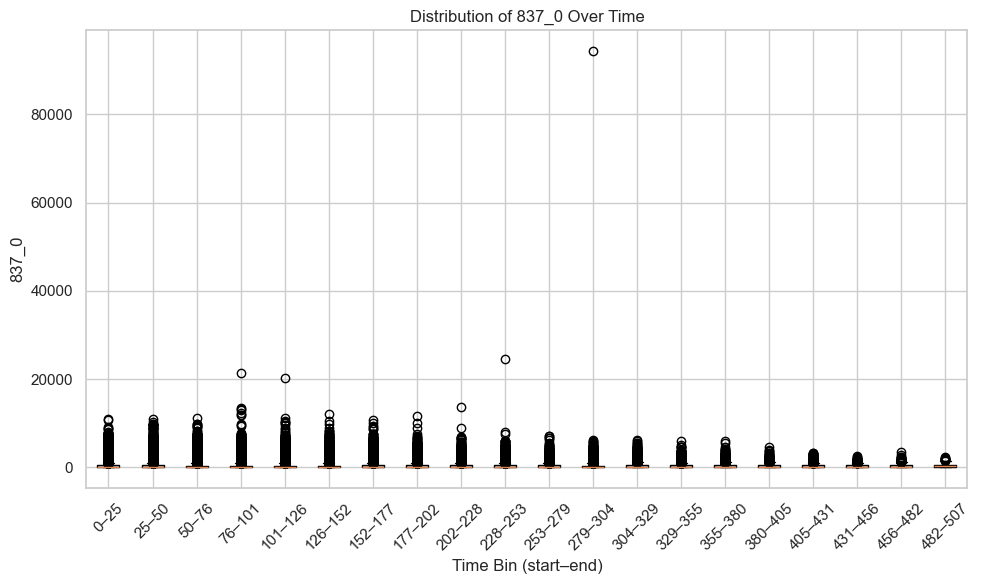

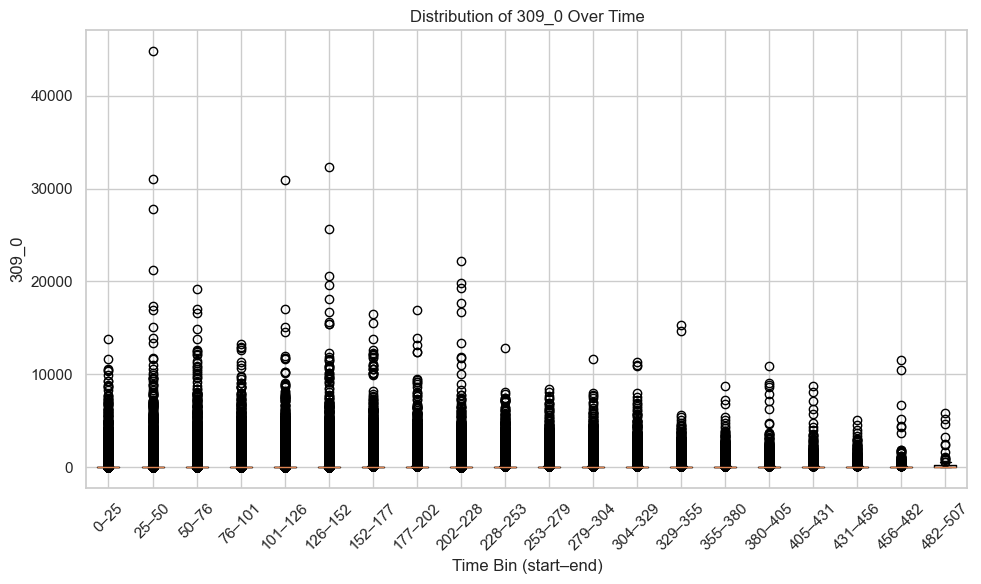

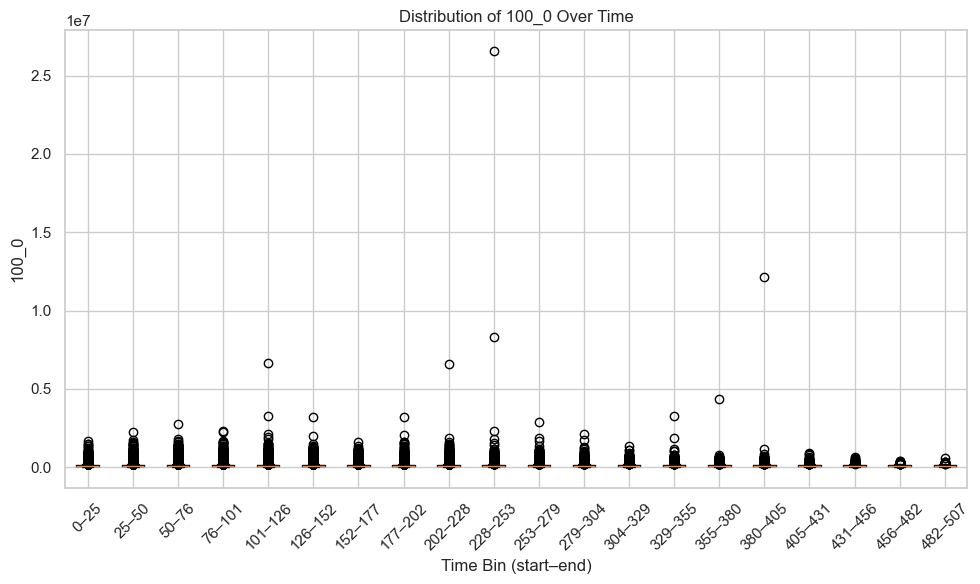

In [43]:
# Copy the clean normalized‐diffs dataset for analysis only
analysis_df = train_op_norm_clean.copy()

# Identify normalized‐diff columns (everything except vehicle_id and time_step)
nd_cols = [c for c in analysis_df.columns if c not in ['vehicle_id', 'time_step']]

# Number of time bins
n_bins = 20

# Compute the overall min/max of time_step
tmin = analysis_df['time_step'].min()
tmax = analysis_df['time_step'].max()

# Create equal-width bin edges
bins = np.linspace(tmin, tmax, n_bins + 1)

# Assign each row to a time bin in the analysis_df only
analysis_df['time_bin'] = pd.cut(
    analysis_df['time_step'],
    bins=bins,
    include_lowest=True
)

# Now make one boxplot per normalized-diff variable
for col in nd_cols:
    # Gather values per bin
    grouped = analysis_df.groupby('time_bin')[col].apply(lambda s: s.dropna().values)
    data = [vals for vals in grouped]

    plt.figure(figsize=(10, 6))
    plt.boxplot(
        data,
        labels=[f"{int(bins[i])}–{int(bins[i+1])}" for i in range(n_bins)],
        whis=1.5
    )
    plt.title(f"Distribution of {col} Over Time")
    plt.xlabel("Time Bin (start–end)")
    plt.ylabel(col)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

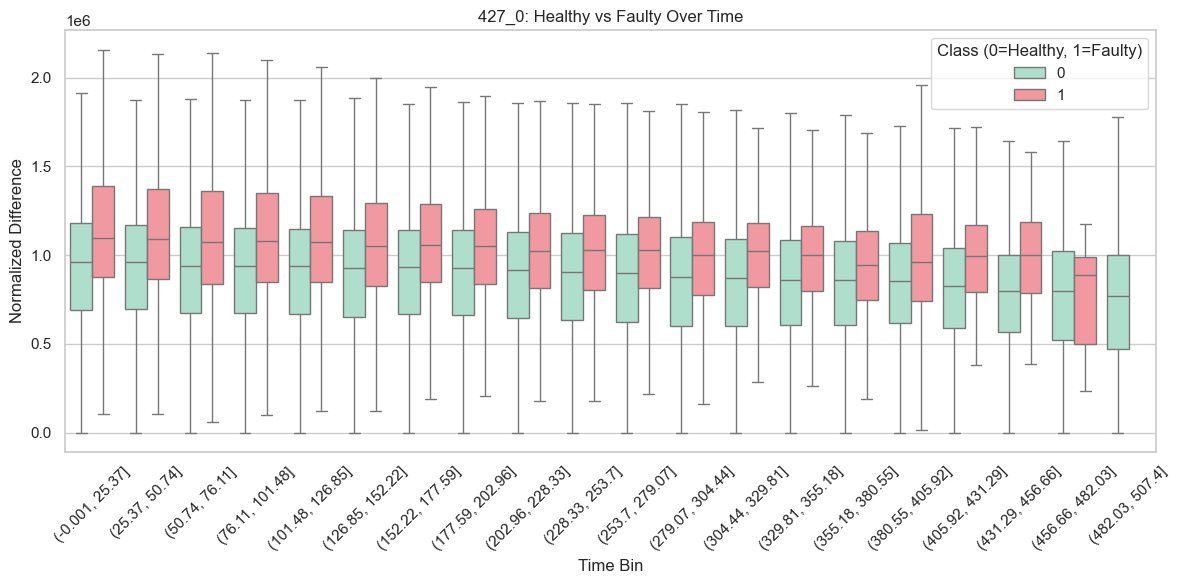

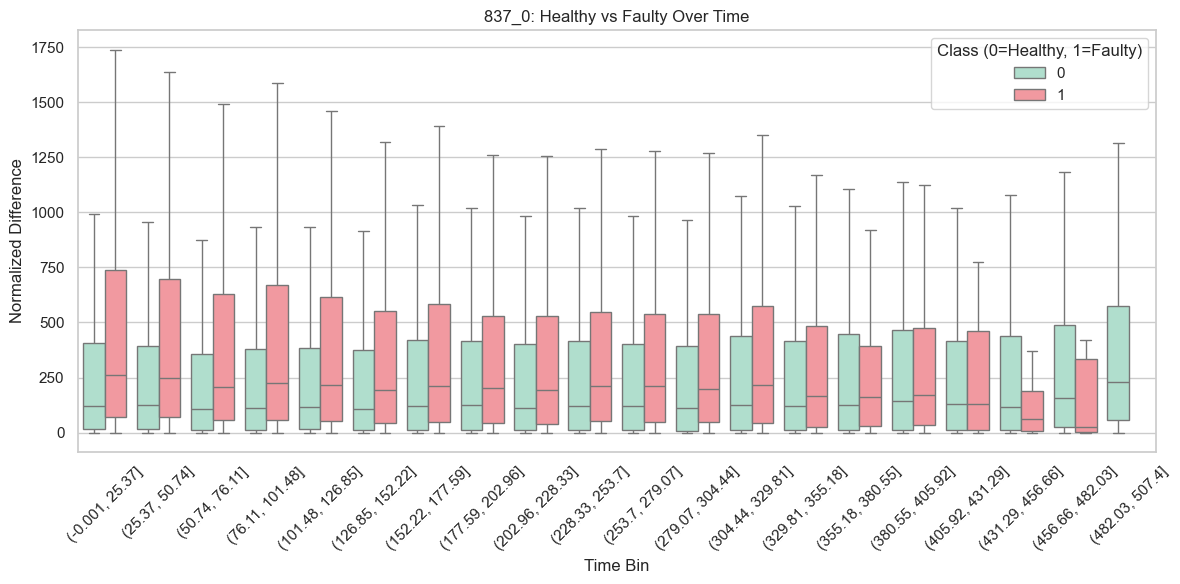

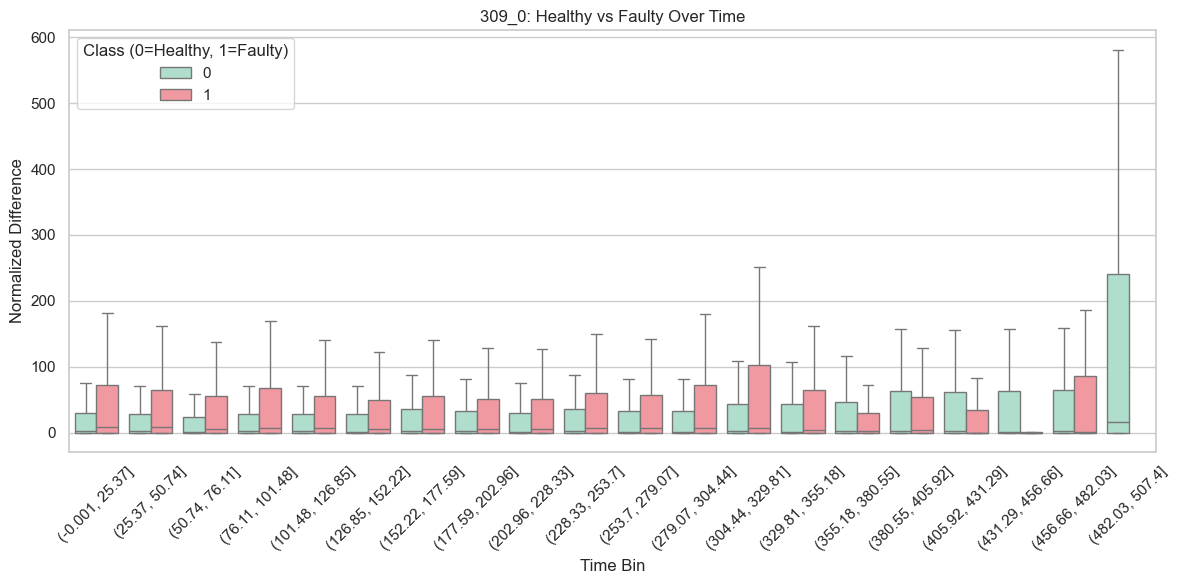

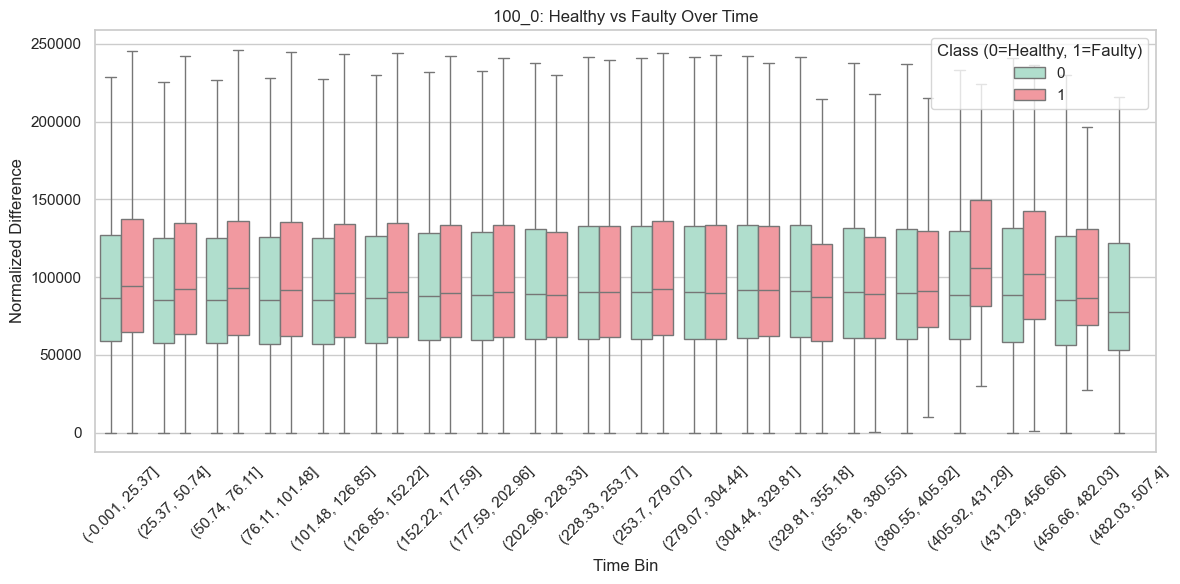

In [44]:
# 1) Copy so we don't touch clean DataFrame
analysis_df = train_op_norm_clean.copy()

# 2) Merge in the class label (0=healthy, 1=faulty)
analysis_df = analysis_df.merge(
    train_rep.rename(columns={'in_study_repair':'class_label'}),
    on='vehicle_id'
)

# 3) Identify normalized-diff columns
nd_cols = [c for c in analysis_df.columns
           if c not in ['vehicle_id','time_step','class_label']]

# 4) Create time bins
n_bins = 20
tmin, tmax = analysis_df['time_step'].min(), analysis_df['time_step'].max()
bins = np.linspace(tmin, tmax, n_bins+1)
analysis_df['time_bin'] = pd.cut(
    analysis_df['time_step'], bins=bins, include_lowest=True
)

# 5) Plot each sensor
palette = {0: '#a8e6cf', 1: '#ff8b94'}
for col in nd_cols:
    plt.figure(figsize=(12,6))
    sns.boxplot(
        data=analysis_df,
        x='time_bin', y=col, hue='class_label',
        palette=palette, dodge=True, showfliers=False
    )
    plt.title(f"{col}: Healthy vs Faulty Over Time")
    plt.xlabel("Time Bin")
    plt.ylabel("Normalized Difference")
    plt.xticks(rotation=45)
    plt.legend(title='Class (0=Healthy, 1=Faulty)')
    plt.tight_layout()
    plt.show()

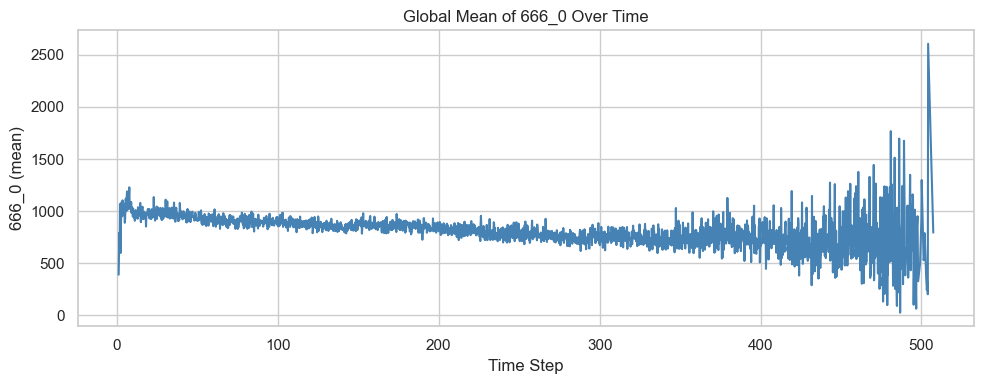

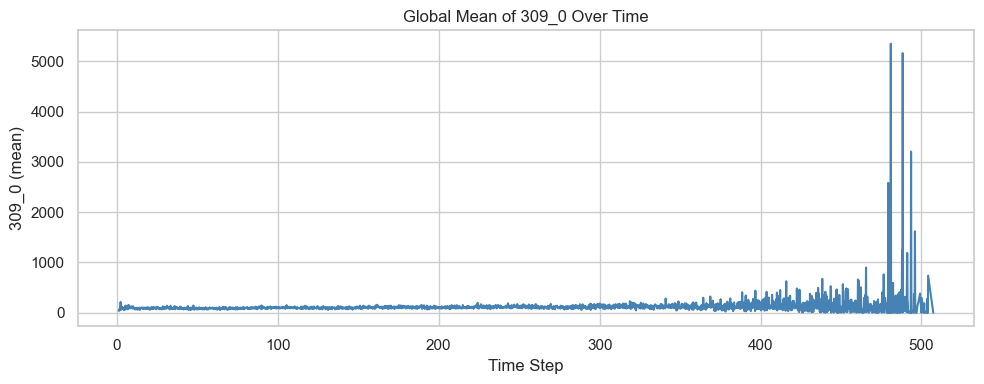

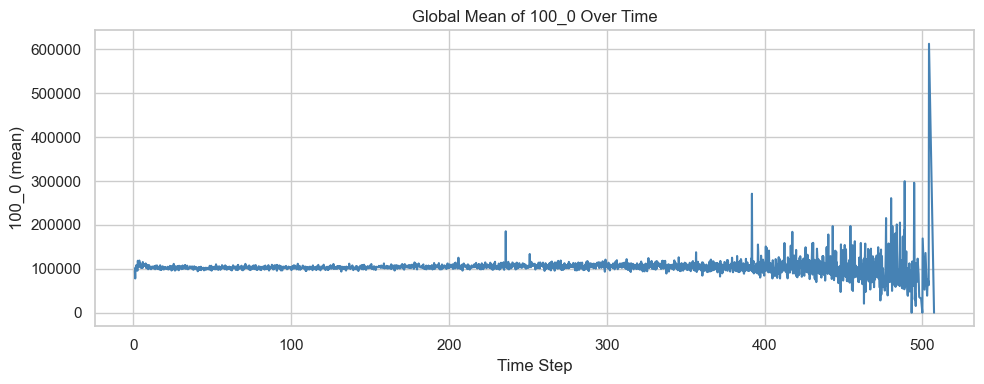

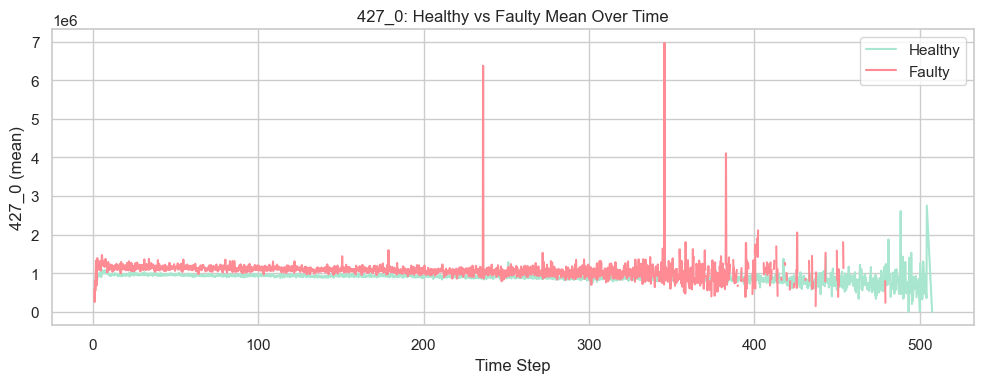

In [45]:
# --- 1) Prepare data --------------------------------------------------

# Merge in the class label
df = train_op_norm_clean.merge(
    train_rep.rename(columns={'in_study_repair':'class_label'}),
    on='vehicle_id'
)

# List normalized‐diff variables
vars_nd = [c for c in df.columns if c not in ('vehicle_id','time_step','class_label')]

# --- 2) Global mean over time -----------------------------------------

global_mean = df.groupby('time_step')[vars_nd].mean().reset_index()

# Plot each variable’s global mean
for var in vars_nd:
    plt.figure(figsize=(10,4))
    plt.plot(global_mean['time_step'], global_mean[var], color='steelblue')
    plt.title(f"Global Mean of {var} Over Time")
    plt.xlabel("Time Step")
    plt.ylabel(f"{var} (mean)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# --- 3) Healthy vs. Faulty over time ---------------------------------

# Compute mean per time_step and class
class_mean = (
    df
    .groupby(['time_step','class_label'])[vars_nd]
    .mean()
    .reset_index()
)

# Pivot so we can plot
for var in vars_nd:
    pivot = class_mean.pivot(index='time_step', columns='class_label', values=var)
    plt.figure(figsize=(10,4))
    plt.plot(pivot.index, pivot[0], label='Healthy', color='#a8e6cf')
    plt.plot(pivot.index, pivot[1], label='Faulty',  color='#ff8b94')
    plt.title(f"{var}: Healthy vs Faulty Mean Over Time")
    plt.xlabel("Time Step")
    plt.ylabel(f"{var} (mean)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

#### Histogram Variables

In [46]:
# Histogram definitions
histogram_variables = {
    "167": 10,
    "272": 10,
    "291": 11,
    "158": 10,
    "459": 20,
    "397": 36
}

# Build a dict of bin‐column lists for easy reuse
hist_bins = {
    prefix: [f"{prefix}_{i}" for i in range(bins)]
    for prefix, bins in histogram_variables.items()
}

# Define histogram prefixes (this was missing)
histogram_prefixes = list(histogram_variables.keys())

In [47]:
# Check if NaNs appear jointly in histogram attributes
def check_joint_nans(df, prefixes):
    for prefix in prefixes:
        cols = [col for col in df.columns if col.startswith(prefix)]
        if not cols:
            continue
        nan_rows = df[cols].isna().all(axis=1)
        partial_nan_rows = df[cols].isna().any(axis=1) & ~nan_rows
        if partial_nan_rows.any():
            print(f"Inconsistent NaNs found in histogram {prefix}. Some bins have NaNs while others do not.")
        else:
            print(f"NaNs appear jointly in all bins for histogram {prefix}.")

In [48]:
# Check if NaNs appear in strictly consecutive rows (potential sensor issue)
def check_strict_nan_clustering(df, min_consecutive=5):
    nan_mask = df.isna().any(axis=1)
    max_streak = 0
    current_streak = 0
    for value in nan_mask:
        if value:
            current_streak += 1
            max_streak = max(max_streak, current_streak)
        else:
            current_streak = 0
    if max_streak >= min_consecutive:
        print(f"Possible sensor failure detected: NaNs appear in {max_streak} consecutive time steps.")
    else:
        print("No significant consecutive NaNs detected.")

In [49]:
# Run checks
check_joint_nans(train_op, histogram_prefixes)
check_strict_nan_clustering(train_op)

NaNs appear jointly in all bins for histogram 167.
NaNs appear jointly in all bins for histogram 272.
NaNs appear jointly in all bins for histogram 291.
NaNs appear jointly in all bins for histogram 158.
NaNs appear jointly in all bins for histogram 459.
NaNs appear jointly in all bins for histogram 397.
Possible sensor failure detected: NaNs appear in 170 consecutive time steps.


In [50]:
# Joint-NaN summary
per_vehicle_allnan = {}
for prefix, n_bins in histogram_variables.items():
    cols = [f"{prefix}_{i}" for i in range(n_bins)]
    rate = (train_op[cols].isna().all(axis=1)
                  .groupby(train_op['vehicle_id'])
                  .mean() * 100)
    per_vehicle_allnan[prefix] = rate

per_vehicle_allnan_df = pd.DataFrame(per_vehicle_allnan).round(2)
per_vehicle_allnan_df

167  272   291  158   459  397
vehicle_id                                  
0           98.84  0.0  1.16  0.0  1.74  0.0
2            0.00  0.0  0.00  0.0  0.00  0.0
3           33.80  0.0  0.00  0.0  0.00  0.0
4           52.94  0.0  0.00  0.0  0.00  0.0
5           77.27  0.0  0.00  0.0  2.27  0.0
...           ...  ...   ...  ...   ...  ...
33639        0.00  0.0  0.00  0.0  0.00  0.0
33640        0.00  0.0  0.00  0.0  0.00  0.0
33641        0.00  0.0  5.56  0.0  5.56  0.0
33642        0.00  0.0  0.00  0.0  0.00  0.0
33643        0.00  0.0  0.00  0.0  0.00  0.0

[23550 rows x 6 columns]

In [51]:
# Overall joint-NaN rate per histogram
overall_joint_nan = per_vehicle_allnan_df.mean().round(2)
print("Average % of timestamps fully missing, per histogram:")
overall_joint_nan

Average % of timestamps fully missing, per histogram:


167    0.19
272    0.04
291    0.84
158    0.05
459    0.73
397    0.05
dtype: float64

Even though histograms 291 (0,84%) and 459 (0,73%) are the highest, in absolute terms, fewer than 1% of all time-steps are missing. Compared to the dimensionality of the dataset, this is tiny. Therefore, it is possible to safely impute the missing rows (rather than missing the entire vehicle or histogram information).

In [52]:
all_hist_cols = []
for prefix, n_bins in histogram_variables.items():
    all_hist_cols += [f"{prefix}_{i}" for i in range(n_bins)]
train_op_hist = train_op[['vehicle_id','time_step'] + all_hist_cols].copy()

In [53]:
# ffill/bfill by vehicle
train_op_hist[all_hist_cols] = (
    train_op_hist
    .groupby('vehicle_id')[all_hist_cols]
    .apply(lambda df: df.ffill().bfill())
    .reset_index(level=0, drop=True)
)

In [54]:
# Detect vehicles with *all* NaNs in their histograms
nan_mask = train_op_hist[all_hist_cols].isna().all(axis=1)
vehicles_all_nan = train_op_hist.loc[nan_mask, 'vehicle_id'].unique()
if len(vehicles_all_nan):
    print(f"Vehicles missing all histogram bins: {vehicles_all_nan}")
else:
    print("No vehicle is entirely missing its histogram data.")

No vehicle is entirely missing its histogram data.


In [55]:
# Zero-fill remaining NaNs (small %)
train_op_hist[all_hist_cols] = train_op_hist[all_hist_cols].fillna(0)

In [56]:
# Confirm
assert not train_op_hist[all_hist_cols].isna().any().any(), "Still NaNs left!"
print("All histogram bins are now filled.")

All histogram bins are now filled.


In [57]:
# Merge bins
merged_bins = 3
for prefix, n_bins in histogram_variables.items():
    cols = [f"{prefix}_{i}" for i in range(n_bins)]
    size = np.ceil(n_bins / merged_bins).astype(int)
    super_cols = []
    for j in range(merged_bins):
        start = j * size
        end = min((j + 1) * size, n_bins)
        group = cols[start:end]
        sc = f"{prefix}_mbin{j}"
        super_cols.append(sc)
        train_op_hist[sc] = train_op_hist[group].sum(axis=1)
    train_op_hist.drop(columns=cols, inplace=True)
    histogram_variables[prefix] = merged_bins  # update to merged count

# Rename merged‐bin columns from "<prefix>_mbin{j}" → "<prefix>_{j}"
for prefix, n_bins in histogram_variables.items():
    rename_map = {f"{prefix}_mbin{i}": f"{prefix}_{i}"
                  for i in range(n_bins)}
    train_op_hist.rename(columns=rename_map, inplace=True)

In [58]:
# Normalize into frequencies (now using the new "<prefix>_{i}" names)
train_hist_freq = train_op_hist[['vehicle_id','time_step']].copy()

for prefix, n_bins in histogram_variables.items():
    cols      = [f"{prefix}_{i}" for i in range(n_bins)]
    freq_cols = [f"{c}_freq"    for c in cols]

    totals = train_op_hist[cols].sum(axis=1).replace(0, np.nan)
    for col, fcol in zip(cols, freq_cols):
        train_hist_freq[fcol] = train_op_hist[col] / totals

    # Uniform fallback for rows with zero total
    mask_zero = totals.isna() | (totals == 0)
    if mask_zero.any():
        train_hist_freq.loc[mask_zero, freq_cols] = 1.0 / n_bins

    train_hist_freq[freq_cols] = train_hist_freq[freq_cols].astype('float64')

# Final check
tol = 1e-8
for prefix, n_bins in histogram_variables.items():
    freq_cols = [f"{prefix}_{i}_freq" for i in range(n_bins)]
    s = train_hist_freq[freq_cols].sum(axis=1)
    max_dev = (s - 1.0).abs().max()
    print(f"{prefix} max deviation: {max_dev:.2e}")
    assert max_dev < tol

167 max deviation: 2.22e-16
272 max deviation: 2.22e-16
291 max deviation: 2.22e-16
158 max deviation: 2.22e-16
459 max deviation: 3.33e-16
397 max deviation: 2.22e-16


In [59]:
# Compute entropy per histogram (using the renamed freq columns)
for prefix, n_bins in histogram_variables.items():
    # use "<prefix>_<i>_freq"
    freq_cols = [f"{prefix}_{i}_freq" for i in range(n_bins)]
    eps = 1e-9  # to avoid log(0)
    freqs = train_hist_freq[freq_cols].fillna(0).clip(eps)
    ent = freqs.apply(lambda row: stats.entropy(row), axis=1)
    train_hist_freq[f"{prefix}_entropy"] = ent

# Summarize entropy
train_entropy_summary = {
    prefix: {
        'mean': train_hist_freq[f"{prefix}_entropy"].mean(),
        'std':  train_hist_freq[f"{prefix}_entropy"].std(),
        'min':  train_hist_freq[f"{prefix}_entropy"].min(),
        'max':  train_hist_freq[f"{prefix}_entropy"].max(),
    }
    for prefix in histogram_variables
}
entropy_df = pd.DataFrame(train_entropy_summary).T.round(2)
print(entropy_df)

     mean   std   min   max
167  0.45  0.10  0.00  1.10
272  0.44  0.15  0.00  0.76
291  0.88  0.10  0.00  1.10
158  0.61  0.15  0.00  1.05
459  0.87  0.11  0.00  1.10
397  0.81  0.11  0.05  1.08


Higher entropy means that the histogram is very flat, i.e., the events are spread evenly - and therefore, higher variance is present.

Therefore, it is posible to conclude that 291 and 459 histograms have events spread more evenly. On the other hand, histogram 272 is more peaked, on average, meaning that "a value dominates".

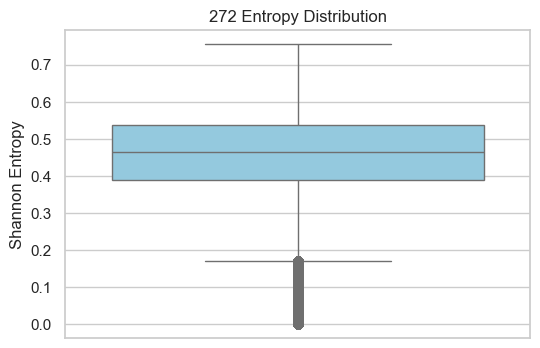

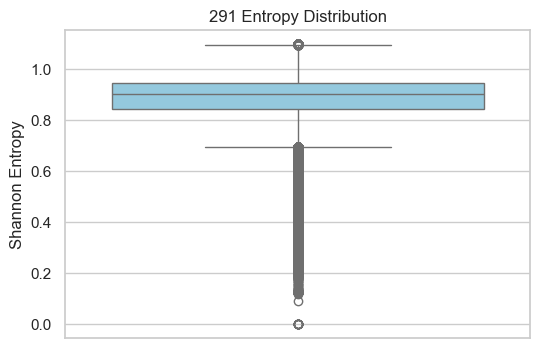

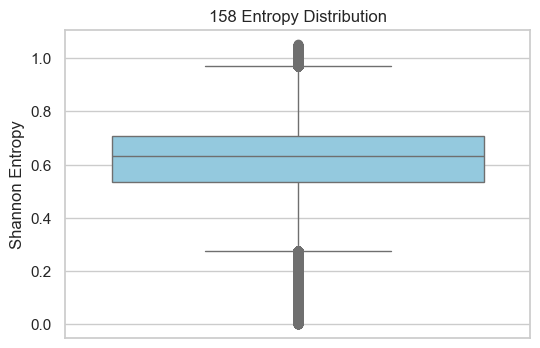

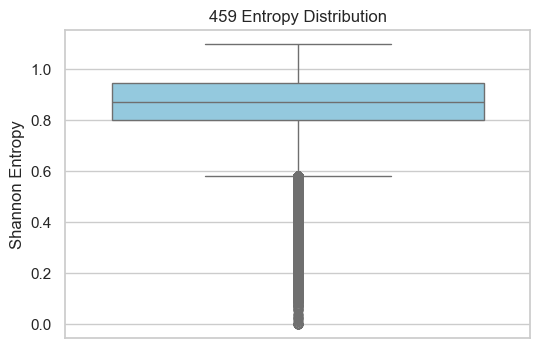

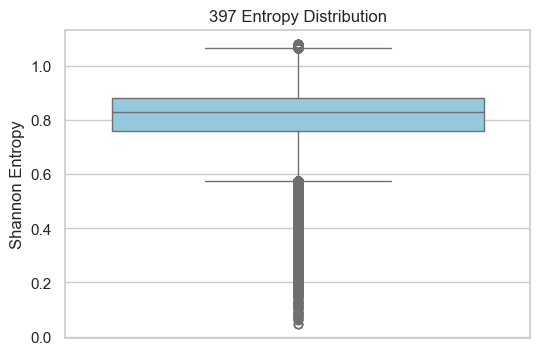

In [60]:
# Boxplots of entropy per histogram
for prefix in histogram_variables:
    plt.figure(figsize=(6,4))
    sns.boxplot(y=train_hist_freq[f"{prefix}_entropy"], color='skyblue')
    plt.title(f"{prefix} Entropy Distribution")
    plt.ylabel("Shannon Entropy")
    plt.show()

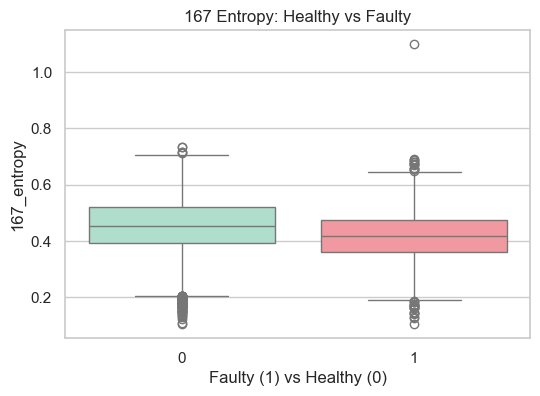

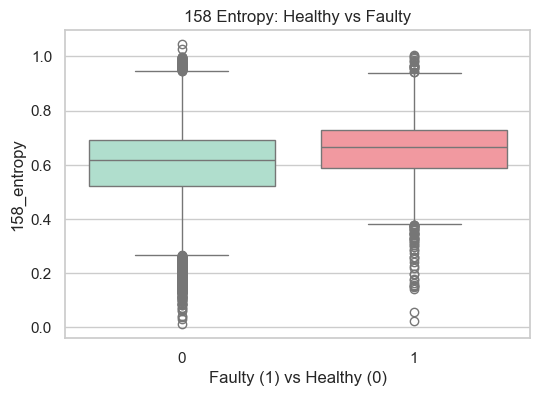

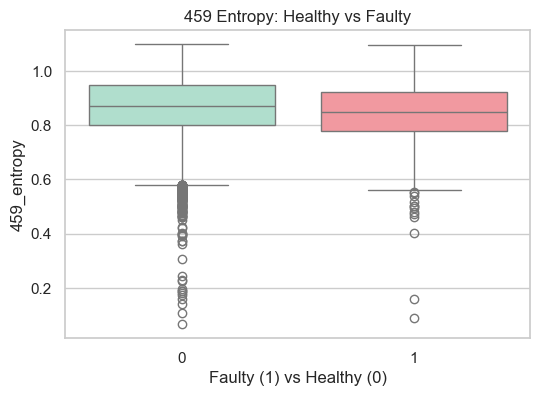

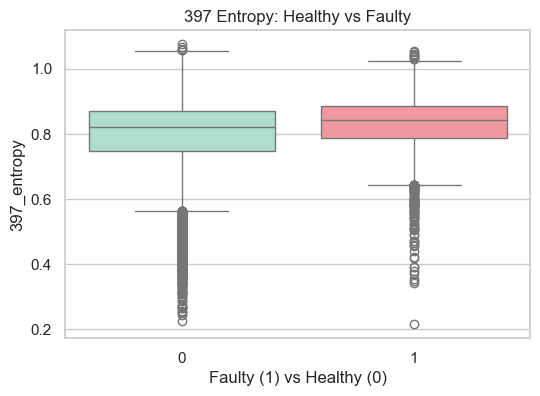

In [61]:
# Relate entropy to failure status
cmp = train_hist_freq[['vehicle_id'] + [f"{p}_entropy" for p in histogram_variables]] \
      .copy().groupby('vehicle_id').mean().reset_index() \
      .merge(train_rep, on='vehicle_id')

for prefix in histogram_variables:
    plt.figure(figsize=(6,4))
    sns.boxplot(data=cmp, x='in_study_repair', y=f"{prefix}_entropy",
                palette={"0":'#a8e6cf',"1":'#ff8b94'})
    plt.title(f"{prefix} Entropy: Healthy vs Faulty")
    plt.xlabel("Faulty (1) vs Healthy (0)")
    plt.show()

In [62]:
train_op_final = train_op_norm_clean.merge(train_hist_freq, on = ["vehicle_id", "time_step"], how = "inner")
train_op_final

vehicle_id  time_step         171_0        666_0         427_0  \
0                0       11.2           NaN          NaN           NaN   
1                0       19.6  19957.317073   455.853659  7.646087e+05   
2                0       28.0  30122.142857   934.000000  1.129560e+06   
3                0       31.2  48658.333333  1455.000000  1.847560e+06   
4                0       33.6  24320.454545  1135.909091  9.382450e+05   
...            ...        ...           ...          ...           ...   
953258       33643      101.0  12842.500000   327.833333  4.712712e+05   
953259       33643      107.0  24412.500000   541.333333  9.285302e+05   
953260       33643      113.8  26408.823529   545.588235  9.999388e+05   
953261       33643      119.8  27397.500000   455.166667  1.040585e+06   
953262       33643      125.8  19035.000000   308.000000  7.399938e+05   

             837_0      309_0          100_0  167_0_freq  167_1_freq  ...  \
0              NaN        NaN            NaN    0.283896    0.715606  ...   
1        37.073171   0.000000   63509.878049    0.284263    0.715239  ...   
2        97.142857   0.000000   62263.142857    0.284263    0.715239  ...   
3        98.333333   0.000000   82158.888889    0.284263    0.715239  ...   
4       323.636364   0.000000   50975.000000    0.284263    0.715239  ...   
...            ...        ...            ...         ...         ...  ...   
953258  144.166667  14.000000   68091.666667    0.179978    0.819619  ...   
953259  325.333333  32.666667  135155.000000    0.183303    0.816248  ...   
953260  234.264706  18.529412   90819.852941    0.178966    0.820530  ...   
953261  157.333333  18.666667  122282.500000    0.176944    0.822492  ...   
953262   61.333333   0.000000  216149.166667    0.189702    0.809767  ...   

        459_2_freq  397_0_freq  397_1_freq  397_2_freq  167_entropy  \
0         0.279954    0.580687    0.197635    0.221678     0.600712   
1         0.370009    0.578711    0.237002    0.184288     0.601050   
2         0.433523    0.586110    0.258373    0.155517     0.601050   
3         0.443920    0.591862    0.260138    0.148000     0.601050   
4         0.445901    0.591739    0.260601    0.147660     0.601050   
...            ...         ...         ...         ...          ...   
953258    0.548248    0.686131    0.234809    0.079060     0.474837   
953259    0.546733    0.688405    0.232885    0.078710     0.480183   
953260    0.546993    0.690460    0.231210    0.078330     0.474054   
953261    0.545695    0.689944    0.231281    0.078775     0.471399   
953262    0.541436    0.693465    0.228595    0.077940     0.490213   

        272_entropy  291_entropy  158_entropy  459_entropy  397_entropy  
0          0.614634     1.026124     0.885714     0.960212     0.970025  
1          0.581591     1.002136     0.847113     0.967230     0.969414  
2          0.537100     1.003541     0.809380     0.954650     0.952214  
3          0.525002     1.003088     0.797049     0.950048     0.943468  
4          0.513193     1.003058     0.794958     0.947733     0.943377  
...             ...          ...          ...          ...          ...  
953258     0.501904     0.879919     0.534033     0.919493     0.799310  
953259     0.505413     0.887366     0.530277     0.920524     0.796477  
953260     0.500570     0.894285     0.526420     0.919651     0.793827  
953261     0.497654     0.894375     0.526512     0.920458     0.794873  
953262     0.513828     0.895523     0.522393     0.925384     0.790095  

[953263 rows x 32 columns]

In [63]:
# Final merge into train_op_final
train_op_final = train_op_norm_clean.merge(train_hist_freq, on=["vehicle_id", "time_step"], how="inner")

# Rename frequency columns
freq_cols = [c for c in train_op_final.columns if c.endswith('_freq')]
rename_map = {c: c.replace('_freq', '') for c in freq_cols}
train_op_final.rename(columns=rename_map, inplace=True)

# Final sanity check
print("Remaining entropy cols:", [c for c in train_op_final.columns if 'entropy' in c])
print("Sample histogram cols:", [c for c in train_op_final.columns if c.startswith('167_')][:5])
print("train_op_final shape:", train_op_final.shape)

Remaining entropy cols: ['167_entropy', '272_entropy', '291_entropy', '158_entropy', '459_entropy', '397_entropy']
Sample histogram cols: ['167_0', '167_1', '167_2', '167_entropy']
train_op_final shape: (953263, 32)


In [64]:
train_op_final

vehicle_id  time_step         171_0        666_0         427_0  \
0                0       11.2           NaN          NaN           NaN   
1                0       19.6  19957.317073   455.853659  7.646087e+05   
2                0       28.0  30122.142857   934.000000  1.129560e+06   
3                0       31.2  48658.333333  1455.000000  1.847560e+06   
4                0       33.6  24320.454545  1135.909091  9.382450e+05   
...            ...        ...           ...          ...           ...   
953258       33643      101.0  12842.500000   327.833333  4.712712e+05   
953259       33643      107.0  24412.500000   541.333333  9.285302e+05   
953260       33643      113.8  26408.823529   545.588235  9.999388e+05   
953261       33643      119.8  27397.500000   455.166667  1.040585e+06   
953262       33643      125.8  19035.000000   308.000000  7.399938e+05   

             837_0      309_0          100_0     167_0     167_1  ...  \
0              NaN        NaN            NaN  0.283896  0.715606  ...   
1        37.073171   0.000000   63509.878049  0.284263  0.715239  ...   
2        97.142857   0.000000   62263.142857  0.284263  0.715239  ...   
3        98.333333   0.000000   82158.888889  0.284263  0.715239  ...   
4       323.636364   0.000000   50975.000000  0.284263  0.715239  ...   
...            ...        ...            ...       ...       ...  ...   
953258  144.166667  14.000000   68091.666667  0.179978  0.819619  ...   
953259  325.333333  32.666667  135155.000000  0.183303  0.816248  ...   
953260  234.264706  18.529412   90819.852941  0.178966  0.820530  ...   
953261  157.333333  18.666667  122282.500000  0.176944  0.822492  ...   
953262   61.333333   0.000000  216149.166667  0.189702  0.809767  ...   

           459_2     397_0     397_1     397_2  167_entropy  272_entropy  \
0       0.279954  0.580687  0.197635  0.221678     0.600712     0.614634   
1       0.370009  0.578711  0.237002  0.184288     0.601050     0.581591   
2       0.433523  0.586110  0.258373  0.155517     0.601050     0.537100   
3       0.443920  0.591862  0.260138  0.148000     0.601050     0.525002   
4       0.445901  0.591739  0.260601  0.147660     0.601050     0.513193   
...          ...       ...       ...       ...          ...          ...   
953258  0.548248  0.686131  0.234809  0.079060     0.474837     0.501904   
953259  0.546733  0.688405  0.232885  0.078710     0.480183     0.505413   
953260  0.546993  0.690460  0.231210  0.078330     0.474054     0.500570   
953261  0.545695  0.689944  0.231281  0.078775     0.471399     0.497654   
953262  0.541436  0.693465  0.228595  0.077940     0.490213     0.513828   

        291_entropy  158_entropy  459_entropy  397_entropy  
0          1.026124     0.885714     0.960212     0.970025  
1          1.002136     0.847113     0.967230     0.969414  
2          1.003541     0.809380     0.954650     0.952214  
3          1.003088     0.797049     0.950048     0.943468  
4          1.003058     0.794958     0.947733     0.943377  
...             ...          ...          ...          ...  
953258     0.879919     0.534033     0.919493     0.799310  
953259     0.887366     0.530277     0.920524     0.796477  
953260     0.894285     0.526420     0.919651     0.793827  
953261     0.894375     0.526512     0.920458     0.794873  
953262     0.895523     0.522393     0.925384     0.790095  

[953263 rows x 32 columns]

### Validation - Operational Readouts

In [65]:
val_op = pd.read_csv("validation_operational_readouts.csv")
val_op

vehicle_id  time_step      171_0    666_0       427_0   837_0   167_0  \
0               10        3.0    46590.0   3696.0   2038959.0  1450.0     0.0   
1               10        7.4   127110.0  16716.0   6501456.0  4660.0     0.0   
2               10        8.0   144015.0  19596.0   7327918.0  5230.0     0.0   
3               10       12.0   187560.0  24264.0   9286082.0  7420.0  2647.0   
4               10       12.2   187575.0  24264.0   9286082.0  7420.0     NaN   
...            ...        ...        ...      ...         ...     ...     ...   
196222       33625       67.8  1392945.0   2450.0  60748886.0     0.0     0.0   
196223       33625       73.8  1519110.0   2654.0  66374974.0     0.0     0.0   
196224       33625       77.4  1590900.0   2690.0  69656097.0     0.0     0.0   
196225       33625       83.4  1657335.0   2690.0  72538912.0     0.0     0.0   
196226       33625       89.4  1776135.0   2702.0  77784126.0     0.0     0.0   

            167_1       167_2      167_3  ...     397_26   397_27   397_28  \
0        273826.0    339584.0    99834.0  ...   100725.0   8026.0    855.0   
1        635642.0    609742.0   288036.0  ...   295291.0  44312.0   7995.0   
2        654780.0    665756.0   300174.0  ...   335479.0  52203.0   9421.0   
3        831628.0    794332.0   360066.0  ...   463265.0  61399.0  10727.0   
4             NaN         NaN        NaN  ...   463265.0  61400.0  10727.0   
...           ...         ...        ...  ...        ...      ...      ...   
196222  3772792.0  10954147.0  6446205.0  ...  1191176.0  23783.0   1735.0   
196223  4062662.0  11906819.0  7121565.0  ...  1290131.0  26033.0   1915.0   
196224  4256241.0  12550791.0  7621393.0  ...  1356371.0  27594.0   2081.0   
196225  4488515.0  13016809.0  7995291.0  ...  1414632.0  29380.0   2201.0   
196226  4826265.0  13971077.0  8651415.0  ...  1508068.0  34090.0   2486.0   

        397_29   397_30    397_31     397_32    397_33   397_34  397_35  
0         15.0    495.0   91665.0   169125.0   51900.0   9362.0     0.0  
1         75.0   2265.0  414180.0   688891.0  258810.0  63167.0  1005.0  
2         75.0   2415.0  487080.0   812071.0  300735.0  77477.0  1500.0  
3         75.0   2610.0  655620.0  1118116.0  403516.0  99587.0  1591.0  
4         75.0   2611.0  655620.0  1118116.0  403517.0  99588.0  1592.0  
...        ...      ...       ...        ...       ...      ...     ...  
196222    75.0  17827.0  219069.0   609726.0   41630.0   2284.0    60.0  
196223    75.0  20227.0  247374.0   658866.0   44435.0   2480.0    60.0  
196224    75.0  21307.0  263755.0   690606.0   46416.0   2585.0    60.0  
196225    75.0  22462.0  285700.0   716767.0   48952.0   2810.0    60.0  
196226    75.0  24593.0  328900.0   772672.0   53392.0   3336.0    60.0  

[196227 rows x 107 columns]

In [66]:
print("Number of duplicate rows:", val_op.duplicated().sum())

Number of duplicate rows: 0


In [67]:
val_op_sorted = val_op.sort_values(["vehicle_id","time_step"])

# Verify if the time step is increasing for each vehicle
time_step_increasing = (val_op_sorted.groupby("vehicle_id")["time_step"].apply(lambda x: (x.diff().dropna() > 0).all()))

# Conclusion
if time_step_increasing.all():
    print("The time step variable is increasing for all vehicles.")
else:
    print("The time step variable is not increasing for all vehicles. \n Vehicles with problems: \n")
    print(time_step_increasing[~time_step_increasing].index().tolist())

The time step variable is increasing for all vehicles.


In [68]:
# Define the dataset variables
histogram_variables = {
    "167": 10,
    "272": 10,
    "291": 11,
    "158": 10,
    "459": 20,
    "397": 36
}

numerical_counters = ["171_0", "666_0", "427_0", "837_0", "309_0", "835_0", "370_0", "100_0"]

# Print results
print("Numerical Counters:", numerical_counters)
print("\nHistogram Variables:")
for var, bins in histogram_variables.items():
    print(f"Variable ID: {var}, Bins: {bins}")

Numerical Counters: ['171_0', '666_0', '427_0', '837_0', '309_0', '835_0', '370_0', '100_0']

Histogram Variables:
Variable ID: 167, Bins: 10
Variable ID: 272, Bins: 10
Variable ID: 291, Bins: 11
Variable ID: 158, Bins: 10
Variable ID: 459, Bins: 20
Variable ID: 397, Bins: 36


#### Numerical Counters

In [69]:
val_op_num = val_op[["vehicle_id", "time_step"] + numerical_counters]
val_op_num

vehicle_id  time_step      171_0    666_0       427_0   837_0  309_0  \
0               10        3.0    46590.0   3696.0   2038959.0  1450.0   70.0   
1               10        7.4   127110.0  16716.0   6501456.0  4660.0   70.0   
2               10        8.0   144015.0  19596.0   7327918.0  5230.0   70.0   
3               10       12.0   187560.0  24264.0   9286082.0  7420.0   77.0   
4               10       12.2   187575.0  24264.0   9286082.0  7420.0   77.0   
...            ...        ...        ...      ...         ...     ...    ...   
196222       33625       67.8  1392945.0   2450.0  60748886.0     0.0    0.0   
196223       33625       73.8  1519110.0   2654.0  66374974.0     0.0    0.0   
196224       33625       77.4  1590900.0   2690.0  69656097.0     0.0    0.0   
196225       33625       83.4  1657335.0   2690.0  72538912.0     0.0    0.0   
196226       33625       89.4  1776135.0   2702.0  77784126.0     0.0    0.0   

             835_0  370_0      100_0  
0        2071653.0    0.0   165052.0  
1        6530228.0    0.0   496081.0  
2        7301186.0    0.0   537817.0  
3        9128870.0    0.0   634061.0  
4        9128870.0    0.0   634062.0  
...            ...    ...        ...  
196222  57209066.0    0.0  3204695.0  
196223  62247429.0    0.0  3403323.0  
196224  65175244.0    0.0  3515031.0  
196225  67752060.0    0.0  3614900.0  
196226  72398856.0    0.0  3780504.0  

[196227 rows x 10 columns]

In [70]:
val_repair = pd.read_csv("validation_labels.csv")
val_rep = val_repair[["vehicle_id","class_label"]]
val_rep

vehicle_id  class_label
0             10            0
1             16            0
2             18            0
3             23            0
4             45            0
...          ...          ...
5041       33596            0
5042       33601            0
5043       33605            0
5044       33612            0
5045       33625            0

[5046 rows x 2 columns]

In [71]:
# Map class labels: 0 stays 0, 1/2/3/4 become 1
val_rep["class_label"] = (val_rep["class_label"] != 0).astype(int)
val_rep["class_label"].nunique()

2

In [72]:
val_op_num.isnull().sum()

vehicle_id       0
time_step        0
171_0            0
666_0           12
427_0         1264
837_0           13
309_0           13
835_0           10
370_0         1266
100_0         1266
dtype: int64

In [73]:
sensors = ['666_0','427_0','837_0','309_0','835_0','370_0','100_0']

val_op_num[sensors] = (
    val_op_num
    .groupby('vehicle_id')[sensors]
    .apply(lambda df: df.ffill().bfill())
    .reset_index(level=0, drop=True)
)

In [74]:
val_op_num.isnull().sum()

vehicle_id    0
time_step     0
171_0         0
666_0         0
427_0         0
837_0         0
309_0         0
835_0         0
370_0         0
100_0         0
dtype: int64

In [75]:
# Compute time gaps

val_op_num = val_op_num.sort_values(["vehicle_id", "time_step"]).reset_index(drop=True)
val_op_num["time_diff"] = val_op_num.groupby("vehicle_id")["time_step"].diff()
val_op_num

vehicle_id  time_step      171_0    666_0       427_0   837_0  309_0  \
0               10        3.0    46590.0   3696.0   2038959.0  1450.0   70.0   
1               10        7.4   127110.0  16716.0   6501456.0  4660.0   70.0   
2               10        8.0   144015.0  19596.0   7327918.0  5230.0   70.0   
3               10       12.0   187560.0  24264.0   9286082.0  7420.0   77.0   
4               10       12.2   187575.0  24264.0   9286082.0  7420.0   77.0   
...            ...        ...        ...      ...         ...     ...    ...   
196222       33625       67.8  1392945.0   2450.0  60748886.0     0.0    0.0   
196223       33625       73.8  1519110.0   2654.0  66374974.0     0.0    0.0   
196224       33625       77.4  1590900.0   2690.0  69656097.0     0.0    0.0   
196225       33625       83.4  1657335.0   2690.0  72538912.0     0.0    0.0   
196226       33625       89.4  1776135.0   2702.0  77784126.0     0.0    0.0   

             835_0  370_0      100_0  time_diff  
0        2071653.0    0.0   165052.0        NaN  
1        6530228.0    0.0   496081.0        4.4  
2        7301186.0    0.0   537817.0        0.6  
3        9128870.0    0.0   634061.0        4.0  
4        9128870.0    0.0   634062.0        0.2  
...            ...    ...        ...        ...  
196222  57209066.0    0.0  3204695.0        6.0  
196223  62247429.0    0.0  3403323.0        6.0  
196224  65175244.0    0.0  3515031.0        3.6  
196225  67752060.0    0.0  3614900.0        6.0  
196226  72398856.0    0.0  3780504.0        6.0  

[196227 rows x 11 columns]

In [76]:
# We should have the same number of Missing Values as the same number of trucks.

val_op_num["time_diff"].isnull().sum()

5046

In [77]:
(val_op_num["time_diff"] < 0).sum()

0

The time step is increasing for all trucks (as previously concluded).

---

Let"s now verify if the monotonicity is verified by the numerical counters.

In [78]:
# Detect resets/monotonicity violations

num_diffs = val_op_num.groupby("vehicle_id")[numerical_counters].diff()

# Negative steps per column?
neg_counts = (num_diffs < 0).sum()
print("Number of decreases (potential resets) by counter:\n", neg_counts)

Number of decreases (potential resets) by counter:
 171_0    0
666_0    0
427_0    0
837_0    0
309_0    0
835_0    0
370_0    0
100_0    0
dtype: int64


No decreases/resets in this dataset! We can now move straight to computing the normalized differences, i.e., the rate of change!

In [79]:
val_op_norm = val_op_num.copy()

# Compute normalized differences (i.e., rate of change)
for col in numerical_counters:
    nd = col + "_nd"
    val_op_norm[nd] = val_op_norm.groupby("vehicle_id")[col].diff() / val_op_norm["time_diff"]

# Keep only normalized differences
val_op_norm = val_op_norm[["vehicle_id", "time_step"] + [col + "_nd" for col in numerical_counters]]
val_op_norm

vehicle_id  time_step      171_0_nd     666_0_nd      427_0_nd  \
0               10        3.0           NaN          NaN           NaN   
1               10        7.4  18300.000000  2959.090909  1.014204e+06   
2               10        8.0  28175.000000  4800.000000  1.377437e+06   
3               10       12.0  10886.250000  1167.000000  4.895410e+05   
4               10       12.2     75.000000     0.000000  0.000000e+00   
...            ...        ...           ...          ...           ...   
196222       33625       67.8  22545.000000    38.000000  9.955703e+05   
196223       33625       73.8  21027.500000    34.000000  9.376813e+05   
196224       33625       77.4  19941.666667    10.000000  9.114231e+05   
196225       33625       83.4  11072.500000     0.000000  4.804692e+05   
196226       33625       89.4  19800.000000     2.000000  8.742023e+05   

          837_0_nd  309_0_nd      835_0_nd  370_0_nd      100_0_nd  
0              NaN       NaN           NaN       NaN           NaN  
1       729.545455      0.00  1.013312e+06       0.0  75233.863636  
2       950.000000      0.00  1.284930e+06       0.0  69560.000000  
3       547.500000      1.75  4.569210e+05       0.0  24061.000000  
4         0.000000      0.00  0.000000e+00       0.0      5.000000  
...            ...       ...           ...       ...           ...  
196222    0.000000      0.00  8.928388e+05       0.0  35532.166667  
196223    0.000000      0.00  8.397272e+05       0.0  33104.666667  
196224    0.000000      0.00  8.132819e+05       0.0  31030.000000  
196225    0.000000      0.00  4.294693e+05       0.0  16644.833333  
196226    0.000000      0.00  7.744660e+05       0.0  27600.666667  

[196227 rows x 10 columns]

Outlier counts per normalized-diff variable:
 171_0_nd    1747
666_0_nd    2812
427_0_nd    1091
837_0_nd    4188
309_0_nd    2110
835_0_nd     112
370_0_nd    4881
100_0_nd    2170
dtype: int64


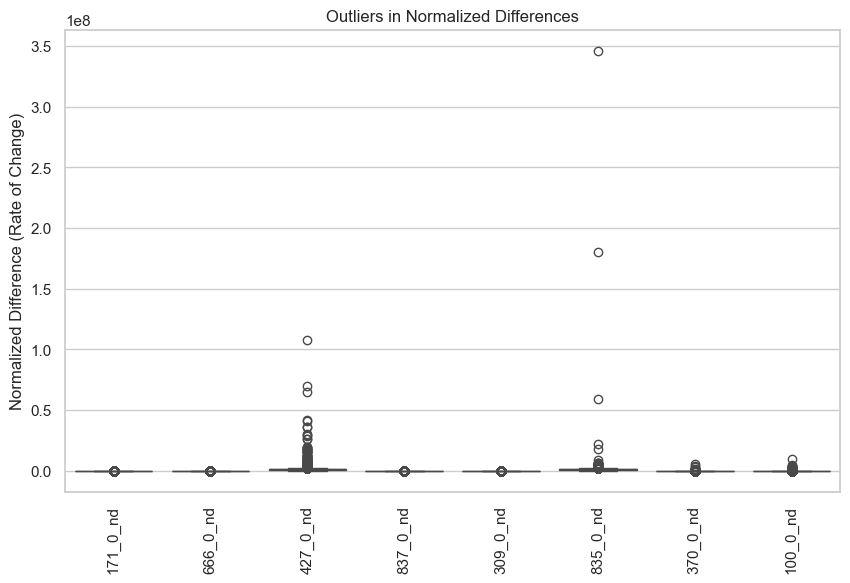

In [80]:
# Outlier Detection in normalized differences (z-score > 3)
# Columns for normalized differences
nd_cols = [c + "_nd" for c in numerical_counters]
# Replace infinities (e.g., divide by zero) with NaN
val_op_norm[nd_cols] = val_op_norm[nd_cols].replace([np.inf, -np.inf], np.nan)

# Compute z-scores for normalized differences
z = val_op_norm[nd_cols].apply(lambda col: zscore(col.fillna(0)))
outlier_mask = (np.abs(z) > 3)
print("Outlier counts per normalized-diff variable:\n", outlier_mask.sum())

plt.figure(figsize=(10, 6))
sns.boxplot(data=val_op_norm[nd_cols])
plt.title("Outliers in Normalized Differences")
plt.ylabel("Normalized Difference (Rate of Change)")
plt.xticks(rotation=90)
plt.show()

          171_0_nd  666_0_nd  427_0_nd  837_0_nd  309_0_nd  835_0_nd  \
171_0_nd  1.000000  0.444501  0.766443  0.300198  0.098544  0.452234   
666_0_nd  0.444501  1.000000  0.368144  0.582482  0.187874  0.617697   
427_0_nd  0.766443  0.368144  1.000000  0.254048  0.090007  0.384286   
837_0_nd  0.300198  0.582482  0.254048  1.000000  0.503240  0.232809   
309_0_nd  0.098544  0.187874  0.090007  0.503240  1.000000  0.071215   
835_0_nd  0.452234  0.617697  0.384286  0.232809  0.071215  1.000000   
370_0_nd -0.002449  0.157402  0.197022  0.088766  0.033972  0.183365   
100_0_nd  0.193021  0.181010  0.474896  0.129304  0.064406  0.258198   

          370_0_nd  100_0_nd  
171_0_nd -0.002449  0.193021  
666_0_nd  0.157402  0.181010  
427_0_nd  0.197022  0.474896  
837_0_nd  0.088766  0.129304  
309_0_nd  0.033972  0.064406  
835_0_nd  0.183365  0.258198  
370_0_nd  1.000000  0.214047  
100_0_nd  0.214047  1.000000  


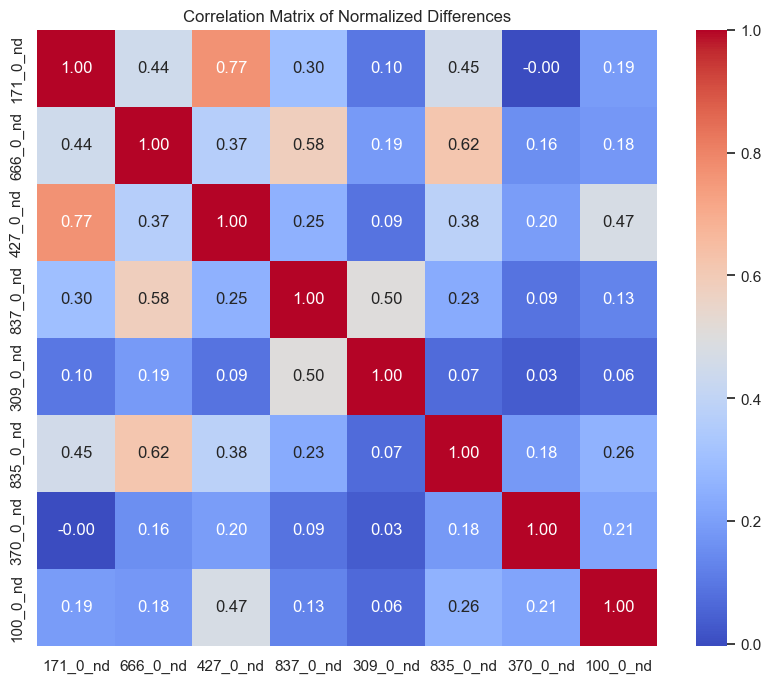

In [81]:
# Step 5: Correlation Matrix for normalized differences
corr = val_op_norm[nd_cols].corr()
print(corr)

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix of Normalized Differences")
plt.show()

In [82]:
corr

171_0_nd  666_0_nd  427_0_nd  837_0_nd  309_0_nd  835_0_nd  \
171_0_nd  1.000000  0.444501  0.766443  0.300198  0.098544  0.452234   
666_0_nd  0.444501  1.000000  0.368144  0.582482  0.187874  0.617697   
427_0_nd  0.766443  0.368144  1.000000  0.254048  0.090007  0.384286   
837_0_nd  0.300198  0.582482  0.254048  1.000000  0.503240  0.232809   
309_0_nd  0.098544  0.187874  0.090007  0.503240  1.000000  0.071215   
835_0_nd  0.452234  0.617697  0.384286  0.232809  0.071215  1.000000   
370_0_nd -0.002449  0.157402  0.197022  0.088766  0.033972  0.183365   
100_0_nd  0.193021  0.181010  0.474896  0.129304  0.064406  0.258198   

          370_0_nd  100_0_nd  
171_0_nd -0.002449  0.193021  
666_0_nd  0.157402  0.181010  
427_0_nd  0.197022  0.474896  
837_0_nd  0.088766  0.129304  
309_0_nd  0.033972  0.064406  
835_0_nd  0.183365  0.258198  
370_0_nd  1.000000  0.214047  
100_0_nd  0.214047  1.000000

In [83]:
# Compare “last-step” normalized diffs (healthy vs fault)
# 1) Get last observation per vehicle
last = (val_op_norm
        .sort_values(["vehicle_id", "time_step"])
        .groupby("vehicle_id")
        .last()
        .reset_index())

# 2) Merge with repair information
cmp = last[["vehicle_id"] + nd_cols].merge(val_rep, on="vehicle_id")

# 3) Split and average
healthy = cmp[cmp["class_label"] == 0][nd_cols].mean()
faulty  = cmp[cmp["class_label"] == 1][nd_cols].mean()

comparison = pd.DataFrame({"healthy_mean": healthy, "faulty_mean": faulty})
print(comparison)

          healthy_mean   faulty_mean
171_0_nd  2.136690e+04  2.718502e+04
666_0_nd  1.182059e+03  1.675311e+03
427_0_nd  9.547118e+05  1.190377e+06
837_0_nd  3.021560e+02  6.585709e+02
309_0_nd  4.223337e+01  1.169017e+02
835_0_nd  1.018263e+06  1.254013e+06
370_0_nd  1.418852e+04  1.592691e+04
100_0_nd  7.674112e+04  8.712039e+04


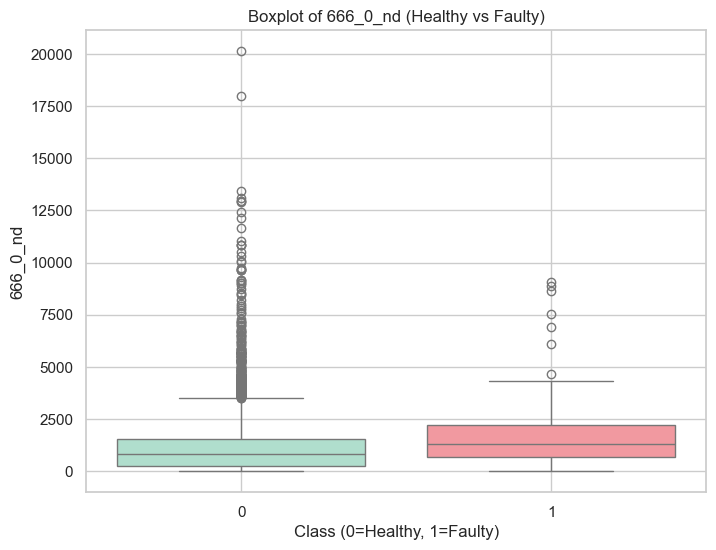

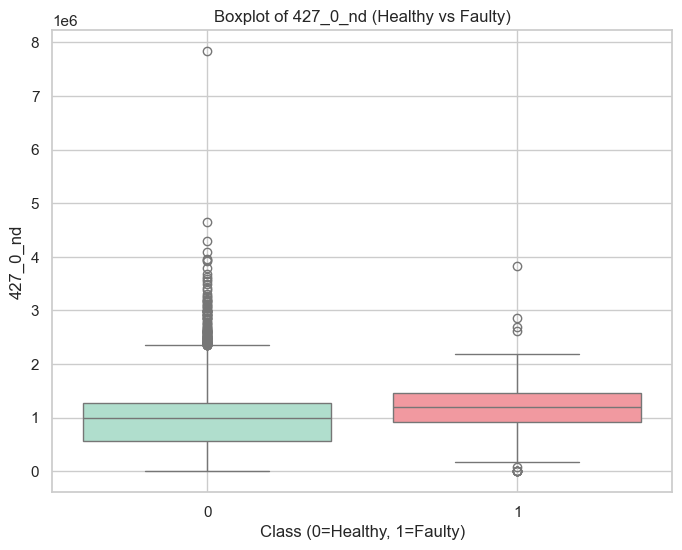

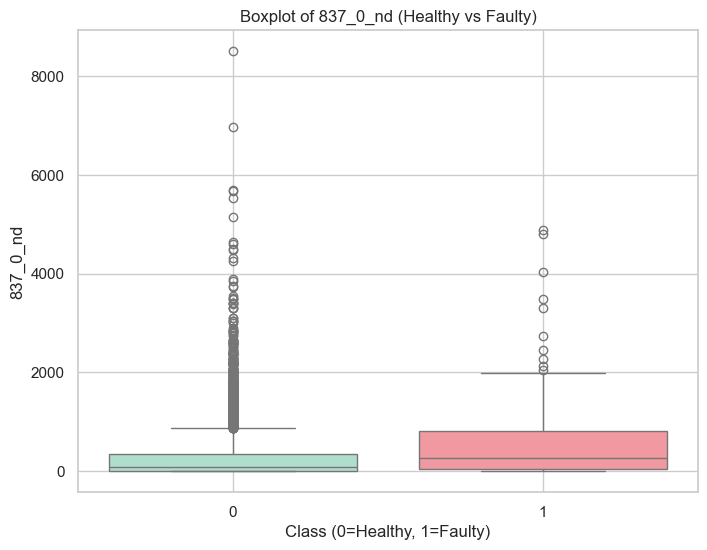

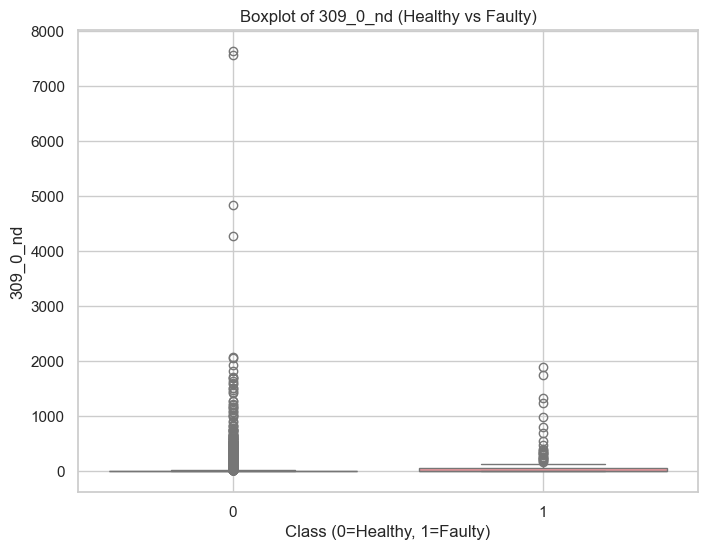

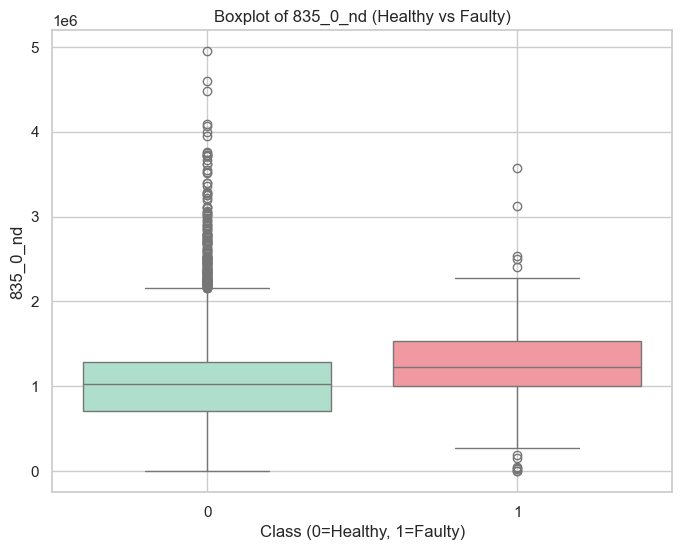

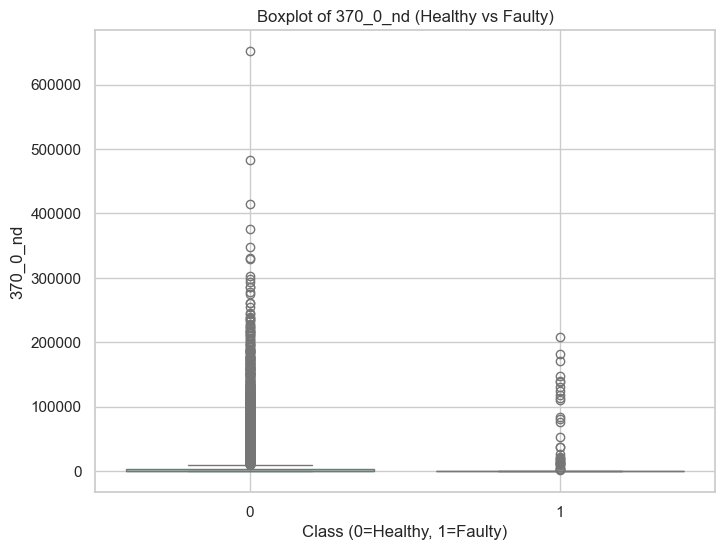

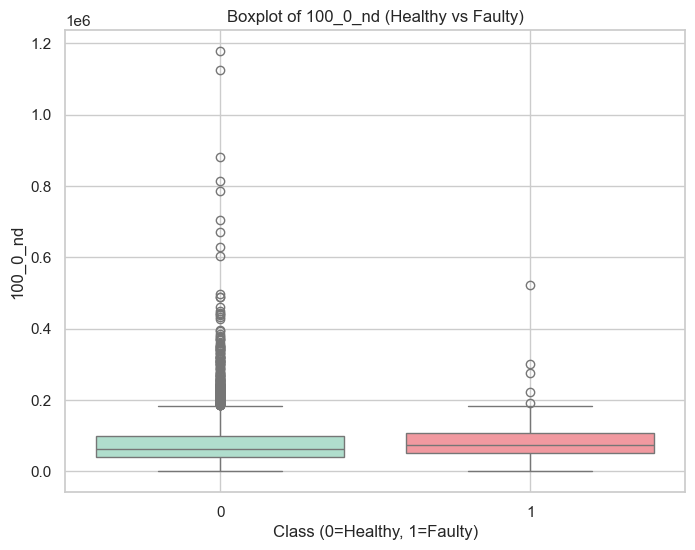

In [84]:
# Melt the dataframe into a long format, easier for seaborn
cmp_melted = cmp.melt(id_vars=["vehicle_id", "class_label"],
                      value_vars=nd_cols,
                      var_name="Sensor",
                      value_name="Normalized_Diff")

# Softer pastel colors
palette = {0: "#a8e6cf", 1: "#ff8b94"}

# For each variable separately
for col in nd_cols:
    plt.figure(figsize=(8, 6))

    sns.boxplot(data=cmp, x="class_label", y=col, hue="class_label",
                palette=palette, dodge=False, legend=False)

    plt.title(f"Boxplot of {col} (Healthy vs Faulty)")
    plt.xlabel("Class (0=Healthy, 1=Faulty)")
    plt.ylabel(col)
    plt.grid(True)
    plt.show()

In [85]:
# Per-vehicle variability (standard deviation) of each rate
veh_stats = (val_op_norm
             .groupby("vehicle_id")[nd_cols]
             .agg(["mean", "std"])
             .sort_index())
veh_stats.head()

171_0_nd                   666_0_nd               \
                    mean           std         mean          std   
vehicle_id                                                         
10          20381.631361   9296.477794  1025.467281   731.228707   
16          12097.761172  15843.772662   673.541809   911.709181   
18          23759.745523  11507.267283   827.508716   547.244984   
23          26508.858464  14797.090797   930.559396   777.875278   
45          29440.659009  14788.462799  2540.771316  2158.324503   

                427_0_nd                   837_0_nd               309_0_nd  \
                    mean            std        mean         std       mean   
vehicle_id                                                                   
10          9.615241e+05  424089.115715  296.878681  203.316754   0.888418   
16          4.974808e+05  649580.029500  132.595837  189.399323   3.090186   
18          9.820810e+05  473614.701702  213.375893  205.059957   6.372555   
23          1.137169e+06  625954.930664  198.689298  222.408938  12.194598   
45          1.271254e+06  622415.383053  767.432237  581.136144   4.575294   

                           835_0_nd                 370_0_nd            \
                  std          mean            std      mean       std   
vehicle_id                                                               
10           2.423700  8.572018e+05  380656.184555  0.000000  0.000000   
16           5.087040  4.602283e+05  572838.353348  0.000000  0.000000   
18          12.546246  9.213922e+05  434271.944578  0.000000  0.000000   
23          33.979529  1.059202e+06  608559.859204  0.000000  0.000000   
45           9.351606  1.189652e+06  561898.626336  0.191388  0.588741   

                100_0_nd                
                    mean           std  
vehicle_id                              
10          34560.128117  17020.296124  
16          24415.808425  19659.326180  
18          50787.249092  26281.670994  
23          65238.598251  37866.979929  
45          63469.285812  52507.874449

In [86]:
# Find per-vehicle constant features
nunique_per_vehicle = (val_op_norm
                       .groupby("vehicle_id")[nd_cols]
                       .nunique())

# If a sensor has only 1 unique value for a vehicle, it's constant for that vehicle
constant_mask = (nunique_per_vehicle == 1)

# Summarize:
constant_summary = constant_mask.sum(axis=0)

print("Number of vehicles where each sensor is constant:\n", constant_summary)

# List sensors that are constant across *all* vehicles
fully_constant_sensors = constant_summary[constant_summary == constant_mask.shape[0]].index.tolist()
print("\nSensors constant across all vehicles:", fully_constant_sensors)

Number of vehicles where each sensor is constant:
 171_0_nd       5
666_0_nd       9
427_0_nd       7
837_0_nd     130
309_0_nd     536
835_0_nd       5
370_0_nd    3217
100_0_nd       7
dtype: int64

Sensors constant across all vehicles: []


In [87]:
# Check the original 370_0 variable
nunique_original_370 = (val_op_num
                        .groupby("vehicle_id")["370_0"]
                        .nunique())

# How many vehicles have constant original 370_0?
constant_vehicles_370 = (nunique_original_370 == 1)

print(f"Number of vehicles with constant original 370_0: {constant_vehicles_370.sum()} / {nunique_original_370.shape[0]} vehicles")

# Optional: list vehicle IDs where 370_0 is constant
constant_vehicle_ids = constant_vehicles_370[constant_vehicles_370].index.tolist()
print("\nVehicles with constant 370_0:", constant_vehicle_ids[:10], "...")

Number of vehicles with constant original 370_0: 3220 / 5046 vehicles

Vehicles with constant 370_0: [10, 16, 18, 23, 51, 58, 85, 101, 104, 119] ...


In [88]:
val_op_norm

vehicle_id  time_step      171_0_nd     666_0_nd      427_0_nd  \
0               10        3.0           NaN          NaN           NaN   
1               10        7.4  18300.000000  2959.090909  1.014204e+06   
2               10        8.0  28175.000000  4800.000000  1.377437e+06   
3               10       12.0  10886.250000  1167.000000  4.895410e+05   
4               10       12.2     75.000000     0.000000  0.000000e+00   
...            ...        ...           ...          ...           ...   
196222       33625       67.8  22545.000000    38.000000  9.955703e+05   
196223       33625       73.8  21027.500000    34.000000  9.376813e+05   
196224       33625       77.4  19941.666667    10.000000  9.114231e+05   
196225       33625       83.4  11072.500000     0.000000  4.804692e+05   
196226       33625       89.4  19800.000000     2.000000  8.742023e+05   

          837_0_nd  309_0_nd      835_0_nd  370_0_nd      100_0_nd  
0              NaN       NaN           NaN       NaN           NaN  
1       729.545455      0.00  1.013312e+06       0.0  75233.863636  
2       950.000000      0.00  1.284930e+06       0.0  69560.000000  
3       547.500000      1.75  4.569210e+05       0.0  24061.000000  
4         0.000000      0.00  0.000000e+00       0.0      5.000000  
...            ...       ...           ...       ...           ...  
196222    0.000000      0.00  8.928388e+05       0.0  35532.166667  
196223    0.000000      0.00  8.397272e+05       0.0  33104.666667  
196224    0.000000      0.00  8.132819e+05       0.0  31030.000000  
196225    0.000000      0.00  4.294693e+05       0.0  16644.833333  
196226    0.000000      0.00  7.744660e+05       0.0  27600.666667  

[196227 rows x 10 columns]

In [89]:
val_op_norm = val_op_norm.drop(columns = ["370_0_nd", "835_0_nd"])
val_op_norm

vehicle_id  time_step      171_0_nd     666_0_nd      427_0_nd  \
0               10        3.0           NaN          NaN           NaN   
1               10        7.4  18300.000000  2959.090909  1.014204e+06   
2               10        8.0  28175.000000  4800.000000  1.377437e+06   
3               10       12.0  10886.250000  1167.000000  4.895410e+05   
4               10       12.2     75.000000     0.000000  0.000000e+00   
...            ...        ...           ...          ...           ...   
196222       33625       67.8  22545.000000    38.000000  9.955703e+05   
196223       33625       73.8  21027.500000    34.000000  9.376813e+05   
196224       33625       77.4  19941.666667    10.000000  9.114231e+05   
196225       33625       83.4  11072.500000     0.000000  4.804692e+05   
196226       33625       89.4  19800.000000     2.000000  8.742023e+05   

          837_0_nd  309_0_nd      100_0_nd  
0              NaN       NaN           NaN  
1       729.545455      0.00  75233.863636  
2       950.000000      0.00  69560.000000  
3       547.500000      1.75  24061.000000  
4         0.000000      0.00      5.000000  
...            ...       ...           ...  
196222    0.000000      0.00  35532.166667  
196223    0.000000      0.00  33104.666667  
196224    0.000000      0.00  31030.000000  
196225    0.000000      0.00  16644.833333  
196226    0.000000      0.00  27600.666667  

[196227 rows x 8 columns]

In [90]:
val_op_norm.columns

Index(['vehicle_id', 'time_step', '171_0_nd', '666_0_nd', '427_0_nd',
       '837_0_nd', '309_0_nd', '100_0_nd'],
      dtype='object')

In [91]:
# Remove "_nd" from column names, except for "vehicle_id" and "time_step"
val_op_norm_clean = val_op_norm.rename(
    columns={col: col.replace("_nd", "") for col in val_op_norm.columns if col not in ["vehicle_id", "time_step"]}
)
val_op_norm_clean

vehicle_id  time_step         171_0        666_0         427_0  \
0               10        3.0           NaN          NaN           NaN   
1               10        7.4  18300.000000  2959.090909  1.014204e+06   
2               10        8.0  28175.000000  4800.000000  1.377437e+06   
3               10       12.0  10886.250000  1167.000000  4.895410e+05   
4               10       12.2     75.000000     0.000000  0.000000e+00   
...            ...        ...           ...          ...           ...   
196222       33625       67.8  22545.000000    38.000000  9.955703e+05   
196223       33625       73.8  21027.500000    34.000000  9.376813e+05   
196224       33625       77.4  19941.666667    10.000000  9.114231e+05   
196225       33625       83.4  11072.500000     0.000000  4.804692e+05   
196226       33625       89.4  19800.000000     2.000000  8.742023e+05   

             837_0  309_0         100_0  
0              NaN    NaN           NaN  
1       729.545455   0.00  75233.863636  
2       950.000000   0.00  69560.000000  
3       547.500000   1.75  24061.000000  
4         0.000000   0.00      5.000000  
...            ...    ...           ...  
196222    0.000000   0.00  35532.166667  
196223    0.000000   0.00  33104.666667  
196224    0.000000   0.00  31030.000000  
196225    0.000000   0.00  16644.833333  
196226    0.000000   0.00  27600.666667  

[196227 rows x 8 columns]

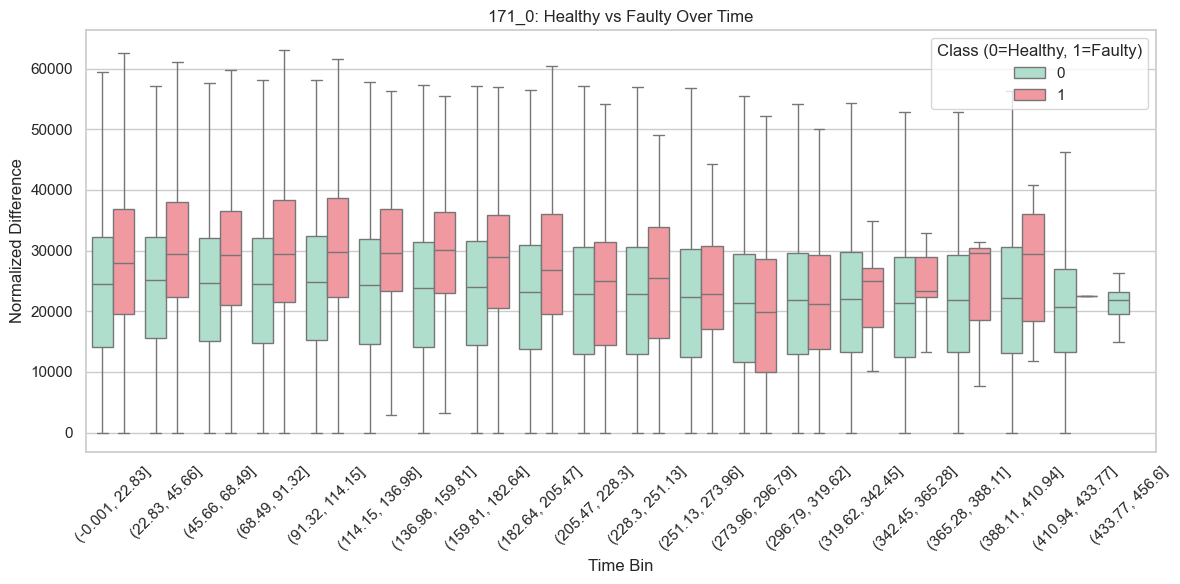

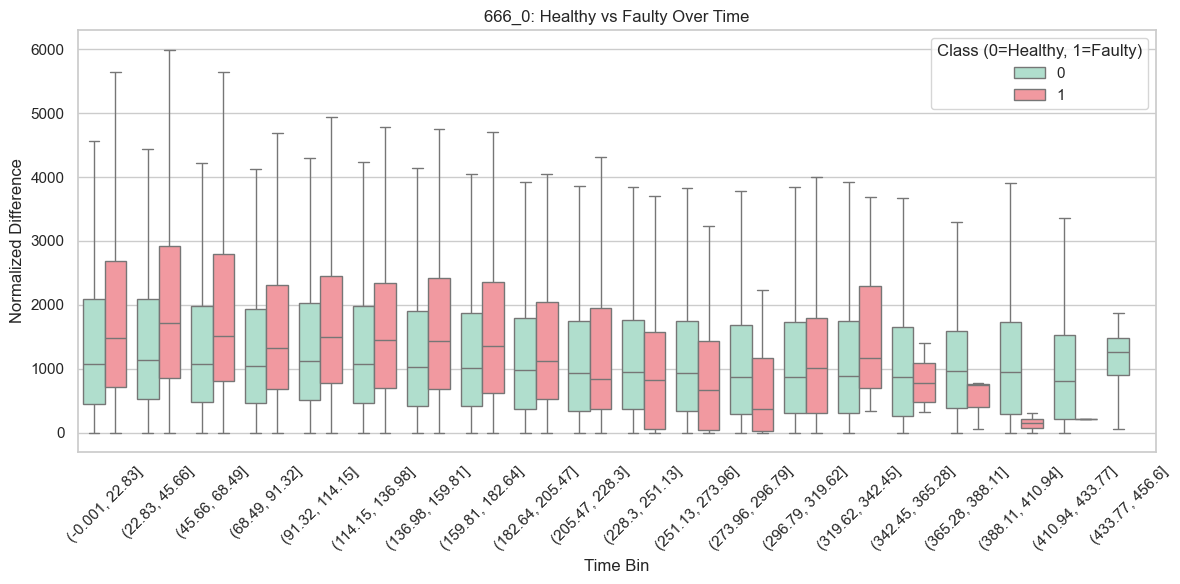

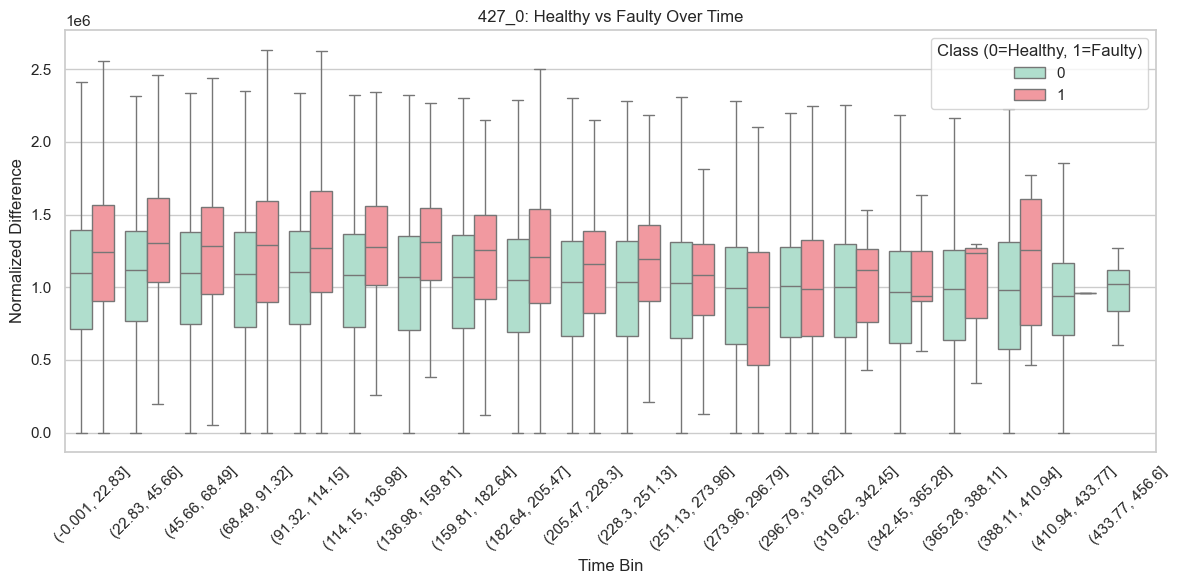

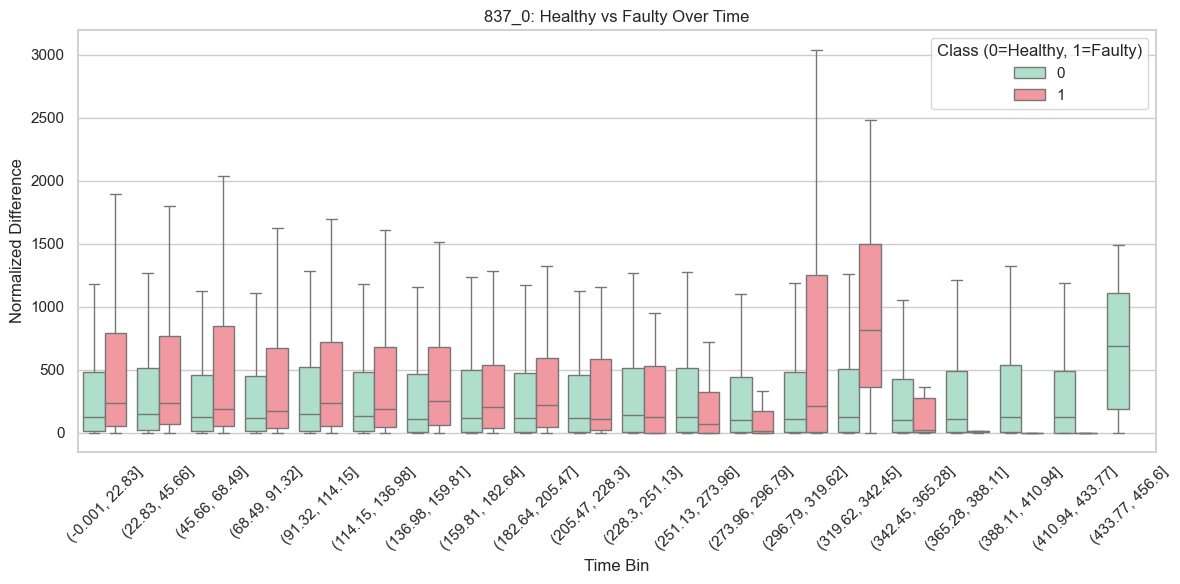

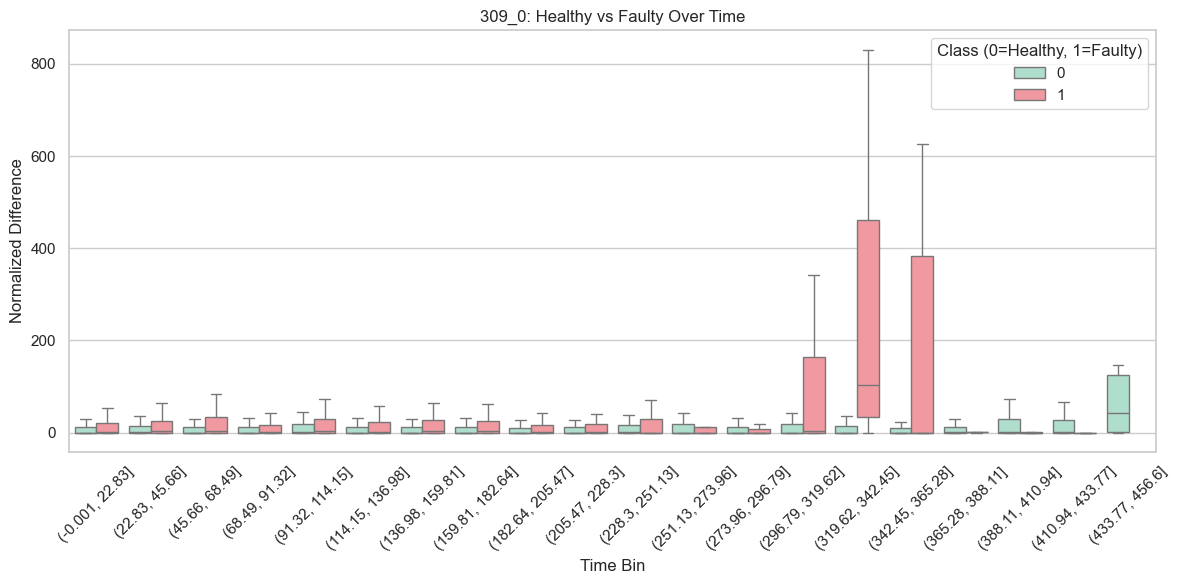

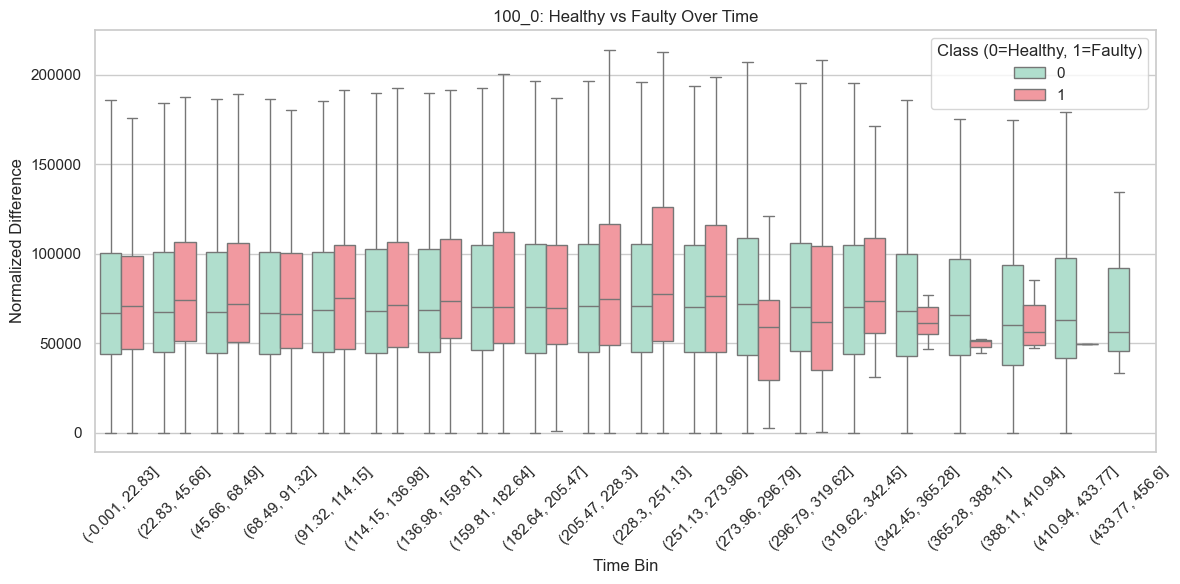

In [92]:
# 1) Copy so we don't touch clean DataFrame
analysis_df = val_op_norm_clean.copy()

# 2) Merge in the class label (0=healthy, 1=faulty)
analysis_df = analysis_df.merge(
    val_rep.rename(columns={'in_study_repair':'class_label'}),
    on='vehicle_id'
)

# 3) Identify normalized-diff columns
nd_cols = [c for c in analysis_df.columns
           if c not in ['vehicle_id','time_step','class_label']]

# 4) Create time bins
n_bins = 20
tmin, tmax = analysis_df['time_step'].min(), analysis_df['time_step'].max()
bins = np.linspace(tmin, tmax, n_bins+1)
analysis_df['time_bin'] = pd.cut(
    analysis_df['time_step'], bins=bins, include_lowest=True
)

# 5) Plot each sensor
palette = {0: '#a8e6cf', 1: '#ff8b94'}
for col in nd_cols:
    plt.figure(figsize=(12,6))
    sns.boxplot(
        data=analysis_df,
        x='time_bin', y=col, hue='class_label',
        palette=palette, dodge=True, showfliers=False
    )
    plt.title(f"{col}: Healthy vs Faulty Over Time")
    plt.xlabel("Time Bin")
    plt.ylabel("Normalized Difference")
    plt.xticks(rotation=45)
    plt.legend(title='Class (0=Healthy, 1=Faulty)')
    plt.tight_layout()
    plt.show()

#### Histogram Variables

In [93]:
# Histogram definitions
histogram_variables = {
    "167": 10,
    "272": 10,
    "291": 11,
    "158": 10,
    "459": 20,
    "397": 36
}

# Build a dict of bin‐column lists for easy reuse
hist_bins = {
    prefix: [f"{prefix}_{i}" for i in range(bins)]
    for prefix, bins in histogram_variables.items()
}

# Define histogram prefixes (this was missing)
histogram_prefixes = list(histogram_variables.keys())

In [94]:
# Check if NaNs appear jointly in histogram attributes
def check_joint_nans(df, prefixes):
    for prefix in prefixes:
        # Select all columns that start with the given prefix
        cols = [col for col in df.columns if col.startswith(prefix)]
        if not cols:
            continue  # Skip if no matching columns
        # Check if all bins for a prefix are NaN at the same time
        nan_rows = df[cols].isna().all(axis=1)  # All bins are NaN
        partial_nan_rows = df[cols].isna().any(axis=1) & ~nan_rows  # Some but not all bins are NaN
        if partial_nan_rows.any():
            print(f"Inconsistent NaNs found in histogram {prefix}. Some bins have NaNs while others do not.")
        else:
            print(f"NaNs appear jointly in all bins for histogram {prefix}.")

In [95]:
# Check if NaNs appear in strictly consecutive rows (potential sensor issue)
def check_strict_nan_clustering(df, min_consecutive=5):
    nan_mask = df.isna().any(axis=1)  # True if any column in the row has NaN
    max_streak = 0
    current_streak = 0

    for value in nan_mask:
        if value:  # If the row has NaNs
            current_streak += 1
            max_streak = max(max_streak, current_streak)
        else:
            current_streak = 0  # Reset streak if row has no NaNs

    if max_streak >= min_consecutive:
        print(f"Possible sensor failure detected: NaNs appear in {max_streak} consecutive time steps.")
    else:
        print("No significant consecutive NaNs detected.")

In [96]:
# Run checks
check_joint_nans(val_op, histogram_prefixes)
check_strict_nan_clustering(val_op)

NaNs appear jointly in all bins for histogram 167.
NaNs appear jointly in all bins for histogram 272.
NaNs appear jointly in all bins for histogram 291.
NaNs appear jointly in all bins for histogram 158.
NaNs appear jointly in all bins for histogram 459.
NaNs appear jointly in all bins for histogram 397.
Possible sensor failure detected: NaNs appear in 176 consecutive time steps.


In [97]:
# Joint-NaN summary
per_vehicle_allnan = {}
for prefix, n_bins in histogram_variables.items():
    cols = [f"{prefix}_{i}" for i in range(n_bins)]
    rate = (val_op[cols].isna().all(axis=1)
                  .groupby(val_op['vehicle_id'])
                  .mean() * 100)
    per_vehicle_allnan[prefix] = rate

per_vehicle_allnan_df = pd.DataFrame(per_vehicle_allnan).round(2)
per_vehicle_allnan_df

167  272    291  158    459  397
vehicle_id                                    
10          70.59  0.0   0.00  0.0   0.00  0.0
16          80.00  0.0   0.00  0.0   0.00  0.0
18          98.11  0.0   0.00  0.0   0.00  0.0
23          85.71  0.0   2.86  0.0   0.00  0.0
45           0.00  0.0   0.00  0.0   0.00  0.0
...           ...  ...    ...  ...    ...  ...
33596        0.00  0.0   0.00  0.0   0.00  0.0
33601        0.00  0.0   0.00  0.0   0.00  0.0
33605        0.00  0.0   0.00  0.0   0.00  0.0
33612        0.00  0.0  27.27  0.0  27.27  0.0
33625        0.00  0.0   0.00  0.0   0.00  0.0

[5046 rows x 6 columns]

In [98]:
# Overall joint-NaN rate per histogram
overall_joint_nan = per_vehicle_allnan_df.mean().round(2)
print("Average % of timestamps fully missing, per histogram:")
overall_joint_nan

Average % of timestamps fully missing, per histogram:


167    0.19
272    0.05
291    0.86
158    0.06
459    0.71
397    0.04
dtype: float64

Even though histograms 291 (0,86%) and 459 (0,71%) are the highest, in absolute terms, fewer than 1% of all time-steps are missing. Compared to the dimensionality of the dataset, this is tiny. Therefore, it is possible to safely impute the missing rows (rather than missing the entire vehicle or histogram information).

These conclusions are equal to those retrieved from the train set, so the distribution is similar in both datasets.

In [99]:
all_hist_cols = []
for prefix, n_bins in histogram_variables.items():
    all_hist_cols += [f"{prefix}_{i}" for i in range(n_bins)]
val_op_hist = val_op[['vehicle_id','time_step'] + all_hist_cols].copy()

In [100]:
# ffill/bfill by vehicle
val_op_hist[all_hist_cols] = (
    val_op_hist
    .groupby('vehicle_id')[all_hist_cols]
    .apply(lambda df: df.ffill().bfill())
    .reset_index(level=0, drop=True)
)

In [101]:
# Detect vehicles with *all* NaNs in their histograms
nan_mask = val_op_hist[all_hist_cols].isna().all(axis=1)
vehicles_all_nan = val_op_hist.loc[nan_mask, 'vehicle_id'].unique()
if len(vehicles_all_nan):
    print(f"Vehicles missing all histogram bins: {vehicles_all_nan}")
else:
    print("No vehicle is entirely missing its histogram data.")

No vehicle is entirely missing its histogram data.


In [102]:
# Zero-fill remaining NaNs (small %)
val_op_hist[all_hist_cols] = val_op_hist[all_hist_cols].fillna(0)

In [103]:
# Confirm
assert not val_op_hist[all_hist_cols].isna().any().any(), "Still NaNs left!"
print("All histogram bins are now filled.")

All histogram bins are now filled.


In [104]:
# Confirm
assert not val_op_hist[all_hist_cols].isna().any().any(), "Still NaNs left!"
print("All histogram bins are now filled.")

All histogram bins are now filled.


In [105]:
# Merge bins
merged_bins = 3
for prefix, n_bins in histogram_variables.items():
    cols = [f"{prefix}_{i}" for i in range(n_bins)]
    size = np.ceil(n_bins / merged_bins).astype(int)
    super_cols = []
    for j in range(merged_bins):
        start = j * size
        end = min((j + 1) * size, n_bins)
        group = cols[start:end]
        sc = f"{prefix}_mbin{j}"
        super_cols.append(sc)
        val_op_hist[sc] = val_op_hist[group].sum(axis=1)
    val_op_hist.drop(columns=cols, inplace=True)
    histogram_variables[prefix] = merged_bins  # update to merged count

# Rename merged‐bin columns from "<prefix>_mbin{j}" → "<prefix>_{j}"
for prefix, n_bins in histogram_variables.items():
    rename_map = {f"{prefix}_mbin{i}": f"{prefix}_{i}"
                  for i in range(n_bins)}
    val_op_hist.rename(columns=rename_map, inplace=True)

In [106]:
# Normalize into frequencies (now using the new "<prefix>_{i}" names)
val_hist_freq = val_op_hist[['vehicle_id','time_step']].copy()

for prefix, n_bins in histogram_variables.items():
    cols      = [f"{prefix}_{i}" for i in range(n_bins)]
    freq_cols = [f"{c}_freq"    for c in cols]

    totals = val_op_hist[cols].sum(axis=1).replace(0, np.nan)
    for col, fcol in zip(cols, freq_cols):
        val_hist_freq[fcol] = val_op_hist[col] / totals

    # Uniform fallback for rows with zero total
    mask_zero = totals.isna() | (totals == 0)
    if mask_zero.any():
        val_hist_freq.loc[mask_zero, freq_cols] = 1.0 / n_bins

    val_hist_freq[freq_cols] = val_hist_freq[freq_cols].astype('float64')

# Final check
tol = 1e-8
for prefix, n_bins in histogram_variables.items():
    freq_cols = [f"{prefix}_{i}_freq" for i in range(n_bins)]
    s = val_hist_freq[freq_cols].sum(axis=1)
    max_dev = (s - 1.0).abs().max()
    print(f"{prefix} max deviation: {max_dev:.2e}")
    assert max_dev < tol

167 max deviation: 2.22e-16
272 max deviation: 2.22e-16
291 max deviation: 2.22e-16
158 max deviation: 2.22e-16
459 max deviation: 3.33e-16
397 max deviation: 2.22e-16


In [107]:
# Cell 5 — Compute entropy per histogram (using the renamed freq columns)
for prefix, n_bins in histogram_variables.items():
    # use "<prefix>_<i>_freq"
    freq_cols = [f"{prefix}_{i}_freq" for i in range(n_bins)]
    eps = 1e-9  # to avoid log(0)
    freqs = val_hist_freq[freq_cols].fillna(0).clip(eps)
    ent = freqs.apply(lambda row: stats.entropy(row), axis=1)
    val_hist_freq[f"{prefix}_entropy"] = ent

# Summarize entropy
val_entropy_summary = {
    prefix: {
        'mean': val_hist_freq[f"{prefix}_entropy"].mean(),
        'std':  val_hist_freq[f"{prefix}_entropy"].std(),
        'min':  val_hist_freq[f"{prefix}_entropy"].min(),
        'max':  val_hist_freq[f"{prefix}_entropy"].max(),
    }
    for prefix in histogram_variables
}
entropy_df = pd.DataFrame(val_entropy_summary).T.round(2)
print(entropy_df)

     mean   std   min   max
167  0.45  0.10  0.00  0.76
272  0.44  0.15  0.00  0.69
291  0.88  0.10  0.00  1.10
158  0.61  0.15  0.00  1.04
459  0.87  0.11  0.00  1.10
397  0.80  0.12  0.07  1.08


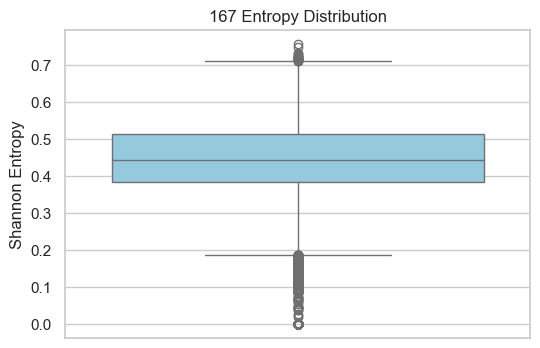

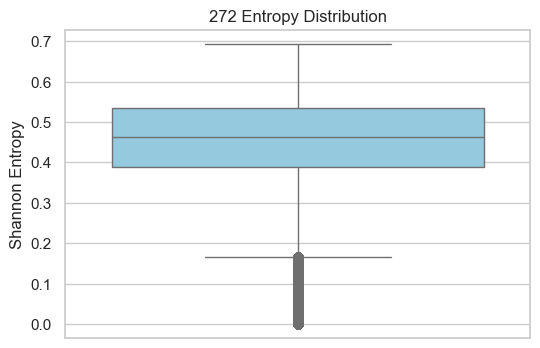

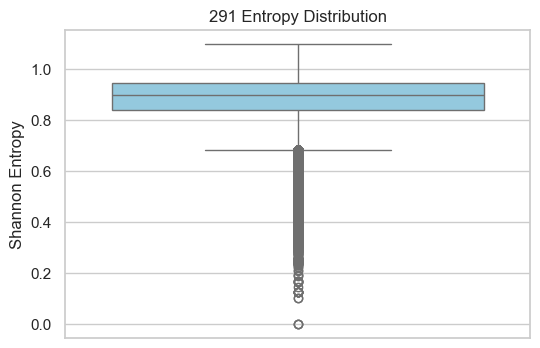

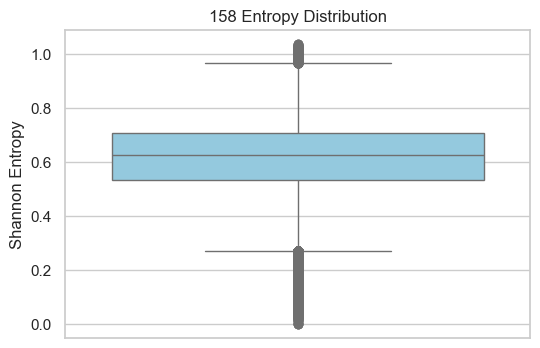

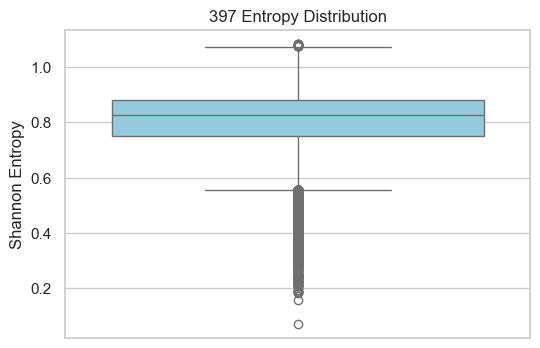

In [108]:
# Boxplots of entropy per histogram
for prefix in histogram_variables:
    plt.figure(figsize=(6,4))
    sns.boxplot(y=val_hist_freq[f"{prefix}_entropy"], color='skyblue')
    plt.title(f"{prefix} Entropy Distribution")
    plt.ylabel("Shannon Entropy")
    plt.show()

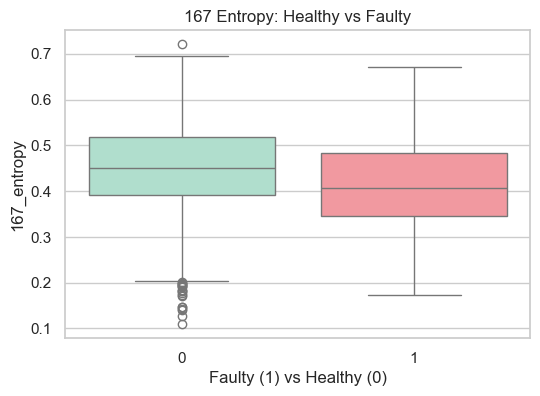

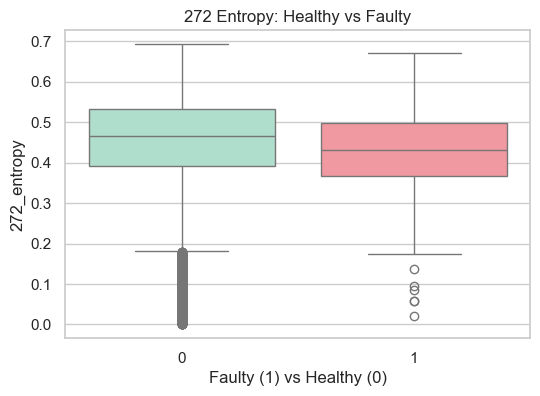

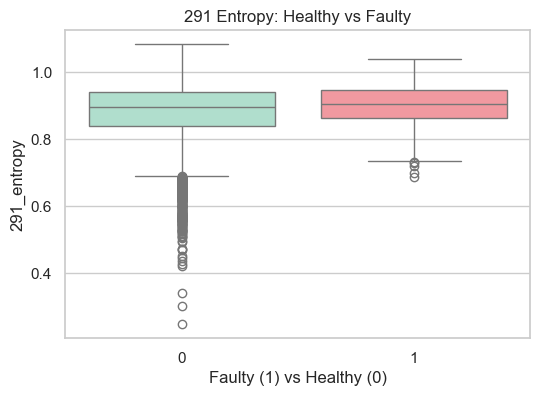

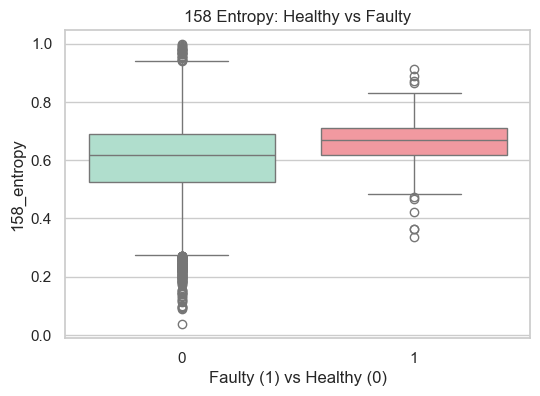

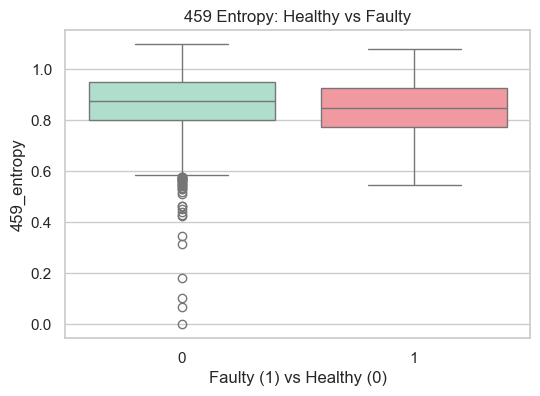

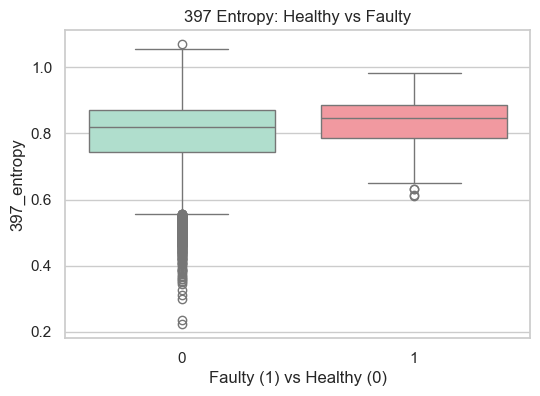

In [109]:
# Relate entropy to failure status
cmp = val_hist_freq[['vehicle_id'] + [f"{p}_entropy" for p in histogram_variables]] \
      .copy().groupby('vehicle_id').mean().reset_index() \
      .merge(val_rep, on='vehicle_id')

for prefix in histogram_variables:
    plt.figure(figsize=(6,4))
    sns.boxplot(data=cmp, x='class_label', y=f"{prefix}_entropy",
                palette={"0":'#a8e6cf',"1":'#ff8b94'})
    plt.title(f"{prefix} Entropy: Healthy vs Faulty")
    plt.xlabel("Faulty (1) vs Healthy (0)")
    plt.show()

In [110]:
val_op_final = val_op_norm_clean.merge(val_hist_freq, on = ["vehicle_id", "time_step"], how = "inner")
val_op_final

vehicle_id  time_step         171_0        666_0         427_0  \
0               10        3.0           NaN          NaN           NaN   
1               10        7.4  18300.000000  2959.090909  1.014204e+06   
2               10        8.0  28175.000000  4800.000000  1.377437e+06   
3               10       12.0  10886.250000  1167.000000  4.895410e+05   
4               10       12.2     75.000000     0.000000  0.000000e+00   
...            ...        ...           ...          ...           ...   
196222       33625       67.8  22545.000000    38.000000  9.955703e+05   
196223       33625       73.8  21027.500000    34.000000  9.376813e+05   
196224       33625       77.4  19941.666667    10.000000  9.114231e+05   
196225       33625       83.4  11072.500000     0.000000  4.804692e+05   
196226       33625       89.4  19800.000000     2.000000  8.742023e+05   

             837_0  309_0         100_0  167_0_freq  167_1_freq  ...  \
0              NaN    NaN           NaN    0.258207    0.740998  ...   
1       729.545455   0.00  75233.863636    0.176088    0.823659  ...   
2       950.000000   0.00  69560.000000    0.166469    0.833305  ...   
3       547.500000   1.75  24061.000000    0.163444    0.835663  ...   
4         0.000000   0.00      5.000000    0.163444    0.835663  ...   
...            ...    ...           ...         ...         ...  ...   
196222    0.000000   0.00  35532.166667    0.277203    0.722797  ...   
196223    0.000000   0.00  33104.666667    0.277956    0.722044  ...   
196224    0.000000   0.00  31030.000000    0.280991    0.719009  ...   
196225    0.000000   0.00  16644.833333    0.282288    0.717712  ...   
196226    0.000000   0.00  27600.666667    0.284682    0.715318  ...   

        459_2_freq  397_0_freq  397_1_freq  397_2_freq  167_entropy  \
0         0.533969    0.609085    0.218026    0.172889     0.577409   
1         0.320381    0.585105    0.198000    0.216895     0.467704   
2         0.314827    0.576216    0.196647    0.227137     0.452323   
3         0.332432    0.561730    0.195927    0.242344     0.452339   
4         0.332455    0.561730    0.195927    0.242344     0.452339   
...            ...         ...         ...         ...          ...   
196222    0.660455    0.671960    0.293304    0.034736     0.590292   
196223    0.649032    0.668191    0.296934    0.034875     0.591013   
196224    0.642630    0.666953    0.297966    0.035082     0.593887   
196225    0.639310    0.663895    0.300750    0.035355     0.595101   
196226    0.630709    0.659413    0.304771    0.035816     0.597321   

        272_entropy  291_entropy  158_entropy  459_entropy  397_entropy  
0          0.575956     0.891033     0.865948     0.921346     0.937505  
1          0.485638     1.066473     0.912989     0.989801     0.965743  
2          0.471861     1.069106     0.926547     0.979485     0.974131  
3          0.465372     1.060190     0.947570     0.968211     0.986830  
4          0.465372     1.060251     0.947570     0.968243     0.986830  
...             ...          ...          ...          ...          ...  
196222     0.597616     0.815089     0.452656     0.850746     0.743605  
196223     0.597872     0.817330     0.451768     0.861896     0.746992  
196224     0.601913     0.820502     0.451556     0.868257     0.748436  
196225     0.604039     0.820423     0.452364     0.870700     0.751463  
196226     0.607724     0.824122     0.453598     0.877661     0.755954  

[196227 rows x 32 columns]

In [111]:
# Final merge into train_op_final
val_op_final = val_op_norm_clean.merge(val_hist_freq, on=["vehicle_id", "time_step"], how="inner")

# Rename frequency columns
freq_cols = [c for c in val_op_final.columns if c.endswith('_freq')]
rename_map = {c: c.replace('_freq', '') for c in freq_cols}
val_op_final.rename(columns=rename_map, inplace=True)

# Final sanity check
print("Remaining entropy cols:", [c for c in val_op_final.columns if 'entropy' in c])
print("Sample histogram cols:", [c for c in val_op_final.columns if c.startswith('167_')][:5])
print("train_op_final shape:", val_op_final.shape)

Remaining entropy cols: ['167_entropy', '272_entropy', '291_entropy', '158_entropy', '459_entropy', '397_entropy']
Sample histogram cols: ['167_0', '167_1', '167_2', '167_entropy']
train_op_final shape: (196227, 32)


In [112]:
val_op_final

vehicle_id  time_step         171_0        666_0         427_0  \
0               10        3.0           NaN          NaN           NaN   
1               10        7.4  18300.000000  2959.090909  1.014204e+06   
2               10        8.0  28175.000000  4800.000000  1.377437e+06   
3               10       12.0  10886.250000  1167.000000  4.895410e+05   
4               10       12.2     75.000000     0.000000  0.000000e+00   
...            ...        ...           ...          ...           ...   
196222       33625       67.8  22545.000000    38.000000  9.955703e+05   
196223       33625       73.8  21027.500000    34.000000  9.376813e+05   
196224       33625       77.4  19941.666667    10.000000  9.114231e+05   
196225       33625       83.4  11072.500000     0.000000  4.804692e+05   
196226       33625       89.4  19800.000000     2.000000  8.742023e+05   

             837_0  309_0         100_0     167_0     167_1  ...     459_2  \
0              NaN    NaN           NaN  0.258207  0.740998  ...  0.533969   
1       729.545455   0.00  75233.863636  0.176088  0.823659  ...  0.320381   
2       950.000000   0.00  69560.000000  0.166469  0.833305  ...  0.314827   
3       547.500000   1.75  24061.000000  0.163444  0.835663  ...  0.332432   
4         0.000000   0.00      5.000000  0.163444  0.835663  ...  0.332455   
...            ...    ...           ...       ...       ...  ...       ...   
196222    0.000000   0.00  35532.166667  0.277203  0.722797  ...  0.660455   
196223    0.000000   0.00  33104.666667  0.277956  0.722044  ...  0.649032   
196224    0.000000   0.00  31030.000000  0.280991  0.719009  ...  0.642630   
196225    0.000000   0.00  16644.833333  0.282288  0.717712  ...  0.639310   
196226    0.000000   0.00  27600.666667  0.284682  0.715318  ...  0.630709   

           397_0     397_1     397_2  167_entropy  272_entropy  291_entropy  \
0       0.609085  0.218026  0.172889     0.577409     0.575956     0.891033   
1       0.585105  0.198000  0.216895     0.467704     0.485638     1.066473   
2       0.576216  0.196647  0.227137     0.452323     0.471861     1.069106   
3       0.561730  0.195927  0.242344     0.452339     0.465372     1.060190   
4       0.561730  0.195927  0.242344     0.452339     0.465372     1.060251   
...          ...       ...       ...          ...          ...          ...   
196222  0.671960  0.293304  0.034736     0.590292     0.597616     0.815089   
196223  0.668191  0.296934  0.034875     0.591013     0.597872     0.817330   
196224  0.666953  0.297966  0.035082     0.593887     0.601913     0.820502   
196225  0.663895  0.300750  0.035355     0.595101     0.604039     0.820423   
196226  0.659413  0.304771  0.035816     0.597321     0.607724     0.824122   

        158_entropy  459_entropy  397_entropy  
0          0.865948     0.921346     0.937505  
1          0.912989     0.989801     0.965743  
2          0.926547     0.979485     0.974131  
3          0.947570     0.968211     0.986830  
4          0.947570     0.968243     0.986830  
...             ...          ...          ...  
196222     0.452656     0.850746     0.743605  
196223     0.451768     0.861896     0.746992  
196224     0.451556     0.868257     0.748436  
196225     0.452364     0.870700     0.751463  
196226     0.453598     0.877661     0.755954  

[196227 rows x 32 columns]

In [113]:
val_op

vehicle_id  time_step      171_0    666_0       427_0   837_0   167_0  \
0               10        3.0    46590.0   3696.0   2038959.0  1450.0     0.0   
1               10        7.4   127110.0  16716.0   6501456.0  4660.0     0.0   
2               10        8.0   144015.0  19596.0   7327918.0  5230.0     0.0   
3               10       12.0   187560.0  24264.0   9286082.0  7420.0  2647.0   
4               10       12.2   187575.0  24264.0   9286082.0  7420.0     NaN   
...            ...        ...        ...      ...         ...     ...     ...   
196222       33625       67.8  1392945.0   2450.0  60748886.0     0.0     0.0   
196223       33625       73.8  1519110.0   2654.0  66374974.0     0.0     0.0   
196224       33625       77.4  1590900.0   2690.0  69656097.0     0.0     0.0   
196225       33625       83.4  1657335.0   2690.0  72538912.0     0.0     0.0   
196226       33625       89.4  1776135.0   2702.0  77784126.0     0.0     0.0   

            167_1       167_2      167_3  ...     397_26   397_27   397_28  \
0        273826.0    339584.0    99834.0  ...   100725.0   8026.0    855.0   
1        635642.0    609742.0   288036.0  ...   295291.0  44312.0   7995.0   
2        654780.0    665756.0   300174.0  ...   335479.0  52203.0   9421.0   
3        831628.0    794332.0   360066.0  ...   463265.0  61399.0  10727.0   
4             NaN         NaN        NaN  ...   463265.0  61400.0  10727.0   
...           ...         ...        ...  ...        ...      ...      ...   
196222  3772792.0  10954147.0  6446205.0  ...  1191176.0  23783.0   1735.0   
196223  4062662.0  11906819.0  7121565.0  ...  1290131.0  26033.0   1915.0   
196224  4256241.0  12550791.0  7621393.0  ...  1356371.0  27594.0   2081.0   
196225  4488515.0  13016809.0  7995291.0  ...  1414632.0  29380.0   2201.0   
196226  4826265.0  13971077.0  8651415.0  ...  1508068.0  34090.0   2486.0   

        397_29   397_30    397_31     397_32    397_33   397_34  397_35  
0         15.0    495.0   91665.0   169125.0   51900.0   9362.0     0.0  
1         75.0   2265.0  414180.0   688891.0  258810.0  63167.0  1005.0  
2         75.0   2415.0  487080.0   812071.0  300735.0  77477.0  1500.0  
3         75.0   2610.0  655620.0  1118116.0  403516.0  99587.0  1591.0  
4         75.0   2611.0  655620.0  1118116.0  403517.0  99588.0  1592.0  
...        ...      ...       ...        ...       ...      ...     ...  
196222    75.0  17827.0  219069.0   609726.0   41630.0   2284.0    60.0  
196223    75.0  20227.0  247374.0   658866.0   44435.0   2480.0    60.0  
196224    75.0  21307.0  263755.0   690606.0   46416.0   2585.0    60.0  
196225    75.0  22462.0  285700.0   716767.0   48952.0   2810.0    60.0  
196226    75.0  24593.0  328900.0   772672.0   53392.0   3336.0    60.0  

[196227 rows x 107 columns]

### Test - Operational Readouts

In [114]:
test_op = pd.read_csv("test_operational_readouts.csv")
test_op

vehicle_id  time_step      171_0    666_0       427_0    837_0  \
0                1        4.4    94410.0   7982.0   3115020.0   2625.0   
1                1        5.0   105405.0   9178.0   3467240.0   3225.0   
2                1        8.2   214440.0  23348.0   7085790.0   8010.0   
3                1        9.8   260190.0  29120.0   8696850.0  12525.0   
4                1       20.6   519780.0  57967.0  17379560.0  32130.0   
...            ...        ...        ...      ...         ...      ...   
198135       33638       59.6  1151970.0  53911.0  37965610.0   5760.0   
198136       33638       65.6  1321905.0  65091.0  43447361.0   6856.0   
198137       33638       69.8  1438665.0  71591.0  47111501.0   7201.0   
198138       33638       70.8  1459155.0  73008.0  47791981.0   7231.0   
198139       33638       71.4  1471830.0  73945.0  48213271.0   7321.0   

         167_0      167_1      167_2      167_3  ...     397_26   397_27  \
0       1304.0   366624.0   232040.0   147104.0  ...    72548.0   9696.0   
1       1305.0   390896.0   252528.0   157824.0  ...    83147.0  12042.0   
2       4897.0   461240.0   378264.0   313016.0  ...   198090.0  26099.0   
3       6513.0   493728.0   455352.0   363984.0  ...   244326.0  32708.0   
4       7617.0   665120.0   818912.0   664784.0  ...   500995.0  61122.0   
...        ...        ...        ...        ...  ...        ...      ...   
198135  2024.0  1060370.0  1621321.0  1296818.0  ...   900593.0  59376.0   
198136  2024.0  1141978.0  1773113.0  1425914.0  ...  1011299.0  69093.0   
198137  2024.0  1166667.0  1862506.0  1502034.0  ...  1086320.0  73748.0   
198138  2024.0  1173795.0  1895626.0  1517987.0  ...  1098011.0  74736.0   
198139  2024.0  1187164.0  1916914.0  1532811.0  ...  1105263.0  75543.0   

         397_28  397_29   397_30    397_31    397_32    397_33   397_34  \
0        1309.0     7.0    399.0   31843.0   89138.0   24101.0   5112.0   
1        1841.0     7.0    455.0   35749.0  106366.0   28168.0   5420.0   
2        4516.0    21.0   1120.0   94017.0  293462.0   85596.0  16655.0   
3        5714.0    49.0   1498.0  118349.0  378176.0  115130.0  24054.0   
4       14247.0   169.0   3788.0  222712.0  741413.0  237274.0  59636.0   
...         ...     ...      ...       ...       ...       ...      ...   
198135   8906.0    70.0  11783.0  386958.0  717951.0  143395.0  17803.0   
198136  10390.0   126.0  13428.0  421160.0  812403.0  170877.0  21681.0   
198137  11454.0   133.0  14184.0  445289.0  880675.0  186809.0  24153.0   
198138  11672.0   133.0  14436.0  449272.0  890349.0  189582.0  24580.0   
198139  11814.0   133.0  14605.0  450637.0  896643.0  191990.0  24867.0   

        397_35  
0          7.0  
1          7.0  
2         14.0  
3         35.0  
4        639.0  
...        ...  
198135   127.0  
198136   141.0  
198137   148.0  
198138   148.0  
198139   162.0  

[198140 rows x 107 columns]

In [115]:
print("Number of duplicate rows:", test_op.duplicated().sum())

Number of duplicate rows: 0


In [116]:
test_op_sorted = test_op.sort_values(["vehicle_id","time_step"])

# Verify if the time step is increasing for each vehicle
time_step_increasing = (test_op_sorted.groupby("vehicle_id")["time_step"].apply(lambda x: (x.diff().dropna() > 0).all()))

# Conclusion
if time_step_increasing.all():
    print("The time step variable is increasing for all vehicles.")
else:
    print("The time step variable is not increasing for all vehicles. \n Vehicles with problems: \n")
    print(time_step_increasing[~time_step_increasing].index().tolist())

The time step variable is increasing for all vehicles.


In [117]:
# Define the dataset variables
histogram_variables = {
    "167": 10,
    "272": 10,
    "291": 11,
    "158": 10,
    "459": 20,
    "397": 36
}

numerical_counters = ["171_0", "666_0", "427_0", "837_0", "309_0", "835_0", "370_0", "100_0"]

# Print results
print("Numerical Counters:", numerical_counters)
print("\nHistogram Variables:")
for var, bins in histogram_variables.items():
    print(f"Variable ID: {var}, Bins: {bins}")

Numerical Counters: ['171_0', '666_0', '427_0', '837_0', '309_0', '835_0', '370_0', '100_0']

Histogram Variables:
Variable ID: 167, Bins: 10
Variable ID: 272, Bins: 10
Variable ID: 291, Bins: 11
Variable ID: 158, Bins: 10
Variable ID: 459, Bins: 20
Variable ID: 397, Bins: 36


#### Numerical Counters

In [118]:
test_op_num = test_op[["vehicle_id", "time_step"] + numerical_counters]
test_op_num

vehicle_id  time_step      171_0    666_0       427_0    837_0  \
0                1        4.4    94410.0   7982.0   3115020.0   2625.0   
1                1        5.0   105405.0   9178.0   3467240.0   3225.0   
2                1        8.2   214440.0  23348.0   7085790.0   8010.0   
3                1        9.8   260190.0  29120.0   8696850.0  12525.0   
4                1       20.6   519780.0  57967.0  17379560.0  32130.0   
...            ...        ...        ...      ...         ...      ...   
198135       33638       59.6  1151970.0  53911.0  37965610.0   5760.0   
198136       33638       65.6  1321905.0  65091.0  43447361.0   6856.0   
198137       33638       69.8  1438665.0  71591.0  47111501.0   7201.0   
198138       33638       70.8  1459155.0  73008.0  47791981.0   7231.0   
198139       33638       71.4  1471830.0  73945.0  48213271.0   7321.0   

         309_0       835_0      370_0      100_0  
0         35.0   4466869.0    23994.0   232410.0  
1         60.0   4943701.0    25893.0   249265.0  
2         80.0   9655430.0    71100.0   387619.0  
3        220.0  11825379.0    87669.0   469672.0  
4       1180.0  23635707.0   191889.0   887810.0  
...        ...         ...        ...        ...  
198135    10.0  51285265.0  1502129.0  1578222.0  
198136    10.0  58171765.0  1502129.0  1743264.0  
198137    10.0  62715097.0  1502129.0  1837236.0  
198138    10.0  63595465.0  1502129.0  1864995.0  
198139    10.0  64146290.0  1502129.0  1882713.0  

[198140 rows x 10 columns]

In [119]:
test_repair = pd.read_csv("test_labels.csv")
test_rep = test_repair[["vehicle_id","class_label"]]
test_rep

vehicle_id  class_label
0              1            0
1              6            0
2              7            0
3              9            0
4             11            0
...          ...          ...
5040       33617            0
5041       33619            0
5042       33632            0
5043       33634            0
5044       33638            0

[5045 rows x 2 columns]

In [120]:
# Map class labels: 0 stays 0, 1/2/3/4 become 1
test_rep["class_label"] = (test_rep["class_label"] != 0).astype(int)
test_rep["class_label"].nunique()

2

In [121]:
test_op_num.isnull().sum()

vehicle_id       0
time_step        0
171_0            0
666_0            8
427_0         1025
837_0            7
309_0            5
835_0            5
370_0         1024
100_0         1025
dtype: int64

In [122]:
sensors = ['666_0','427_0','837_0','309_0','835_0','370_0','100_0']

test_op_num[sensors] = (
    test_op_num
    .groupby('vehicle_id')[sensors]
    .apply(lambda df: df.ffill().bfill())
    .reset_index(level=0, drop=True)
)

In [123]:
test_op_num.isnull().sum()

vehicle_id    0
time_step     0
171_0         0
666_0         0
427_0         0
837_0         0
309_0         0
835_0         0
370_0         0
100_0         0
dtype: int64

In [124]:
# Compute time gaps

test_op_num = test_op_num.sort_values(["vehicle_id", "time_step"]).reset_index(drop=True)
test_op_num["time_diff"] = test_op_num.groupby("vehicle_id")["time_step"].diff()
test_op_num

vehicle_id  time_step      171_0    666_0       427_0    837_0  \
0                1        4.4    94410.0   7982.0   3115020.0   2625.0   
1                1        5.0   105405.0   9178.0   3467240.0   3225.0   
2                1        8.2   214440.0  23348.0   7085790.0   8010.0   
3                1        9.8   260190.0  29120.0   8696850.0  12525.0   
4                1       20.6   519780.0  57967.0  17379560.0  32130.0   
...            ...        ...        ...      ...         ...      ...   
198135       33638       59.6  1151970.0  53911.0  37965610.0   5760.0   
198136       33638       65.6  1321905.0  65091.0  43447361.0   6856.0   
198137       33638       69.8  1438665.0  71591.0  47111501.0   7201.0   
198138       33638       70.8  1459155.0  73008.0  47791981.0   7231.0   
198139       33638       71.4  1471830.0  73945.0  48213271.0   7321.0   

         309_0       835_0      370_0      100_0  time_diff  
0         35.0   4466869.0    23994.0   232410.0        NaN  
1         60.0   4943701.0    25893.0   249265.0        0.6  
2         80.0   9655430.0    71100.0   387619.0        3.2  
3        220.0  11825379.0    87669.0   469672.0        1.6  
4       1180.0  23635707.0   191889.0   887810.0       10.8  
...        ...         ...        ...        ...        ...  
198135    10.0  51285265.0  1502129.0  1578222.0        6.8  
198136    10.0  58171765.0  1502129.0  1743264.0        6.0  
198137    10.0  62715097.0  1502129.0  1837236.0        4.2  
198138    10.0  63595465.0  1502129.0  1864995.0        1.0  
198139    10.0  64146290.0  1502129.0  1882713.0        0.6  

[198140 rows x 11 columns]

In [125]:
# We should have the same number of Missing Values as the same number of trucks.

test_op_num["time_diff"].isnull().sum()

5045

In [126]:
(val_op_num["time_diff"] < 0).sum()

0

The time step is increasing for all trucks (as previously concluded).

---

Let"s now verify if the monotonicity is verified by the numerical counters.

In [127]:
# Detect resets/monotonicity violations

num_diffs = test_op_num.groupby("vehicle_id")[numerical_counters].diff()

# Negative steps per column?
neg_counts = (num_diffs < 0).sum()
print("Number of decreases (potential resets) by counter:\n", neg_counts)

Number of decreases (potential resets) by counter:
 171_0    0
666_0    0
427_0    0
837_0    0
309_0    0
835_0    0
370_0    0
100_0    0
dtype: int64


No decreases/resets in this dataset! We can now move straight to computing the normalized differences, i.e., the rate of change!

In [128]:
test_op_norm = test_op_num.copy()

# Compute normalized differences (i.e., rate of change)
for col in numerical_counters:
    nd = col + "_nd"
    test_op_norm[nd] = test_op_norm.groupby("vehicle_id")[col].diff() / test_op_norm["time_diff"]

# Keep only normalized differences
test_op_norm = test_op_norm[["vehicle_id", "time_step"] + [col + "_nd" for col in numerical_counters]]
test_op_norm

vehicle_id  time_step      171_0_nd     666_0_nd      427_0_nd  \
0                1        4.4           NaN          NaN           NaN   
1                1        5.0  18325.000000  1993.333333  5.870333e+05   
2                1        8.2  34073.437500  4428.125000  1.130797e+06   
3                1        9.8  28593.750000  3607.500000  1.006912e+06   
4                1       20.6  24036.111111  2671.018519  8.039546e+05   
...            ...        ...           ...          ...           ...   
198135       33638       59.6  18401.470588  1749.264706  6.087412e+05   
198136       33638       65.6  28322.500000  1863.333333  9.136252e+05   
198137       33638       69.8  27800.000000  1547.619048  8.724143e+05   
198138       33638       70.8  20490.000000  1417.000000  6.804800e+05   
198139       33638       71.4  21125.000000  1561.666667  7.021500e+05   

           837_0_nd   309_0_nd      835_0_nd    370_0_nd      100_0_nd  
0               NaN        NaN           NaN         NaN           NaN  
1       1000.000000  41.666667  7.947200e+05   3165.0000  28091.666667  
2       1495.312500   6.250000  1.472415e+06  14127.1875  43235.625000  
3       2821.875000  87.500000  1.356218e+06  10355.6250  51283.125000  
4       1815.277778  88.888889  1.093549e+06   9650.0000  38716.481481  
...             ...        ...           ...         ...           ...  
198135   304.411765   0.000000  7.819271e+05      0.0000  22703.823529  
198136   182.666667   0.000000  1.147750e+06      0.0000  27507.000000  
198137    82.142857   0.000000  1.081746e+06      0.0000  22374.285714  
198138    30.000000   0.000000  8.803680e+05      0.0000  27759.000000  
198139   150.000000   0.000000  9.180417e+05      0.0000  29530.000000  

[198140 rows x 10 columns]

Outlier counts per normalized-diff variable:
 171_0_nd    1519
666_0_nd    3241
427_0_nd     123
837_0_nd    4227
309_0_nd    2780
835_0_nd     135
370_0_nd      24
100_0_nd      19
dtype: int64


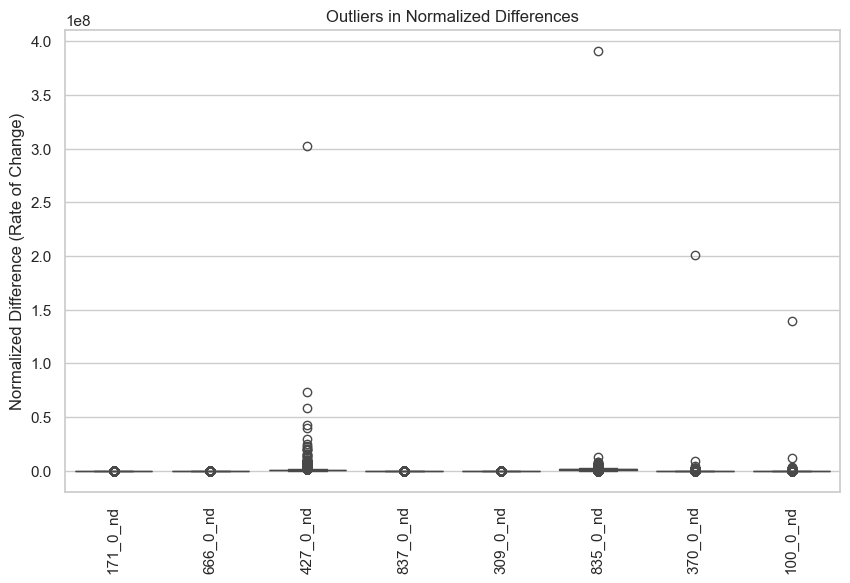

In [129]:
# Outlier Detection in normalized differences (z-score > 3)
# Columns for normalized differences
nd_cols = [c + "_nd" for c in numerical_counters]
# Replace infinities (e.g., divide by zero) with NaN
test_op_norm[nd_cols] = test_op_norm[nd_cols].replace([np.inf, -np.inf], np.nan)

# Compute z-scores for normalized differences
z = test_op_norm[nd_cols].apply(lambda col: zscore(col.fillna(0)))
outlier_mask = (np.abs(z) > 3)
print("Outlier counts per normalized-diff variable:\n", outlier_mask.sum())

plt.figure(figsize=(10, 6))
sns.boxplot(data=test_op_norm[nd_cols])
plt.title("Outliers in Normalized Differences")
plt.ylabel("Normalized Difference (Rate of Change)")
plt.xticks(rotation=90)
plt.show()

          171_0_nd  666_0_nd  427_0_nd  837_0_nd  309_0_nd  835_0_nd  \
171_0_nd  1.000000  0.473241  0.480827  0.294930  0.095978  0.480698   
666_0_nd  0.473241  1.000000  0.516080  0.603015  0.211853  0.568494   
427_0_nd  0.480827  0.516080  1.000000  0.172751  0.061896  0.903676   
837_0_nd  0.294930  0.603015  0.172751  1.000000  0.552596  0.202498   
309_0_nd  0.095978  0.211853  0.061896  0.552596  1.000000  0.081567   
835_0_nd  0.480698  0.568494  0.903676  0.202498  0.081567  1.000000   
370_0_nd -0.010117  0.037300  0.011949  0.030313  0.022410  0.050704   
100_0_nd  0.031916  0.057826  0.107258  0.019993  0.012057  0.113914   

          370_0_nd  100_0_nd  
171_0_nd -0.010117  0.031916  
666_0_nd  0.037300  0.057826  
427_0_nd  0.011949  0.107258  
837_0_nd  0.030313  0.019993  
309_0_nd  0.022410  0.012057  
835_0_nd  0.050704  0.113914  
370_0_nd  1.000000  0.951108  
100_0_nd  0.951108  1.000000  


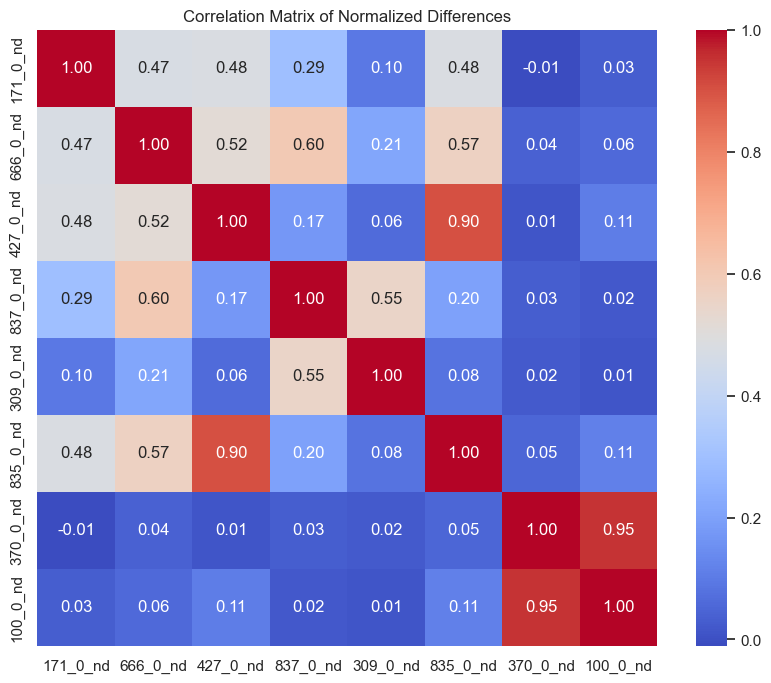

In [130]:
# Step 5: Correlation Matrix for normalized differences
corr = test_op_norm[nd_cols].corr()
print(corr)

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix of Normalized Differences")
plt.show()

In [131]:
corr

171_0_nd  666_0_nd  427_0_nd  837_0_nd  309_0_nd  835_0_nd  \
171_0_nd  1.000000  0.473241  0.480827  0.294930  0.095978  0.480698   
666_0_nd  0.473241  1.000000  0.516080  0.603015  0.211853  0.568494   
427_0_nd  0.480827  0.516080  1.000000  0.172751  0.061896  0.903676   
837_0_nd  0.294930  0.603015  0.172751  1.000000  0.552596  0.202498   
309_0_nd  0.095978  0.211853  0.061896  0.552596  1.000000  0.081567   
835_0_nd  0.480698  0.568494  0.903676  0.202498  0.081567  1.000000   
370_0_nd -0.010117  0.037300  0.011949  0.030313  0.022410  0.050704   
100_0_nd  0.031916  0.057826  0.107258  0.019993  0.012057  0.113914   

          370_0_nd  100_0_nd  
171_0_nd -0.010117  0.031916  
666_0_nd  0.037300  0.057826  
427_0_nd  0.011949  0.107258  
837_0_nd  0.030313  0.019993  
309_0_nd  0.022410  0.012057  
835_0_nd  0.050704  0.113914  
370_0_nd  1.000000  0.951108  
100_0_nd  0.951108  1.000000

In [132]:
# Compare “last-step” normalized diffs (healthy vs fault)
# 1) Get last observation per vehicle
last = (test_op_norm
        .sort_values(["vehicle_id", "time_step"])
        .groupby("vehicle_id")
        .last()
        .reset_index())

# 2) Merge with repair information
cmp = last[["vehicle_id"] + nd_cols].merge(test_rep, on="vehicle_id")

# 3) Split and average
healthy = cmp[cmp["class_label"] == 0][nd_cols].mean()
faulty  = cmp[cmp["class_label"] == 1][nd_cols].mean()

comparison = pd.DataFrame({"healthy_mean": healthy, "faulty_mean": faulty})
print(comparison)

          healthy_mean   faulty_mean
171_0_nd  2.138386e+04  2.902217e+04
666_0_nd  1.271377e+03  2.178247e+03
427_0_nd  7.349900e+05  9.886139e+05
837_0_nd  4.485783e+02  8.710987e+02
309_0_nd  2.779848e+01  6.466664e+01
835_0_nd  1.106726e+06  1.421346e+06
370_0_nd  4.188950e+04  3.959648e+04
100_0_nd  5.754356e+04  6.399841e+04


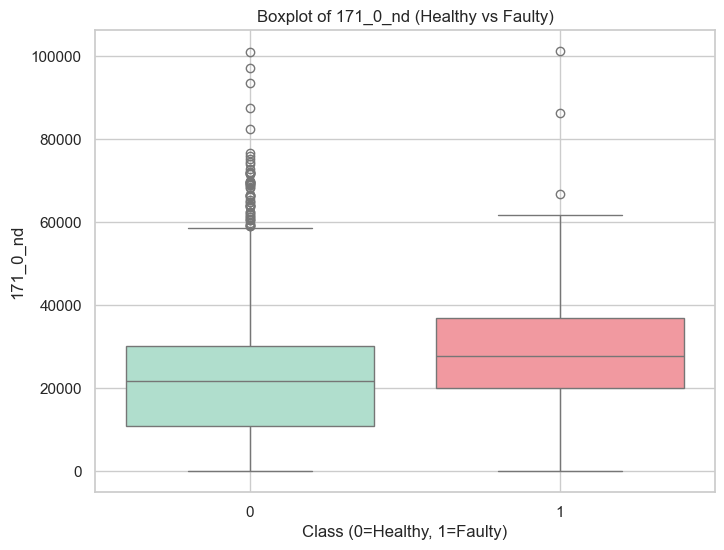

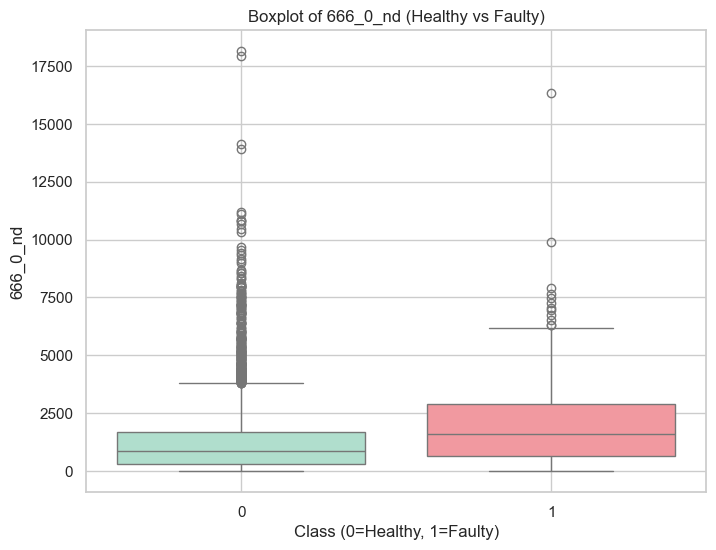

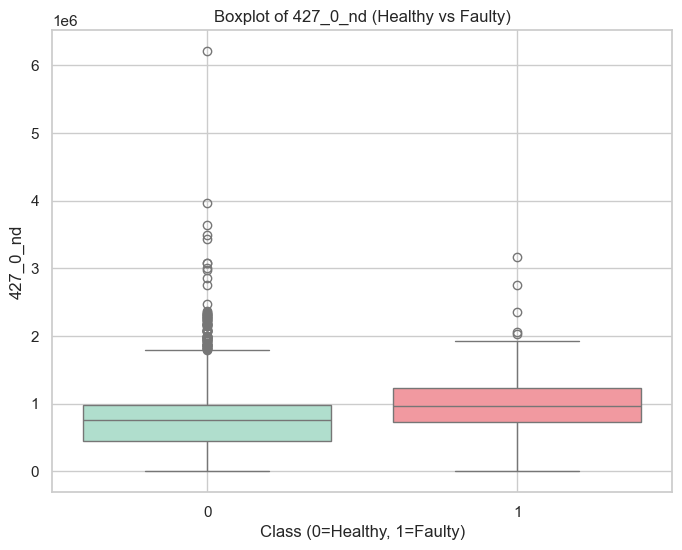

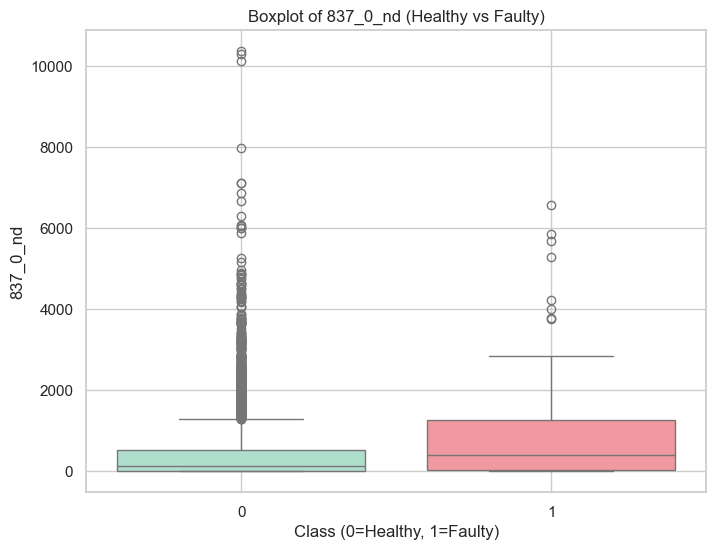

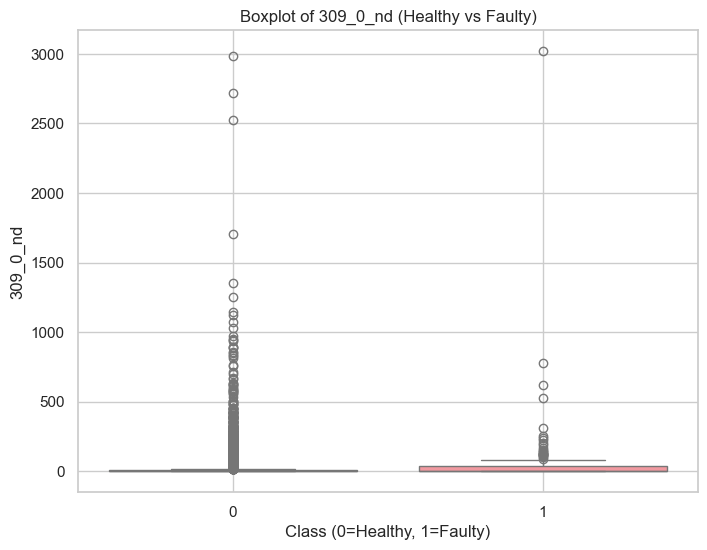

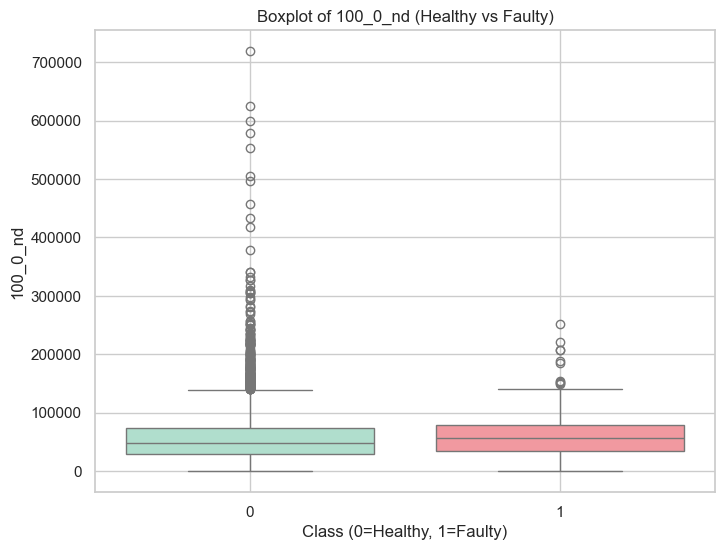

In [133]:
# Melt the dataframe into a long format, easier for seaborn
cmp_melted = cmp.melt(id_vars=["vehicle_id", "class_label"],
                      value_vars=nd_cols,
                      var_name="Sensor",
                      value_name="Normalized_Diff")

# Softer pastel colors
palette = {0: "#a8e6cf", 1: "#ff8b94"}

# For each variable separately
for col in nd_cols:
    plt.figure(figsize=(8, 6))

    sns.boxplot(data=cmp, x="class_label", y=col, hue="class_label",
                palette=palette, dodge=False, legend=False)

    plt.title(f"Boxplot of {col} (Healthy vs Faulty)")
    plt.xlabel("Class (0=Healthy, 1=Faulty)")
    plt.ylabel(col)
    plt.grid(True)
    plt.show()

In [134]:
# Per-vehicle variability (standard deviation) of each rate
veh_stats = (test_op_norm
             .groupby("vehicle_id")[nd_cols]
             .agg(["mean", "std"])
             .sort_index())
veh_stats.head()

171_0_nd                   666_0_nd               \
                    mean           std         mean          std   
vehicle_id                                                         
1           23627.766731  10192.308891  2883.455824  1460.183199   
6           12590.807762  12997.147392  1626.241033  2349.050834   
7           12169.934452   7181.483045  1062.914632   859.782115   
9           18286.653860  12996.011792  2027.578080  1621.971557   
11          18293.072374  11258.861013   621.673057   489.868329   

                 427_0_nd                    837_0_nd                309_0_nd  \
                     mean            std         mean          std       mean   
vehicle_id                                                                      
1           822570.104898  354112.333996  1852.603011   914.221614  69.680047   
6           430855.890384  423480.173885   774.935765  1372.497438  11.639388   
7           429263.175429  247590.518393   434.284578   645.641549   5.162125   
9           612425.025334  427766.828395   719.902104   704.872345   7.791076   
11          569176.855130  341605.850264   152.406026   209.211909   2.345497   

                           835_0_nd                     370_0_nd               \
                  std          mean            std          mean          std   
vehicle_id                                                                      
1           72.081941  1.132948e+06  465478.500846  10692.884320  6075.097272   
6           25.493813  5.986916e+05  692295.249832      0.000000     0.000000   
7           23.863818  7.186451e+05  404636.796412      0.019397     0.173488   
9           11.805543  9.507106e+05  629953.699468      0.000000     0.000000   
11           5.475419  8.000962e+05  487000.921514      0.000000     0.000000   

                100_0_nd                
                    mean           std  
vehicle_id                              
1           47725.746675  20819.150108  
6           55397.466812  73317.854321  
7           65062.533699  35919.944971  
9           66726.430848  48265.659136  
11          44748.714692  27374.355224

In [135]:
# Find per-vehicle constant features
nunique_per_vehicle = (test_op_norm
                       .groupby("vehicle_id")[nd_cols]
                       .nunique())

# If a sensor has only 1 unique value for a vehicle, it"s constant for that vehicle
constant_mask = (nunique_per_vehicle == 1)

# Summarize:
constant_summary = constant_mask.sum(axis=0)

print("Number of vehicles where each sensor is constant:\n", constant_summary)

# Optionally, list sensors that are constant across *all* vehicles
fully_constant_sensors = constant_summary[constant_summary == constant_mask.shape[0]].index.tolist()
print("\nSensors constant across ALL vehicles:", fully_constant_sensors)

Number of vehicles where each sensor is constant:
 171_0_nd       7
666_0_nd       9
427_0_nd       9
837_0_nd     128
309_0_nd     506
835_0_nd       7
370_0_nd    3224
100_0_nd       9
dtype: int64

Sensors constant across ALL vehicles: []


In [136]:
# Check the original 370_0 variable
nunique_original_370 = (test_op_num
                        .groupby("vehicle_id")["370_0"]
                        .nunique())

# How many vehicles have constant original 370_0?
constant_vehicles_370 = (nunique_original_370 == 1)

print(f"Number of vehicles with constant original 370_0: {constant_vehicles_370.sum()} / {nunique_original_370.shape[0]} vehicles")

# Optional: list vehicle IDs where 370_0 is constant
constant_vehicle_ids = constant_vehicles_370[constant_vehicles_370].index.tolist()
print("\nVehicles with constant 370_0:", constant_vehicle_ids[:10], "...")

Number of vehicles with constant original 370_0: 3222 / 5045 vehicles

Vehicles with constant 370_0: [6, 9, 11, 12, 19, 20, 21, 24, 34, 62] ...


In [137]:
test_op_norm

vehicle_id  time_step      171_0_nd     666_0_nd      427_0_nd  \
0                1        4.4           NaN          NaN           NaN   
1                1        5.0  18325.000000  1993.333333  5.870333e+05   
2                1        8.2  34073.437500  4428.125000  1.130797e+06   
3                1        9.8  28593.750000  3607.500000  1.006912e+06   
4                1       20.6  24036.111111  2671.018519  8.039546e+05   
...            ...        ...           ...          ...           ...   
198135       33638       59.6  18401.470588  1749.264706  6.087412e+05   
198136       33638       65.6  28322.500000  1863.333333  9.136252e+05   
198137       33638       69.8  27800.000000  1547.619048  8.724143e+05   
198138       33638       70.8  20490.000000  1417.000000  6.804800e+05   
198139       33638       71.4  21125.000000  1561.666667  7.021500e+05   

           837_0_nd   309_0_nd      835_0_nd    370_0_nd      100_0_nd  
0               NaN        NaN           NaN         NaN           NaN  
1       1000.000000  41.666667  7.947200e+05   3165.0000  28091.666667  
2       1495.312500   6.250000  1.472415e+06  14127.1875  43235.625000  
3       2821.875000  87.500000  1.356218e+06  10355.6250  51283.125000  
4       1815.277778  88.888889  1.093549e+06   9650.0000  38716.481481  
...             ...        ...           ...         ...           ...  
198135   304.411765   0.000000  7.819271e+05      0.0000  22703.823529  
198136   182.666667   0.000000  1.147750e+06      0.0000  27507.000000  
198137    82.142857   0.000000  1.081746e+06      0.0000  22374.285714  
198138    30.000000   0.000000  8.803680e+05      0.0000  27759.000000  
198139   150.000000   0.000000  9.180417e+05      0.0000  29530.000000  

[198140 rows x 10 columns]

In [138]:
test_op_norm = test_op_norm.drop(columns = ["370_0_nd", "835_0_nd"])
test_op_norm

vehicle_id  time_step      171_0_nd     666_0_nd      427_0_nd  \
0                1        4.4           NaN          NaN           NaN   
1                1        5.0  18325.000000  1993.333333  5.870333e+05   
2                1        8.2  34073.437500  4428.125000  1.130797e+06   
3                1        9.8  28593.750000  3607.500000  1.006912e+06   
4                1       20.6  24036.111111  2671.018519  8.039546e+05   
...            ...        ...           ...          ...           ...   
198135       33638       59.6  18401.470588  1749.264706  6.087412e+05   
198136       33638       65.6  28322.500000  1863.333333  9.136252e+05   
198137       33638       69.8  27800.000000  1547.619048  8.724143e+05   
198138       33638       70.8  20490.000000  1417.000000  6.804800e+05   
198139       33638       71.4  21125.000000  1561.666667  7.021500e+05   

           837_0_nd   309_0_nd      100_0_nd  
0               NaN        NaN           NaN  
1       1000.000000  41.666667  28091.666667  
2       1495.312500   6.250000  43235.625000  
3       2821.875000  87.500000  51283.125000  
4       1815.277778  88.888889  38716.481481  
...             ...        ...           ...  
198135   304.411765   0.000000  22703.823529  
198136   182.666667   0.000000  27507.000000  
198137    82.142857   0.000000  22374.285714  
198138    30.000000   0.000000  27759.000000  
198139   150.000000   0.000000  29530.000000  

[198140 rows x 8 columns]

In [139]:
# Remove "_nd" from column names, except for "vehicle_id" and "time_step"
test_op_norm_clean = test_op_norm.rename(
    columns={col: col.replace("_nd", "") for col in test_op_norm.columns if col not in ["vehicle_id", "time_step"]}
)
test_op_norm_clean

vehicle_id  time_step         171_0        666_0         427_0  \
0                1        4.4           NaN          NaN           NaN   
1                1        5.0  18325.000000  1993.333333  5.870333e+05   
2                1        8.2  34073.437500  4428.125000  1.130797e+06   
3                1        9.8  28593.750000  3607.500000  1.006912e+06   
4                1       20.6  24036.111111  2671.018519  8.039546e+05   
...            ...        ...           ...          ...           ...   
198135       33638       59.6  18401.470588  1749.264706  6.087412e+05   
198136       33638       65.6  28322.500000  1863.333333  9.136252e+05   
198137       33638       69.8  27800.000000  1547.619048  8.724143e+05   
198138       33638       70.8  20490.000000  1417.000000  6.804800e+05   
198139       33638       71.4  21125.000000  1561.666667  7.021500e+05   

              837_0      309_0         100_0  
0               NaN        NaN           NaN  
1       1000.000000  41.666667  28091.666667  
2       1495.312500   6.250000  43235.625000  
3       2821.875000  87.500000  51283.125000  
4       1815.277778  88.888889  38716.481481  
...             ...        ...           ...  
198135   304.411765   0.000000  22703.823529  
198136   182.666667   0.000000  27507.000000  
198137    82.142857   0.000000  22374.285714  
198138    30.000000   0.000000  27759.000000  
198139   150.000000   0.000000  29530.000000  

[198140 rows x 8 columns]

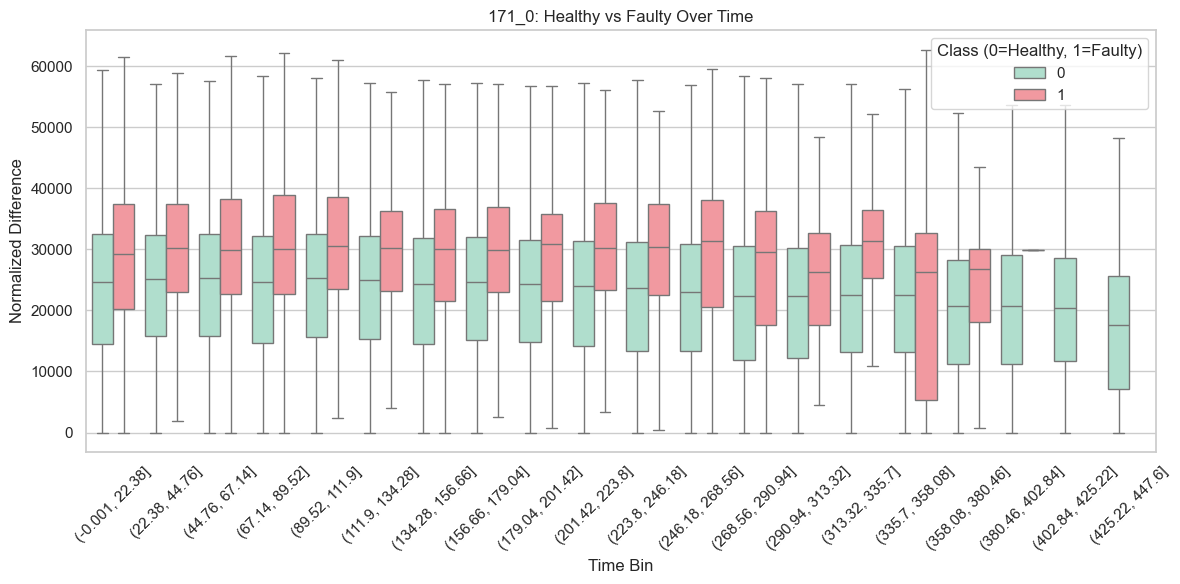

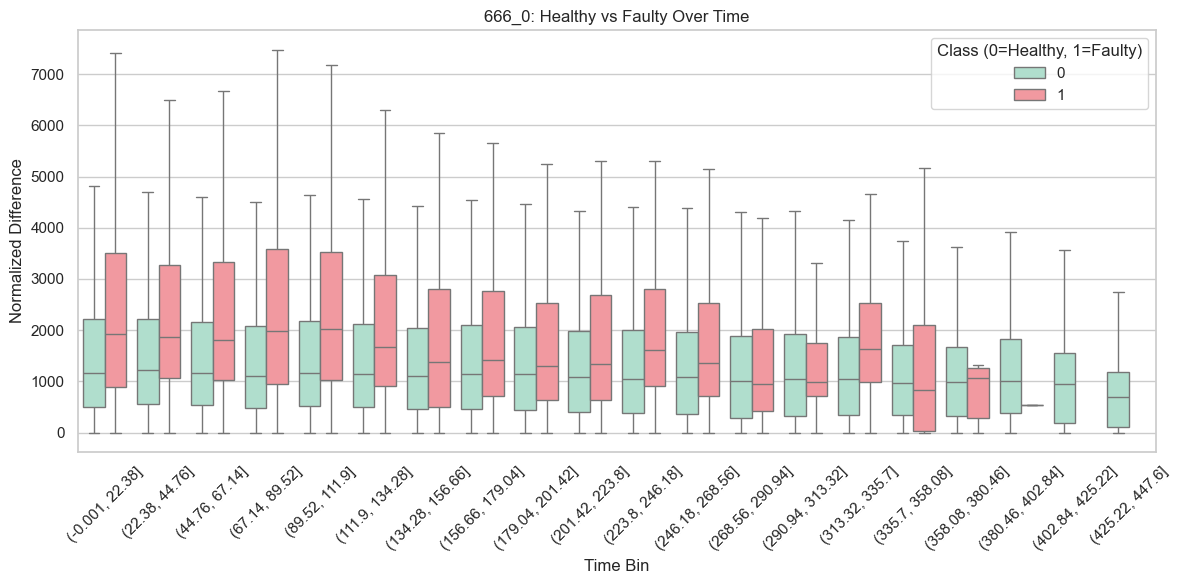

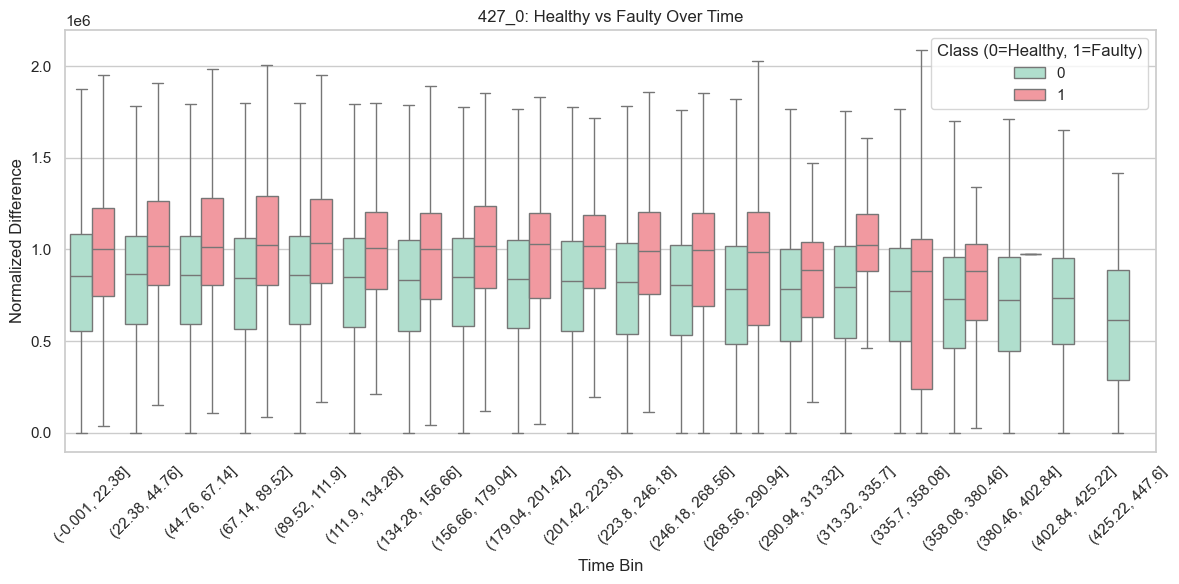

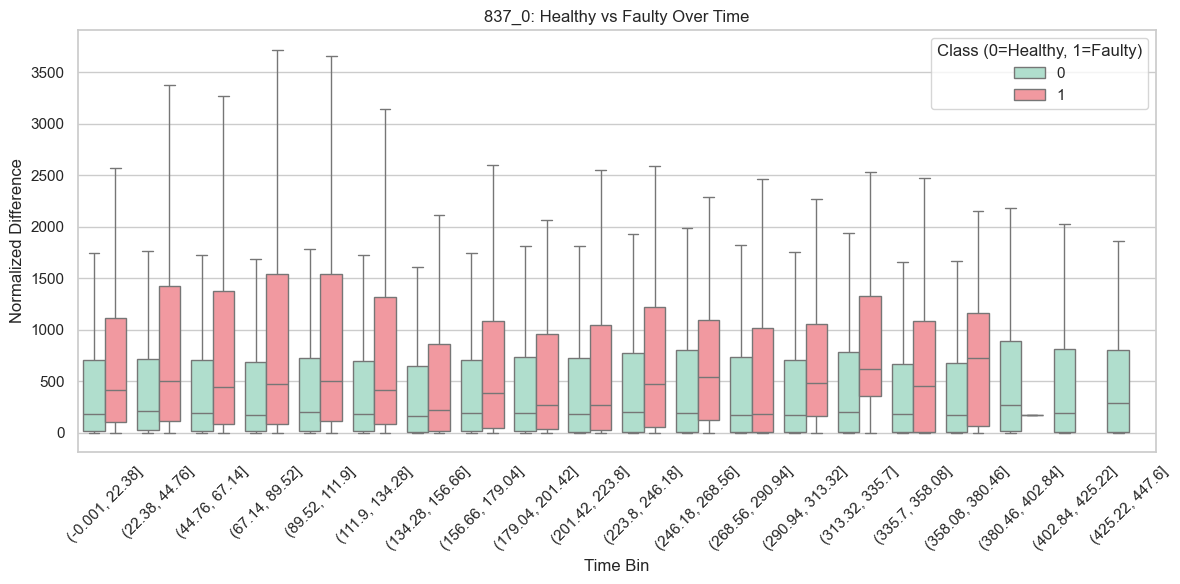

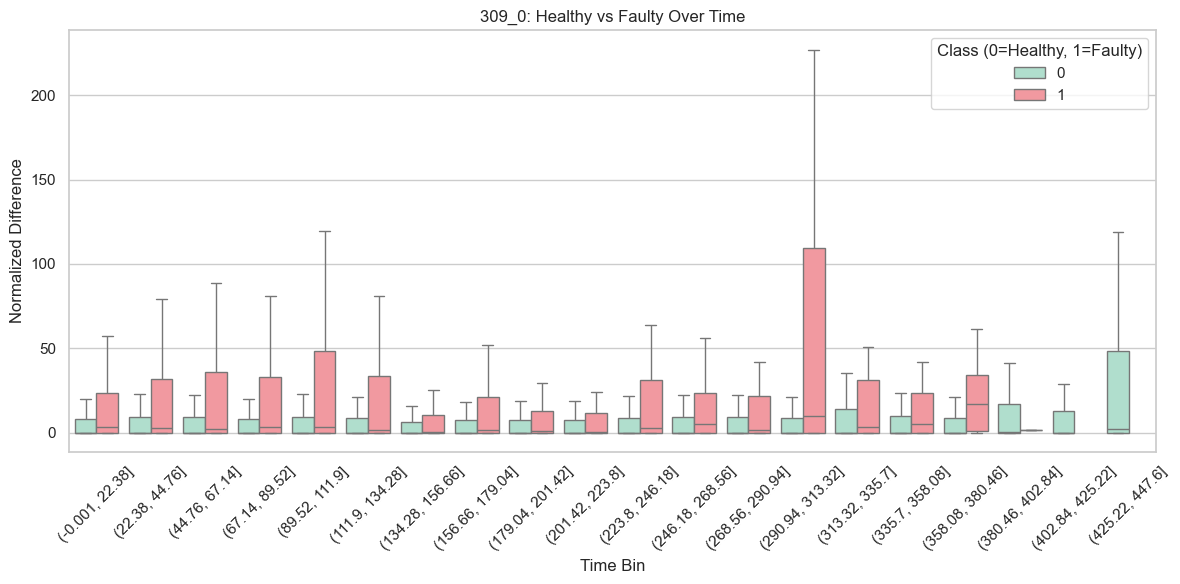

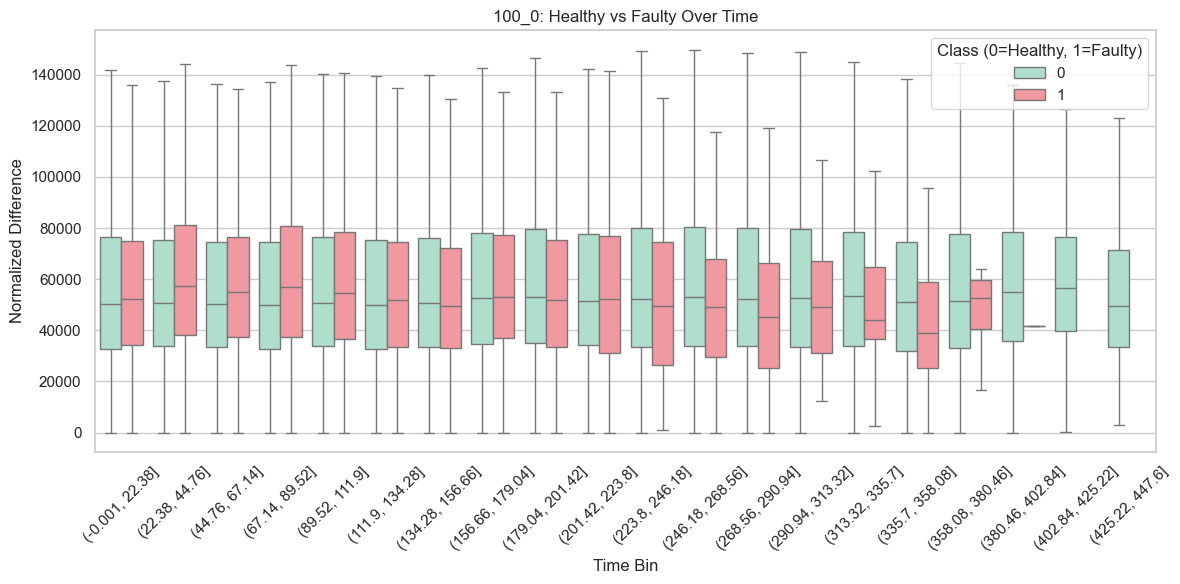

In [140]:
# 1) Copy so we don't touch clean DataFrame
analysis_df = test_op_norm_clean.copy()

# 2) Merge in the class label (0=healthy, 1=faulty)
analysis_df = analysis_df.merge(
    test_rep.rename(columns={'in_study_repair':'class_label'}),
    on='vehicle_id'
)

# 3) Identify normalized-diff columns
nd_cols = [c for c in analysis_df.columns
           if c not in ['vehicle_id','time_step','class_label']]

# 4) Create time bins
n_bins = 20
tmin, tmax = analysis_df['time_step'].min(), analysis_df['time_step'].max()
bins = np.linspace(tmin, tmax, n_bins+1)
analysis_df['time_bin'] = pd.cut(
    analysis_df['time_step'], bins=bins, include_lowest=True
)

# 5) Plot each sensor
palette = {0: '#a8e6cf', 1: '#ff8b94'}
for col in nd_cols:
    plt.figure(figsize=(12,6))
    sns.boxplot(
        data=analysis_df,
        x='time_bin', y=col, hue='class_label',
        palette=palette, dodge=True, showfliers=False
    )
    plt.title(f"{col}: Healthy vs Faulty Over Time")
    plt.xlabel("Time Bin")
    plt.ylabel("Normalized Difference")
    plt.xticks(rotation=45)
    plt.legend(title='Class (0=Healthy, 1=Faulty)')
    plt.tight_layout()
    plt.show()

In [141]:
# Check common vehicle_ids between datasets
op_common_train_val = set(train_op["vehicle_id"]) & set(val_op["vehicle_id"])
op_common_train_test = set(train_op["vehicle_id"]) & set(test_op["vehicle_id"])
op_common_val_test = set(val_op["vehicle_id"]) & set(test_op["vehicle_id"])

# Check if train vehicles are in validation
if op_common_train_val:
    print("Vehicles in train_op that also appear in val_op:")
    print(train_op[train_op["vehicle_id"].isin(val_op["vehicle_id"])])
else:
    print("No trucks are present in both train_op and val_op.")

# Check if train vehicles are in test
if op_common_train_test:
    print("\nVehicles in train_op that also appear in test_op:")
    print(train_op[train_op["vehicle_id"].isin(test_op["vehicle_id"])])
else:
    print("\nNo trucks are present in both train_op and test_op.")

# Check if validation vehicles are in test (if relevant)
if op_common_val_test:
    print("\nVehicles in val_op that also appear in test_op:")
    print(val_op[val_op["vehicle_id"].isin(test_op["vehicle_id"])])
else:
    print("\nNo trucks are present in both val_op and test_op.")

No trucks are present in both train_op and val_op.

No trucks are present in both train_op and test_op.

No trucks are present in both val_op and test_op.


#### Histogram Variables

In [142]:
# Histogram definitions
histogram_variables = {
    "167": 10,
    "272": 10,
    "291": 11,
    "158": 10,
    "459": 20,
    "397": 36
}

# Build a dict of bin‐column lists for easy reuse
hist_bins = {
    prefix: [f"{prefix}_{i}" for i in range(bins)]
    for prefix, bins in histogram_variables.items()
}

# Define histogram prefixes (this was missing)
histogram_prefixes = list(histogram_variables.keys())

In [143]:
# Check if NaNs appear jointly in histogram attributes
def check_joint_nans(df, prefixes):
    for prefix in prefixes:
        cols = [col for col in df.columns if col.startswith(prefix)]
        if not cols:
            continue
        nan_rows = df[cols].isna().all(axis=1)
        partial_nan_rows = df[cols].isna().any(axis=1) & ~nan_rows
        if partial_nan_rows.any():
            print(f"Inconsistent NaNs found in histogram {prefix}. Some bins have NaNs while others do not.")
        else:
            print(f"NaNs appear jointly in all bins for histogram {prefix}.")

In [144]:
# Check if NaNs appear in strictly consecutive rows (potential sensor issue)
def check_strict_nan_clustering(df, min_consecutive=5):
    nan_mask = df.isna().any(axis=1)
    max_streak = 0
    current_streak = 0
    for value in nan_mask:
        if value:
            current_streak += 1
            max_streak = max(max_streak, current_streak)
        else:
            current_streak = 0
    if max_streak >= min_consecutive:
        print(f"Possible sensor failure detected: NaNs appear in {max_streak} consecutive time steps.")
    else:
        print("No significant consecutive NaNs detected.")

In [145]:
# Run checks
check_joint_nans(test_op, histogram_prefixes)
check_strict_nan_clustering(test_op)

NaNs appear jointly in all bins for histogram 167.
NaNs appear jointly in all bins for histogram 272.
NaNs appear jointly in all bins for histogram 291.
NaNs appear jointly in all bins for histogram 158.
NaNs appear jointly in all bins for histogram 459.
NaNs appear jointly in all bins for histogram 397.
Possible sensor failure detected: NaNs appear in 171 consecutive time steps.


In [146]:
# Joint-NaN summary
per_vehicle_allnan = {}
for prefix, n_bins in histogram_variables.items():
    cols = [f"{prefix}_{i}" for i in range(n_bins)]
    rate = (test_op[cols].isna().all(axis=1)
                  .groupby(test_op['vehicle_id'])
                  .mean() * 100)
    per_vehicle_allnan[prefix] = rate

per_vehicle_allnan_df = pd.DataFrame(per_vehicle_allnan).round(2)
per_vehicle_allnan_df

167  272   291  158   459  397
vehicle_id                                  
1            0.00  0.0  0.00  0.0  0.00  0.0
6           70.00  0.0  0.00  0.0  0.00  0.0
7           93.83  0.0  1.23  0.0  1.23  0.0
9           93.94  0.0  0.00  0.0  0.00  0.0
11           4.44  0.0  0.00  0.0  0.00  0.0
...           ...  ...   ...  ...   ...  ...
33617        0.00  0.0  0.00  0.0  0.00  0.0
33619        0.00  0.0  0.00  0.0  0.00  0.0
33632        0.00  0.0  0.00  0.0  0.00  0.0
33634        0.00  0.0  0.00  0.0  0.00  0.0
33638        0.00  0.0  0.00  0.0  0.00  0.0

[5045 rows x 6 columns]

In [147]:
# Overall joint-NaN rate per histogram
overall_joint_nan = per_vehicle_allnan_df.mean().round(2)
print("Average % of timestamps fully missing, per histogram:")
overall_joint_nan

Average % of timestamps fully missing, per histogram:


167    0.27
272    0.04
291    0.91
158    0.05
459    0.71
397    0.05
dtype: float64

Even though histograms 291 (0,86%) and 459 (0,71%) are the highest, in absolute terms, fewer than 1% of all time-steps are missing. Compared to the dimensionality of the dataset, this is tiny. Therefore, it is possible to safely impute the missing rows (rather than missing the entire vehicle or histogram information).

These conclusions are equal to those retrieved from the train and validation sets, so the distribution is similar in all datasets.

In [148]:
all_hist_cols = []
for prefix, n_bins in histogram_variables.items():
    all_hist_cols += [f"{prefix}_{i}" for i in range(n_bins)]
test_op_hist = test_op[['vehicle_id','time_step'] + all_hist_cols].copy()

In [149]:
# ffill/bfill by vehicle
test_op_hist[all_hist_cols] = (
    test_op_hist
    .groupby('vehicle_id')[all_hist_cols]
    .apply(lambda df: df.ffill().bfill())
    .reset_index(level=0, drop=True)
)

In [150]:
# Detect vehicles with *all* NaNs in their histograms
nan_mask = test_op_hist[all_hist_cols].isna().all(axis=1)
vehicles_all_nan = test_op_hist.loc[nan_mask, 'vehicle_id'].unique()
if len(vehicles_all_nan):
    print(f"Vehicles missing all histogram bins: {vehicles_all_nan}")
else:
    print("No vehicle is entirely missing its histogram data.")

No vehicle is entirely missing its histogram data.


In [151]:
# Zero-fill remaining NaNs (small %)
test_op_hist[all_hist_cols] = test_op_hist[all_hist_cols].fillna(0)

In [152]:
# Merge bins
merged_bins = 3
for prefix, n_bins in histogram_variables.items():
    cols = [f"{prefix}_{i}" for i in range(n_bins)]
    size = np.ceil(n_bins / merged_bins).astype(int)
    super_cols = []
    for j in range(merged_bins):
        start = j * size
        end = min((j + 1) * size, n_bins)
        group = cols[start:end]
        sc = f"{prefix}_mbin{j}"
        super_cols.append(sc)
        test_op_hist[sc] = test_op_hist[group].sum(axis=1)
    test_op_hist.drop(columns=cols, inplace=True)
    histogram_variables[prefix] = merged_bins  # update to merged count

# Rename merged‐bin columns from "<prefix>_mbin{j}" → "<prefix>_{j}"
for prefix, n_bins in histogram_variables.items():
    rename_map = {f"{prefix}_mbin{i}": f"{prefix}_{i}"
                  for i in range(n_bins)}
    test_op_hist.rename(columns=rename_map, inplace=True)

In [153]:
# Normalize into frequencies (now using the new "<prefix>_{i}" names)
test_hist_freq = test_op_hist[['vehicle_id','time_step']].copy()

for prefix, n_bins in histogram_variables.items():
    cols      = [f"{prefix}_{i}" for i in range(n_bins)]
    freq_cols = [f"{c}_freq"    for c in cols]

    totals = test_op_hist[cols].sum(axis=1).replace(0, np.nan)
    for col, fcol in zip(cols, freq_cols):
        test_hist_freq[fcol] = test_op_hist[col] / totals

    # Uniform fallback for rows with zero total
    mask_zero = totals.isna() | (totals == 0)
    if mask_zero.any():
        test_hist_freq.loc[mask_zero, freq_cols] = 1.0 / n_bins

    test_hist_freq[freq_cols] = test_hist_freq[freq_cols].astype('float64')

# Final check
tol = 1e-8
for prefix, n_bins in histogram_variables.items():
    freq_cols = [f"{prefix}_{i}_freq" for i in range(n_bins)]
    s = test_hist_freq[freq_cols].sum(axis=1)
    max_dev = (s - 1.0).abs().max()
    print(f"{prefix} max deviation: {max_dev:.2e}")
    assert max_dev < tol

167 max deviation: 2.22e-16
272 max deviation: 2.22e-16
291 max deviation: 2.22e-16
158 max deviation: 2.22e-16
459 max deviation: 3.33e-16
397 max deviation: 2.22e-16


In [154]:
# Compute per‐row entropy on those frequencies
for prefix, n_bins in histogram_variables.items():
    freq_cols = [f"{prefix}_{i}_freq" for i in range(n_bins)]
    # small epsilon to avoid log(0)
    eps = 1e-9
    freqs = test_hist_freq[freq_cols].fillna(0).clip(eps)
    ent = freqs.apply(lambda r: stats.entropy(r), axis=1)
    test_hist_freq[f"{prefix}_entropy"] = ent

# Summarize entropy
test_entropy_summary = {
    prefix: {
        'mean': test_hist_freq[f"{prefix}_entropy"].mean(),
        'std':  test_hist_freq[f"{prefix}_entropy"].std(),
        'min':  test_hist_freq[f"{prefix}_entropy"].min(),
        'max':  test_hist_freq[f"{prefix}_entropy"].max(),
    }
    for prefix in histogram_variables
}
pd.DataFrame(test_entropy_summary).T.round(2)

mean   std   min   max
167  0.45  0.10  0.00  0.72
272  0.44  0.15  0.00  0.77
291  0.89  0.10  0.00  1.10
158  0.61  0.15  0.00  1.07
459  0.87  0.11  0.00  1.10
397  0.81  0.12  0.06  1.08

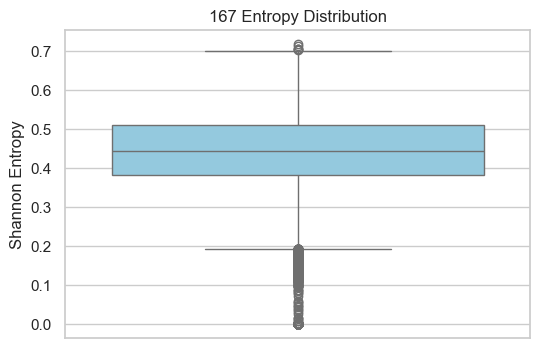

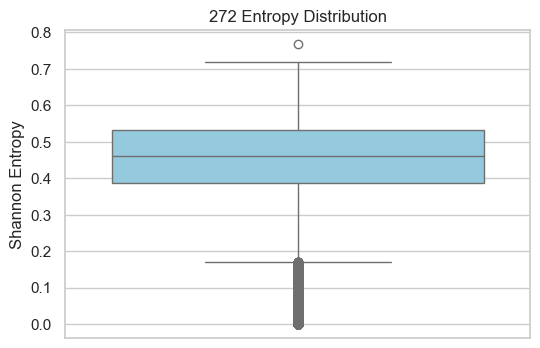

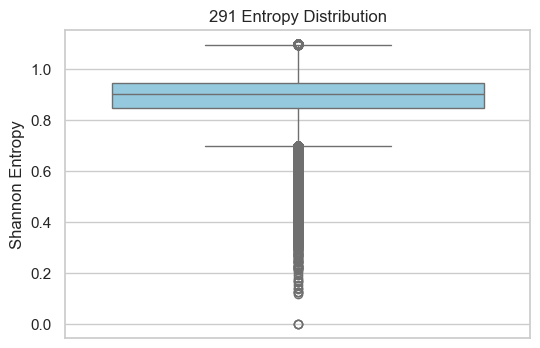

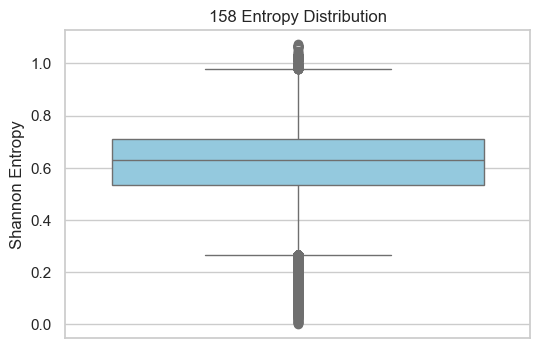

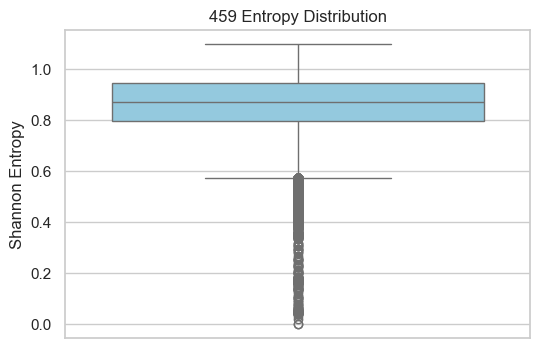

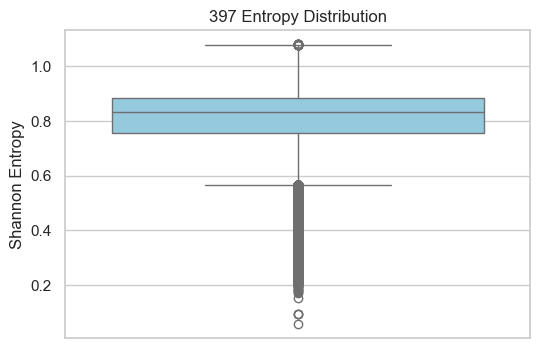

In [155]:
# Boxplots of entropy per histogram
for prefix in histogram_variables:
    plt.figure(figsize=(6,4))
    sns.boxplot(y=test_hist_freq[f"{prefix}_entropy"], color='skyblue')
    plt.title(f"{prefix} Entropy Distribution")
    plt.ylabel("Shannon Entropy")
    plt.show()

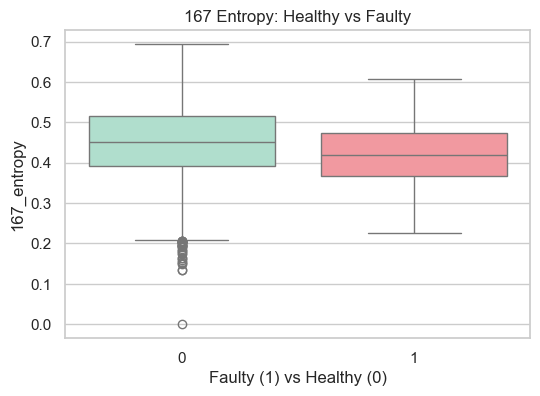

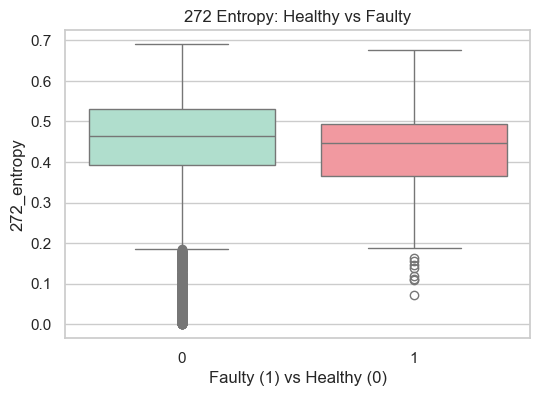

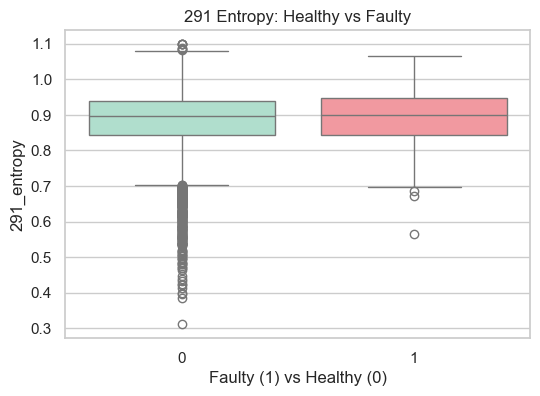

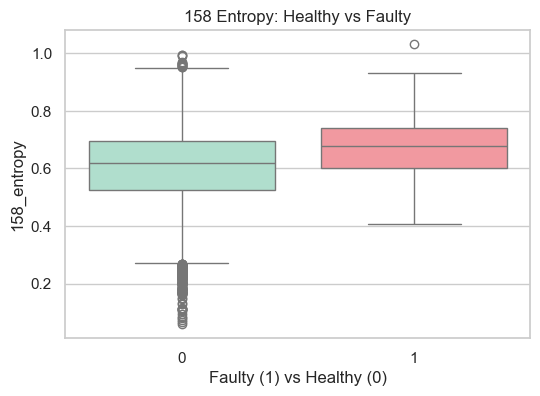

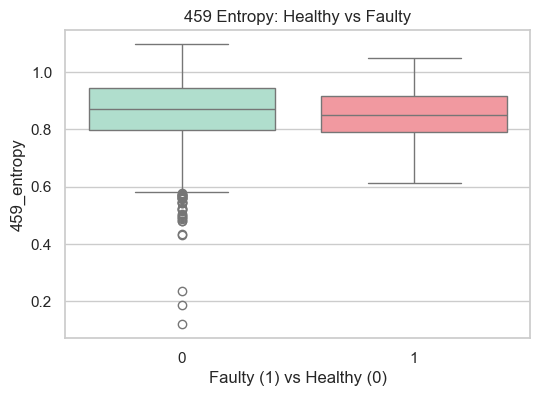

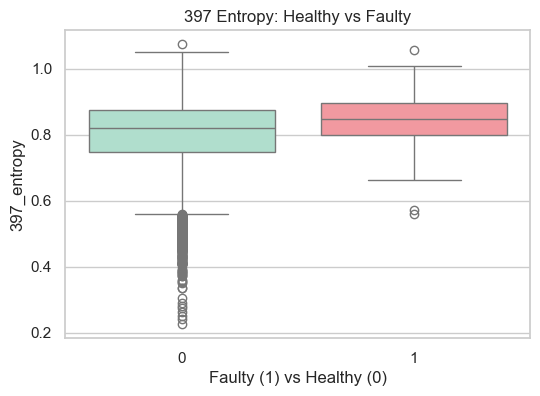

In [156]:
# Relate entropy to failure status
cmp = test_hist_freq[['vehicle_id'] + [f"{p}_entropy" for p in histogram_variables]] \
      .copy().groupby('vehicle_id').mean().reset_index() \
      .merge(test_rep, on='vehicle_id')

for prefix in histogram_variables:
    plt.figure(figsize=(6,4))
    sns.boxplot(data=cmp, x='class_label', y=f"{prefix}_entropy",
                palette={"0":'#a8e6cf',"1":'#ff8b94'})
    plt.title(f"{prefix} Entropy: Healthy vs Faulty")
    plt.xlabel("Faulty (1) vs Healthy (0)")
    plt.show()

In [157]:
test_op_final = test_op_norm_clean.merge(test_hist_freq, on = ["vehicle_id", "time_step"], how = "inner")
test_op_final

vehicle_id  time_step         171_0        666_0         427_0  \
0                1        4.4           NaN          NaN           NaN   
1                1        5.0  18325.000000  1993.333333  5.870333e+05   
2                1        8.2  34073.437500  4428.125000  1.130797e+06   
3                1        9.8  28593.750000  3607.500000  1.006912e+06   
4                1       20.6  24036.111111  2671.018519  8.039546e+05   
...            ...        ...           ...          ...           ...   
198135       33638       59.6  18401.470588  1749.264706  6.087412e+05   
198136       33638       65.6  28322.500000  1863.333333  9.136252e+05   
198137       33638       69.8  27800.000000  1547.619048  8.724143e+05   
198138       33638       70.8  20490.000000  1417.000000  6.804800e+05   
198139       33638       71.4  21125.000000  1561.666667  7.021500e+05   

              837_0      309_0         100_0  167_0_freq  167_1_freq  ...  \
0               NaN        NaN           NaN    0.240018    0.756041  ...   
1       1000.000000  41.666667  28091.666667    0.232967    0.762825  ...   
2       1495.312500   6.250000  43235.625000    0.172118    0.824097  ...   
3       2821.875000  87.500000  51283.125000    0.160303    0.834652  ...   
4       1815.277778  88.888889  38716.481481    0.131347    0.862291  ...   
...             ...        ...           ...         ...         ...  ...   
198135   304.411765   0.000000  22703.823529    0.111623    0.888377  ...   
198136   182.666667   0.000000  27507.000000    0.107788    0.892212  ...   
198137    82.142857   0.000000  22374.285714    0.104690    0.895310  ...   
198138    30.000000   0.000000  27759.000000    0.104645    0.895355  ...   
198139   150.000000   0.000000  29530.000000    0.104881    0.895119  ...   

        459_2_freq  397_0_freq  397_1_freq  397_2_freq  167_entropy  \
0         0.548271    0.698664    0.203098    0.098238     0.575766   
1         0.550890    0.688013    0.208726    0.103262     0.568939   
2         0.522273    0.642762    0.220790    0.136448     0.483401   
3         0.499317    0.641907    0.216008    0.142085     0.471005   
4         0.509176    0.640298    0.217077    0.142625     0.426559   
...            ...         ...         ...         ...          ...   
198135    0.561528    0.566474    0.337400    0.096126     0.349896   
198136    0.566867    0.569809    0.335181    0.095010     0.341865   
198137    0.574423    0.571947    0.333717    0.094336     0.335268   
198138    0.573778    0.572973    0.332913    0.094114     0.335172   
198139    0.574255    0.573348    0.332730    0.093922     0.335677   

        272_entropy  291_entropy  158_entropy  459_entropy  397_entropy  
0          0.572690     0.866763     0.701661     0.901154     0.802230  
1          0.563026     0.883615     0.722022     0.896460     0.818753  
2          0.497902     0.939999     0.808665     0.878697     0.889380  
3          0.485838     0.952097     0.812650     0.882583     0.892838  
4          0.421571     0.978362     0.809036     0.880854     0.894812  
...             ...          ...          ...          ...          ...  
198135     0.403559     1.035988     0.684777     0.892444     0.913657  
198136     0.393561     1.039660     0.682964     0.887730     0.910505  
198137     0.387100     1.038724     0.682512     0.881818     0.908511  
198138     0.387672     1.039910     0.681556     0.882317     0.907675  
198139     0.387689     1.040424     0.681194     0.882317     0.907229  

[198140 rows x 32 columns]

In [158]:
# Final merge into train_op_final
test_op_final = test_op_norm_clean.merge(test_hist_freq, on=["vehicle_id", "time_step"], how="inner")

# Rename frequency columns
freq_cols = [c for c in test_op_final.columns if c.endswith('_freq')]
rename_map = {c: c.replace('_freq', '') for c in freq_cols}
test_op_final.rename(columns=rename_map, inplace=True)

# Final sanity check
print("Remaining entropy cols:", [c for c in test_op_final.columns if 'entropy' in c])
print("Sample histogram cols:", [c for c in test_op_final.columns if c.startswith('167_')][:5])
print("train_op_final shape:", test_op_final.shape)

Remaining entropy cols: ['167_entropy', '272_entropy', '291_entropy', '158_entropy', '459_entropy', '397_entropy']
Sample histogram cols: ['167_0', '167_1', '167_2', '167_entropy']
train_op_final shape: (198140, 32)


In [159]:
test_op_final

vehicle_id  time_step         171_0        666_0         427_0  \
0                1        4.4           NaN          NaN           NaN   
1                1        5.0  18325.000000  1993.333333  5.870333e+05   
2                1        8.2  34073.437500  4428.125000  1.130797e+06   
3                1        9.8  28593.750000  3607.500000  1.006912e+06   
4                1       20.6  24036.111111  2671.018519  8.039546e+05   
...            ...        ...           ...          ...           ...   
198135       33638       59.6  18401.470588  1749.264706  6.087412e+05   
198136       33638       65.6  28322.500000  1863.333333  9.136252e+05   
198137       33638       69.8  27800.000000  1547.619048  8.724143e+05   
198138       33638       70.8  20490.000000  1417.000000  6.804800e+05   
198139       33638       71.4  21125.000000  1561.666667  7.021500e+05   

              837_0      309_0         100_0     167_0     167_1  ...  \
0               NaN        NaN           NaN  0.240018  0.756041  ...   
1       1000.000000  41.666667  28091.666667  0.232967  0.762825  ...   
2       1495.312500   6.250000  43235.625000  0.172118  0.824097  ...   
3       2821.875000  87.500000  51283.125000  0.160303  0.834652  ...   
4       1815.277778  88.888889  38716.481481  0.131347  0.862291  ...   
...             ...        ...           ...       ...       ...  ...   
198135   304.411765   0.000000  22703.823529  0.111623  0.888377  ...   
198136   182.666667   0.000000  27507.000000  0.107788  0.892212  ...   
198137    82.142857   0.000000  22374.285714  0.104690  0.895310  ...   
198138    30.000000   0.000000  27759.000000  0.104645  0.895355  ...   
198139   150.000000   0.000000  29530.000000  0.104881  0.895119  ...   

           459_2     397_0     397_1     397_2  167_entropy  272_entropy  \
0       0.548271  0.698664  0.203098  0.098238     0.575766     0.572690   
1       0.550890  0.688013  0.208726  0.103262     0.568939     0.563026   
2       0.522273  0.642762  0.220790  0.136448     0.483401     0.497902   
3       0.499317  0.641907  0.216008  0.142085     0.471005     0.485838   
4       0.509176  0.640298  0.217077  0.142625     0.426559     0.421571   
...          ...       ...       ...       ...          ...          ...   
198135  0.561528  0.566474  0.337400  0.096126     0.349896     0.403559   
198136  0.566867  0.569809  0.335181  0.095010     0.341865     0.393561   
198137  0.574423  0.571947  0.333717  0.094336     0.335268     0.387100   
198138  0.573778  0.572973  0.332913  0.094114     0.335172     0.387672   
198139  0.574255  0.573348  0.332730  0.093922     0.335677     0.387689   

        291_entropy  158_entropy  459_entropy  397_entropy  
0          0.866763     0.701661     0.901154     0.802230  
1          0.883615     0.722022     0.896460     0.818753  
2          0.939999     0.808665     0.878697     0.889380  
3          0.952097     0.812650     0.882583     0.892838  
4          0.978362     0.809036     0.880854     0.894812  
...             ...          ...          ...          ...  
198135     1.035988     0.684777     0.892444     0.913657  
198136     1.039660     0.682964     0.887730     0.910505  
198137     1.038724     0.682512     0.881818     0.908511  
198138     1.039910     0.681556     0.882317     0.907675  
198139     1.040424     0.681194     0.882317     0.907229  

[198140 rows x 32 columns]

In [160]:
test_op

vehicle_id  time_step      171_0    666_0       427_0    837_0  \
0                1        4.4    94410.0   7982.0   3115020.0   2625.0   
1                1        5.0   105405.0   9178.0   3467240.0   3225.0   
2                1        8.2   214440.0  23348.0   7085790.0   8010.0   
3                1        9.8   260190.0  29120.0   8696850.0  12525.0   
4                1       20.6   519780.0  57967.0  17379560.0  32130.0   
...            ...        ...        ...      ...         ...      ...   
198135       33638       59.6  1151970.0  53911.0  37965610.0   5760.0   
198136       33638       65.6  1321905.0  65091.0  43447361.0   6856.0   
198137       33638       69.8  1438665.0  71591.0  47111501.0   7201.0   
198138       33638       70.8  1459155.0  73008.0  47791981.0   7231.0   
198139       33638       71.4  1471830.0  73945.0  48213271.0   7321.0   

         167_0      167_1      167_2      167_3  ...     397_26   397_27  \
0       1304.0   366624.0   232040.0   147104.0  ...    72548.0   9696.0   
1       1305.0   390896.0   252528.0   157824.0  ...    83147.0  12042.0   
2       4897.0   461240.0   378264.0   313016.0  ...   198090.0  26099.0   
3       6513.0   493728.0   455352.0   363984.0  ...   244326.0  32708.0   
4       7617.0   665120.0   818912.0   664784.0  ...   500995.0  61122.0   
...        ...        ...        ...        ...  ...        ...      ...   
198135  2024.0  1060370.0  1621321.0  1296818.0  ...   900593.0  59376.0   
198136  2024.0  1141978.0  1773113.0  1425914.0  ...  1011299.0  69093.0   
198137  2024.0  1166667.0  1862506.0  1502034.0  ...  1086320.0  73748.0   
198138  2024.0  1173795.0  1895626.0  1517987.0  ...  1098011.0  74736.0   
198139  2024.0  1187164.0  1916914.0  1532811.0  ...  1105263.0  75543.0   

         397_28  397_29   397_30    397_31    397_32    397_33   397_34  \
0        1309.0     7.0    399.0   31843.0   89138.0   24101.0   5112.0   
1        1841.0     7.0    455.0   35749.0  106366.0   28168.0   5420.0   
2        4516.0    21.0   1120.0   94017.0  293462.0   85596.0  16655.0   
3        5714.0    49.0   1498.0  118349.0  378176.0  115130.0  24054.0   
4       14247.0   169.0   3788.0  222712.0  741413.0  237274.0  59636.0   
...         ...     ...      ...       ...       ...       ...      ...   
198135   8906.0    70.0  11783.0  386958.0  717951.0  143395.0  17803.0   
198136  10390.0   126.0  13428.0  421160.0  812403.0  170877.0  21681.0   
198137  11454.0   133.0  14184.0  445289.0  880675.0  186809.0  24153.0   
198138  11672.0   133.0  14436.0  449272.0  890349.0  189582.0  24580.0   
198139  11814.0   133.0  14605.0  450637.0  896643.0  191990.0  24867.0   

        397_35  
0          7.0  
1          7.0  
2         14.0  
3         35.0  
4        639.0  
...        ...  
198135   127.0  
198136   141.0  
198137   148.0  
198138   148.0  
198139   162.0  

[198140 rows x 107 columns]

## Vehicle Specifications

### Train - Vehicle Specifications

In [161]:
train_spec = pd.read_csv("train_specifications.csv")
train_spec

vehicle_id Spec_0 Spec_1 Spec_2 Spec_3 Spec_4 Spec_5 Spec_6 Spec_7
0               0   Cat0   Cat0   Cat0   Cat0   Cat0   Cat0   Cat0   Cat0
1               2   Cat0   Cat1   Cat1   Cat0   Cat0   Cat0   Cat0   Cat1
2               3   Cat0   Cat1   Cat1   Cat1   Cat0   Cat0   Cat0   Cat1
3               4   Cat0   Cat0   Cat2   Cat1   Cat0   Cat0   Cat0   Cat1
4               5   Cat0   Cat2   Cat2   Cat0   Cat0   Cat0   Cat0   Cat1
...           ...    ...    ...    ...    ...    ...    ...    ...    ...
23545       33639   Cat0   Cat1   Cat1   Cat0   Cat0   Cat0   Cat1   Cat4
23546       33640   Cat0  Cat14   Cat1   Cat3   Cat0   Cat0   Cat1   Cat4
23547       33641   Cat0   Cat1   Cat1   Cat0   Cat0   Cat0   Cat1   Cat4
23548       33642   Cat0   Cat1   Cat1   Cat0   Cat0   Cat0   Cat1   Cat4
23549       33643   Cat0   Cat0   Cat2   Cat0   Cat0   Cat0   Cat1   Cat4

[23550 rows x 9 columns]

In [162]:
train_spec.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23550 entries, 0 to 23549
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   vehicle_id  23550 non-null  int64 
 1   Spec_0      23550 non-null  object
 2   Spec_1      23550 non-null  object
 3   Spec_2      23550 non-null  object
 4   Spec_3      23550 non-null  object
 5   Spec_4      23550 non-null  object
 6   Spec_5      23550 non-null  object
 7   Spec_6      23550 non-null  object
 8   Spec_7      23550 non-null  object
dtypes: int64(1), object(8)
memory usage: 1.6+ MB


In [163]:
print("Summary Statistics for Categorical Features:")
print(train_spec.describe(include="all"))

Summary Statistics for Categorical Features:
          vehicle_id Spec_0 Spec_1 Spec_2 Spec_3 Spec_4 Spec_5 Spec_6 Spec_7
count   23550.000000  23550  23550  23550  23550  23550  23550  23550  23550
unique           NaN      3     29     21      4      2      5     17      9
top              NaN   Cat0   Cat1   Cat1   Cat0   Cat0   Cat0   Cat0   Cat0
freq             NaN  19221  13362  14352  14438  22875  19056  10163   7714
mean    16851.663185    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN
std      9714.309420    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN
min         0.000000    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN
25%      8468.250000    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN
50%     16882.500000    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN
75%     25247.750000    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN
max     33643.000000    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN


In [164]:
print("Number of duplicated instances:", train_spec.duplicated().sum())
print("Number of missing values:")
print(train_spec.isnull().sum())
print("Number of unique vehicles:", train_spec["vehicle_id"].nunique())

Number of duplicated instances: 0
Number of missing values:
vehicle_id    0
Spec_0        0
Spec_1        0
Spec_2        0
Spec_3        0
Spec_4        0
Spec_5        0
Spec_6        0
Spec_7        0
dtype: int64
Number of unique vehicles: 23550


In [165]:
# Frequency counts for each specification
train_spec_columns = [col for col in train_spec.columns if col.startswith("Spec")]

for col in train_spec_columns:
    print(f"\nValue counts for {col}:")
    print(train_spec[col].value_counts())
    print("Unique Categories:", train_spec[col].unique())


Value counts for Spec_0:
Spec_0
Cat0    19221
Cat1     4291
Cat2       38
Name: count, dtype: int64
Unique Categories: ['Cat0' 'Cat1' 'Cat2']

Value counts for Spec_1:
Spec_1
Cat1     13362
Cat0      1758
Cat2       935
Cat13      860
Cat7       818
Cat10      749
Cat9       716
Cat4       676
Cat5       541
Cat14      494
Cat15      400
Cat12      384
Cat6       316
Cat17      311
Cat3       278
Cat16      220
Cat28      161
Cat18      161
Cat8       128
Cat11      108
Cat22       46
Cat20       38
Cat19       33
Cat24       27
Cat26       12
Cat21       10
Cat23        5
Cat25        2
Cat27        1
Name: count, dtype: int64
Unique Categories: ['Cat0' 'Cat1' 'Cat2' 'Cat4' 'Cat5' 'Cat3' 'Cat6' 'Cat7' 'Cat8' 'Cat10'
 'Cat11' 'Cat9' 'Cat12' 'Cat13' 'Cat14' 'Cat15' 'Cat16' 'Cat17' 'Cat18'
 'Cat19' 'Cat21' 'Cat22' 'Cat24' 'Cat20' 'Cat26' 'Cat23' 'Cat25' 'Cat27'
 'Cat28']

Value counts for Spec_2:
Spec_2
Cat1     14352
Cat0      3255
Cat2      2624
Cat3       812
Cat10      755
Cat5     

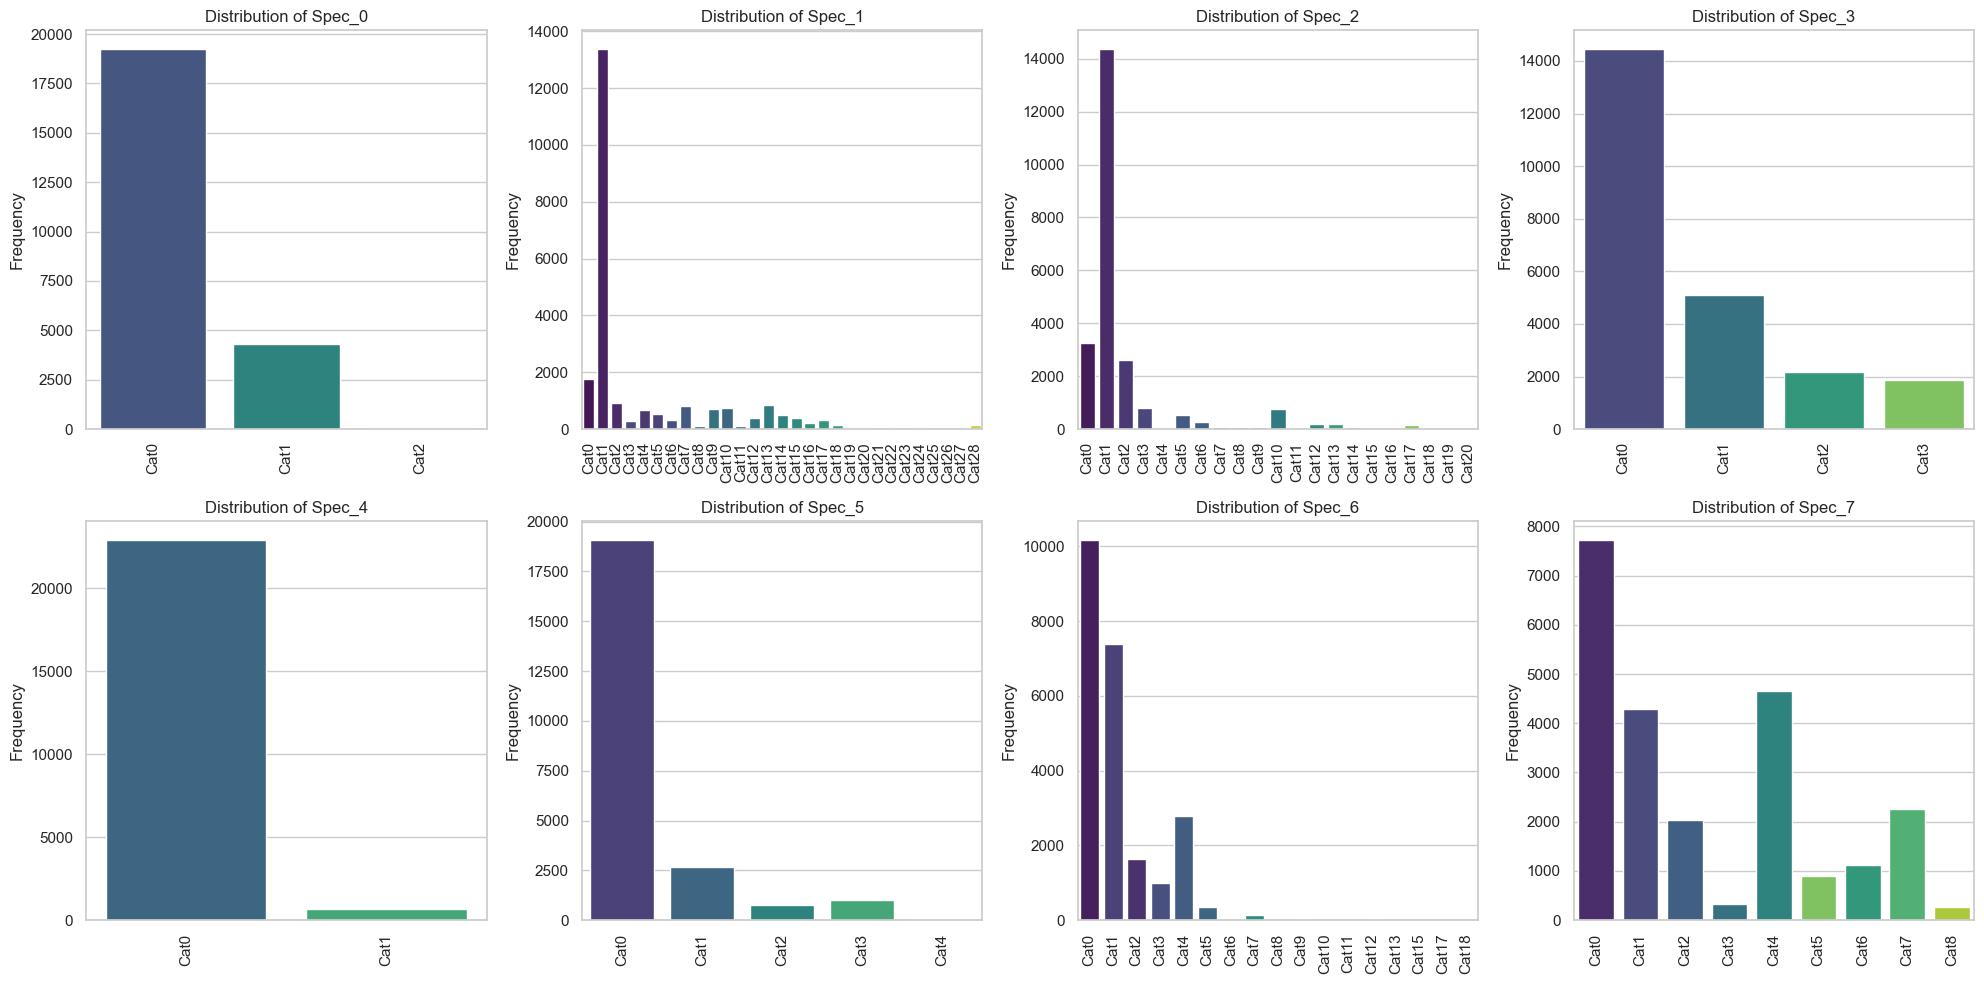

In [166]:
# Visualize the frequency distribution of each categorical feature using countplots
plt.figure(figsize=(20, 10))
for i, col in enumerate(train_spec_columns):
    plt.subplot(2, 4, i + 1)
    # Sort the categories numerically
    order = sorted(train_spec[col].unique(), key=lambda x: int(x.replace("Cat", "")))
    sns.countplot(data=train_spec, x=col, order=order, hue=col, palette="viridis", legend=False)
    plt.title(f"Distribution of {col}")
    plt.xlabel("")
    plt.ylabel("Frequency")
    plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [167]:
# Chi-Square test
train_spec_chi_square_results = []
for col1, col2 in combinations(train_spec_columns, 2):
    contingency_table = pd.crosstab(train_spec[col1], train_spec[col2])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    train_spec_chi_square_results.append((col1, col2, p))

# Convert results to a DataFrame and format the p-values
train_spec_chi_square_df = pd.DataFrame(train_spec_chi_square_results, columns=["Feature1", "Feature2", "Chi2_p_value"])
train_spec_chi_square_df["Chi2_p_value"] = train_spec_chi_square_df["Chi2_p_value"].apply(lambda x: f"({x:.3f})")

print("Chi-Square Test Results:")
print(train_spec_chi_square_df)

Chi-Square Test Results:
   Feature1 Feature2 Chi2_p_value
0    Spec_0   Spec_1      (0.000)
1    Spec_0   Spec_2      (0.000)
2    Spec_0   Spec_3      (0.000)
3    Spec_0   Spec_4      (0.000)
4    Spec_0   Spec_5      (0.000)
5    Spec_0   Spec_6      (0.000)
6    Spec_0   Spec_7      (0.000)
7    Spec_1   Spec_2      (0.000)
8    Spec_1   Spec_3      (0.000)
9    Spec_1   Spec_4      (0.000)
10   Spec_1   Spec_5      (0.000)
11   Spec_1   Spec_6      (0.000)
12   Spec_1   Spec_7      (0.000)
13   Spec_2   Spec_3      (0.000)
14   Spec_2   Spec_4      (0.000)
15   Spec_2   Spec_5      (0.000)
16   Spec_2   Spec_6      (0.000)
17   Spec_2   Spec_7      (0.000)
18   Spec_3   Spec_4      (0.000)
19   Spec_3   Spec_5      (0.000)
20   Spec_3   Spec_6      (0.000)
21   Spec_3   Spec_7      (0.000)
22   Spec_4   Spec_5      (0.000)
23   Spec_4   Spec_6      (0.000)
24   Spec_4   Spec_7      (0.000)
25   Spec_5   Spec_6      (0.000)
26   Spec_5   Spec_7      (0.000)
27   Spec_6   Spec_7   

All Specification pairs are not independent.

In [168]:
train_spec_chi_square_df

Feature1 Feature2 Chi2_p_value
0    Spec_0   Spec_1      (0.000)
1    Spec_0   Spec_2      (0.000)
2    Spec_0   Spec_3      (0.000)
3    Spec_0   Spec_4      (0.000)
4    Spec_0   Spec_5      (0.000)
5    Spec_0   Spec_6      (0.000)
6    Spec_0   Spec_7      (0.000)
7    Spec_1   Spec_2      (0.000)
8    Spec_1   Spec_3      (0.000)
9    Spec_1   Spec_4      (0.000)
10   Spec_1   Spec_5      (0.000)
11   Spec_1   Spec_6      (0.000)
12   Spec_1   Spec_7      (0.000)
13   Spec_2   Spec_3      (0.000)
14   Spec_2   Spec_4      (0.000)
15   Spec_2   Spec_5      (0.000)
16   Spec_2   Spec_6      (0.000)
17   Spec_2   Spec_7      (0.000)
18   Spec_3   Spec_4      (0.000)
19   Spec_3   Spec_5      (0.000)
20   Spec_3   Spec_6      (0.000)
21   Spec_3   Spec_7      (0.000)
22   Spec_4   Spec_5      (0.000)
23   Spec_4   Spec_6      (0.000)
24   Spec_4   Spec_7      (0.000)
25   Spec_5   Spec_6      (0.000)
26   Spec_5   Spec_7      (0.000)
27   Spec_6   Spec_7      (0.000)

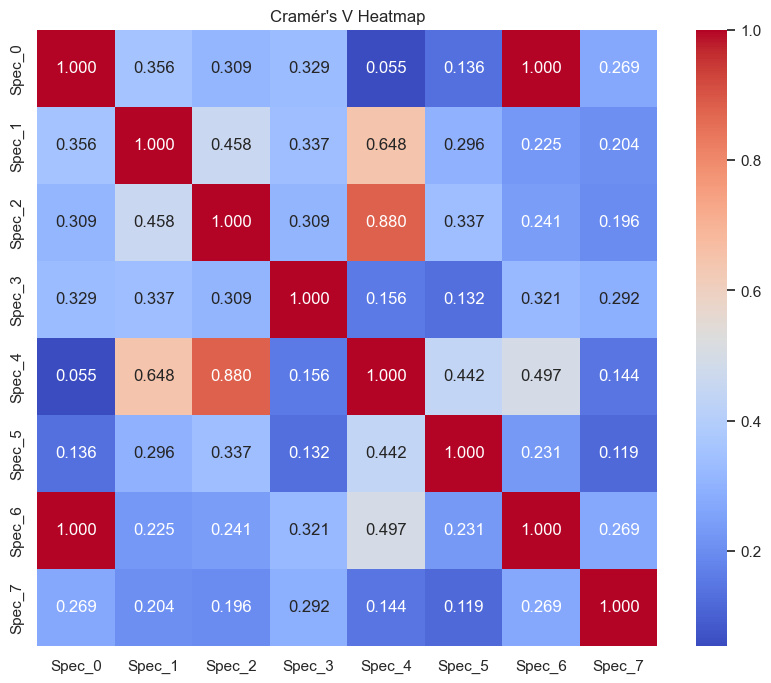

In [169]:
# Define Cramér"s V function
def cramers_v(confusion_matrix):
    chi2, p, dof, expected = chi2_contingency(confusion_matrix)
    n = confusion_matrix.to_numpy().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    # Correction for bias
    phi2corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    rcorr = r - ((r - 1)**2) / (n - 1)
    kcorr = k - ((k - 1)**2) / (n - 1)
    return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))

# Initialize the matrix for storing Cramér"s V values
features = train_spec_columns
n_features = len(features)
train_spec_cramers_v_matrix = pd.DataFrame(np.zeros((n_features, n_features)), index=features, columns=features)

# Fill diagonal with 1"s (a feature is perfectly associated with itself)
np.fill_diagonal(train_spec_cramers_v_matrix.values, 1.0)

# Compute Cramér"s V for each unique pair and fill the symmetric matrix
for col1, col2 in combinations(features, 2):
    table = pd.crosstab(train_spec[col1], train_spec[col2])
    v = cramers_v(table)
    train_spec_cramers_v_matrix.loc[col1, col2] = v
    train_spec_cramers_v_matrix.loc[col2, col1] = v

# Visualize the Cramér"s V results in a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(train_spec_cramers_v_matrix, annot=True, cmap="coolwarm", fmt=".3f")
plt.title("Cramér's V Heatmap")
plt.show()

In [170]:
train_spec_cramers_v_matrix

Spec_0    Spec_1    Spec_2    Spec_3    Spec_4    Spec_5    Spec_6  \
Spec_0  1.000000  0.356452  0.309482  0.329387  0.054567  0.135681  0.999703   
Spec_1  0.356452  1.000000  0.457784  0.337378  0.647520  0.296178  0.225019   
Spec_2  0.309482  0.457784  1.000000  0.309209  0.880149  0.337360  0.241062   
Spec_3  0.329387  0.337378  0.309209  1.000000  0.155872  0.132016  0.320742   
Spec_4  0.054567  0.647520  0.880149  0.155872  1.000000  0.441575  0.496597   
Spec_5  0.135681  0.296178  0.337360  0.132016  0.441575  1.000000  0.230629   
Spec_6  0.999703  0.225019  0.241062  0.320742  0.496597  0.230629  1.000000   
Spec_7  0.269393  0.203500  0.196177  0.292198  0.144082  0.118531  0.269396   

          Spec_7  
Spec_0  0.269393  
Spec_1  0.203500  
Spec_2  0.196177  
Spec_3  0.292198  
Spec_4  0.144082  
Spec_5  0.118531  
Spec_6  0.269396  
Spec_7  1.000000

In [171]:
(train_spec["Spec_6"] == train_spec["Spec_0"]).sum()

10163

In 10163 instances, the values in Spec_6 exactly match those in Spec_0. This perfect match explains why the Cramér"s V is essentially 1.000.

### Validation - Vehicle Specifications

In [172]:
val_spec = pd.read_csv("validation_specifications.csv")
val_spec

vehicle_id Spec_0 Spec_1 Spec_2 Spec_3 Spec_4 Spec_5 Spec_6 Spec_7
0             10   Cat0   Cat0   Cat0   Cat0   Cat0   Cat1   Cat0   Cat1
1             16   Cat0   Cat1   Cat1   Cat1   Cat0   Cat0   Cat0   Cat1
2             18   Cat0   Cat1   Cat1   Cat1   Cat0   Cat0   Cat0   Cat1
3             23   Cat0   Cat1   Cat1   Cat1   Cat0   Cat0   Cat0   Cat0
4             45   Cat0   Cat0   Cat0   Cat0   Cat0   Cat1   Cat0   Cat1
...          ...    ...    ...    ...    ...    ...    ...    ...    ...
5041       33596   Cat0   Cat1   Cat1   Cat1   Cat0   Cat0   Cat0   Cat7
5042       33601   Cat0   Cat1   Cat1   Cat0   Cat0   Cat0   Cat1   Cat4
5043       33605   Cat0   Cat1   Cat1   Cat0   Cat0   Cat0   Cat0   Cat4
5044       33612   Cat0   Cat1   Cat1   Cat0   Cat0   Cat0   Cat1   Cat4
5045       33625   Cat0   Cat1   Cat1   Cat0   Cat0   Cat0   Cat1   Cat5

[5046 rows x 9 columns]

In [173]:
val_spec.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5046 entries, 0 to 5045
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   vehicle_id  5046 non-null   int64 
 1   Spec_0      5046 non-null   object
 2   Spec_1      5046 non-null   object
 3   Spec_2      5046 non-null   object
 4   Spec_3      5046 non-null   object
 5   Spec_4      5046 non-null   object
 6   Spec_5      5046 non-null   object
 7   Spec_6      5046 non-null   object
 8   Spec_7      5046 non-null   object
dtypes: int64(1), object(8)
memory usage: 354.9+ KB


In [174]:
print("Summary Statistics for Categorical Features:")
print(val_spec.describe(include="all"))

Summary Statistics for Categorical Features:
          vehicle_id Spec_0 Spec_1 Spec_2 Spec_3 Spec_4 Spec_5 Spec_6 Spec_7
count    5046.000000   5046   5046   5046   5046   5046   5046   5046   5046
unique           NaN      3     29     20      4      2      5     16      9
top              NaN   Cat0   Cat1   Cat1   Cat0   Cat0   Cat0   Cat0   Cat0
freq             NaN   4099   2855   3058   3069   4883   4067   2115   1631
mean    16695.041023    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN
std      9651.669749    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN
min        10.000000    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN
25%      8324.750000    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN
50%     16598.000000    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN
75%     25058.750000    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN
max     33625.000000    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN


In [175]:
print("Number of duplicated instances:", val_spec.duplicated().sum())
print("Number of missing values:")
print(val_spec.isnull().sum())
print("Number of unique vehicles:", val_spec["vehicle_id"].nunique())

Number of duplicated instances: 0
Number of missing values:
vehicle_id    0
Spec_0        0
Spec_1        0
Spec_2        0
Spec_3        0
Spec_4        0
Spec_5        0
Spec_6        0
Spec_7        0
dtype: int64
Number of unique vehicles: 5046


In [176]:
# Frequency counts for each specification
val_spec_columns = [col for col in val_spec.columns if col.startswith("Spec")]

for col in val_spec_columns:
    print(f"\nValue counts for {col}:")
    print(val_spec[col].value_counts())
    print("Unique Categories:", val_spec[col].unique())


Value counts for Spec_0:
Spec_0
Cat0    4099
Cat1     928
Cat2      19
Name: count, dtype: int64
Unique Categories: ['Cat0' 'Cat1' 'Cat2']

Value counts for Spec_1:
Spec_1
Cat1     2855
Cat0      367
Cat2      218
Cat13     193
Cat10     171
Cat7      163
Cat4      140
Cat9      133
Cat5      116
Cat14     104
Cat15      98
Cat12      77
Cat17      74
Cat6       72
Cat3       59
Cat28      44
Cat16      38
Cat18      32
Cat8       26
Cat11      24
Cat20      12
Cat19       8
Cat26       5
Cat24       5
Cat22       5
Cat25       2
Cat21       2
Cat27       2
Cat23       1
Name: count, dtype: int64
Unique Categories: ['Cat0' 'Cat1' 'Cat5' 'Cat3' 'Cat9' 'Cat2' 'Cat7' 'Cat11' 'Cat12' 'Cat13'
 'Cat16' 'Cat17' 'Cat6' 'Cat15' 'Cat4' 'Cat10' 'Cat14' 'Cat18' 'Cat19'
 'Cat20' 'Cat23' 'Cat8' 'Cat25' 'Cat21' 'Cat26' 'Cat27' 'Cat28' 'Cat24'
 'Cat22']

Value counts for Spec_2:
Spec_2
Cat1     3058
Cat0      723
Cat2      577
Cat3      156
Cat10     152
Cat5      116
Cat6       57
Cat12      47
Cat1

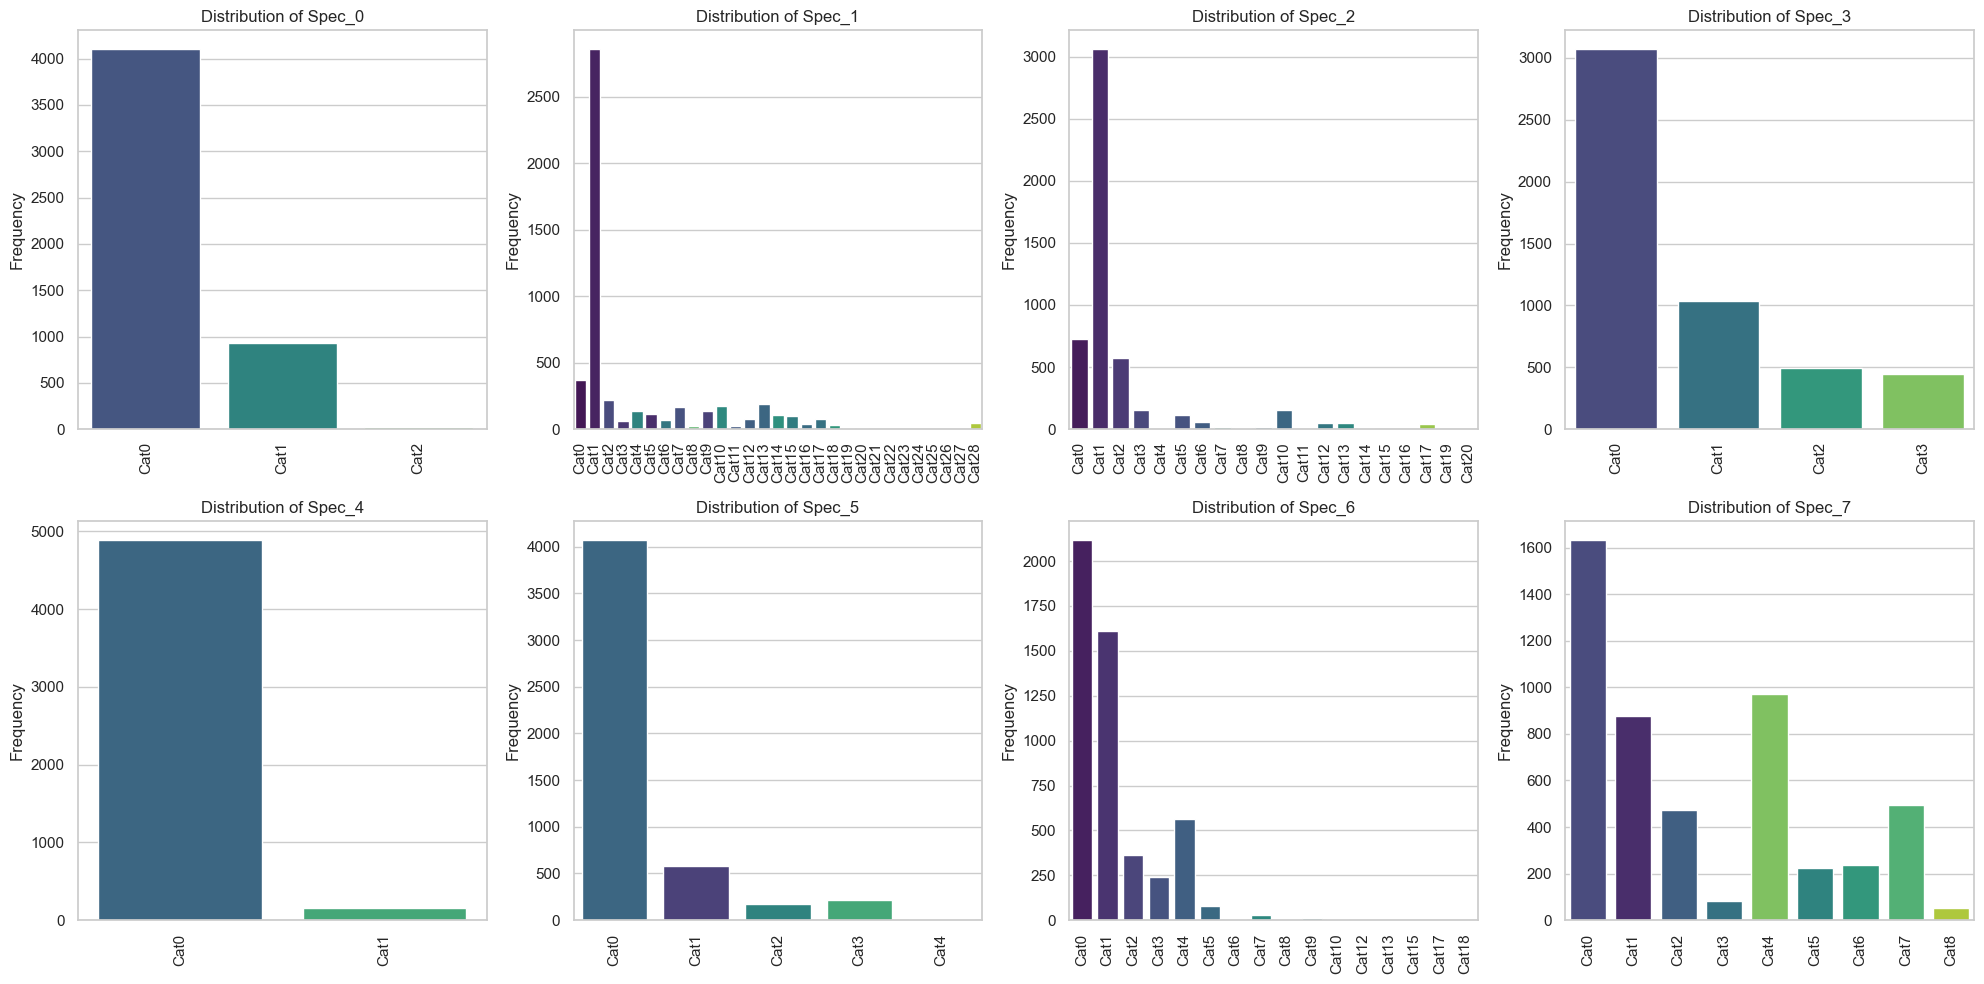

In [177]:
# Visualize the frequency distribution of each categorical feature using countplots
plt.figure(figsize=(20, 10))
for i, col in enumerate(val_spec_columns):
    plt.subplot(2, 4, i + 1)
    # Sort the categories numerically
    order = sorted(val_spec[col].unique(), key=lambda x: int(x.replace("Cat", "")))
    sns.countplot(data=val_spec, x=col, order=order, hue=col, palette="viridis", legend=False)
    plt.title(f"Distribution of {col}")
    plt.xlabel("")
    plt.ylabel("Frequency")
    plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [178]:
# Chi-Square test
val_spec_chi_square_results = []
for col1, col2 in combinations(val_spec_columns, 2):
    contingency_table = pd.crosstab(val_spec[col1], val_spec[col2])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    val_spec_chi_square_results.append((col1, col2, p))

# Convert results to a DataFrame and format the p-values
val_spec_chi_square_df = pd.DataFrame(val_spec_chi_square_results, columns=["Feature1", "Feature2", "Chi2_p_value"])
val_spec_chi_square_df["Chi2_p_value"] = val_spec_chi_square_df["Chi2_p_value"].apply(lambda x: f"({x:.3f})")

print("Chi-Square Test Results:")
print(val_spec_chi_square_df)

Chi-Square Test Results:
   Feature1 Feature2 Chi2_p_value
0    Spec_0   Spec_1      (0.000)
1    Spec_0   Spec_2      (0.000)
2    Spec_0   Spec_3      (0.000)
3    Spec_0   Spec_4      (0.000)
4    Spec_0   Spec_5      (0.000)
5    Spec_0   Spec_6      (0.000)
6    Spec_0   Spec_7      (0.000)
7    Spec_1   Spec_2      (0.000)
8    Spec_1   Spec_3      (0.000)
9    Spec_1   Spec_4      (0.000)
10   Spec_1   Spec_5      (0.000)
11   Spec_1   Spec_6      (0.000)
12   Spec_1   Spec_7      (0.000)
13   Spec_2   Spec_3      (0.000)
14   Spec_2   Spec_4      (0.000)
15   Spec_2   Spec_5      (0.000)
16   Spec_2   Spec_6      (0.000)
17   Spec_2   Spec_7      (0.000)
18   Spec_3   Spec_4      (0.000)
19   Spec_3   Spec_5      (0.000)
20   Spec_3   Spec_6      (0.000)
21   Spec_3   Spec_7      (0.000)
22   Spec_4   Spec_5      (0.000)
23   Spec_4   Spec_6      (0.000)
24   Spec_4   Spec_7      (0.000)
25   Spec_5   Spec_6      (0.000)
26   Spec_5   Spec_7      (0.000)
27   Spec_6   Spec_7   

In [179]:
val_spec_chi_square_df

Feature1 Feature2 Chi2_p_value
0    Spec_0   Spec_1      (0.000)
1    Spec_0   Spec_2      (0.000)
2    Spec_0   Spec_3      (0.000)
3    Spec_0   Spec_4      (0.000)
4    Spec_0   Spec_5      (0.000)
5    Spec_0   Spec_6      (0.000)
6    Spec_0   Spec_7      (0.000)
7    Spec_1   Spec_2      (0.000)
8    Spec_1   Spec_3      (0.000)
9    Spec_1   Spec_4      (0.000)
10   Spec_1   Spec_5      (0.000)
11   Spec_1   Spec_6      (0.000)
12   Spec_1   Spec_7      (0.000)
13   Spec_2   Spec_3      (0.000)
14   Spec_2   Spec_4      (0.000)
15   Spec_2   Spec_5      (0.000)
16   Spec_2   Spec_6      (0.000)
17   Spec_2   Spec_7      (0.000)
18   Spec_3   Spec_4      (0.000)
19   Spec_3   Spec_5      (0.000)
20   Spec_3   Spec_6      (0.000)
21   Spec_3   Spec_7      (0.000)
22   Spec_4   Spec_5      (0.000)
23   Spec_4   Spec_6      (0.000)
24   Spec_4   Spec_7      (0.000)
25   Spec_5   Spec_6      (0.000)
26   Spec_5   Spec_7      (0.000)
27   Spec_6   Spec_7      (0.000)

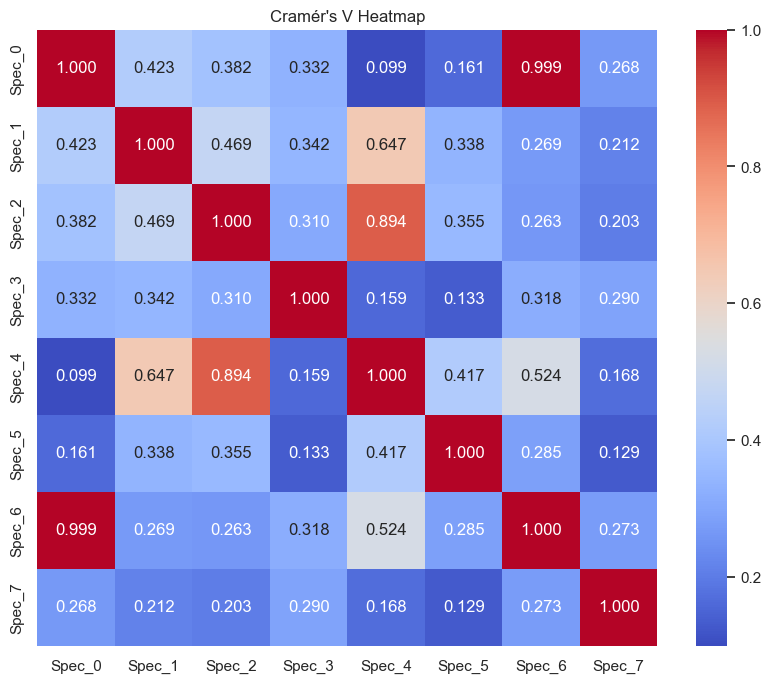

In [180]:
# Define Cramér"s V function
def cramers_v(confusion_matrix):
    chi2, p, dof, expected = chi2_contingency(confusion_matrix)
    n = confusion_matrix.to_numpy().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    # Correction for bias
    phi2corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    rcorr = r - ((r - 1)**2) / (n - 1)
    kcorr = k - ((k - 1)**2) / (n - 1)
    return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))

# Initialize the matrix for storing Cramér"s V values
features = val_spec_columns
n_features = len(features)
val_spec_cramers_v_matrix = pd.DataFrame(np.zeros((n_features, n_features)), index=features, columns=features)

# Fill diagonal with 1"s (a feature is perfectly associated with itself)
np.fill_diagonal(val_spec_cramers_v_matrix.values, 1.0)

# Compute Cramér"s V for each unique pair and fill the symmetric matrix
for col1, col2 in combinations(features, 2):
    table = pd.crosstab(val_spec[col1], val_spec[col2])
    v = cramers_v(table)
    val_spec_cramers_v_matrix.loc[col1, col2] = v
    val_spec_cramers_v_matrix.loc[col2, col1] = v

# Visualize the Cramér"s V results in a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(val_spec_cramers_v_matrix, annot=True, cmap="coolwarm", fmt=".3f")
plt.title("Cramér's V Heatmap")
plt.show()

In [181]:
val_spec_cramers_v_matrix

Spec_0    Spec_1    Spec_2    Spec_3    Spec_4    Spec_5    Spec_6  \
Spec_0  1.000000  0.422858  0.381670  0.331994  0.099303  0.160610  0.998710   
Spec_1  0.422858  1.000000  0.468869  0.342481  0.647243  0.338455  0.268946   
Spec_2  0.381670  0.468869  1.000000  0.309989  0.894362  0.355105  0.263194   
Spec_3  0.331994  0.342481  0.309989  1.000000  0.158980  0.133496  0.318417   
Spec_4  0.099303  0.647243  0.894362  0.158980  1.000000  0.417085  0.524277   
Spec_5  0.160610  0.338455  0.355105  0.133496  0.417085  1.000000  0.284813   
Spec_6  0.998710  0.268946  0.263194  0.318417  0.524277  0.284813  1.000000   
Spec_7  0.267899  0.212336  0.203360  0.289941  0.168121  0.129489  0.273308   

          Spec_7  
Spec_0  0.267899  
Spec_1  0.212336  
Spec_2  0.203360  
Spec_3  0.289941  
Spec_4  0.168121  
Spec_5  0.129489  
Spec_6  0.273308  
Spec_7  1.000000

### Test - Vehicle Specifications

In [182]:
test_spec = pd.read_csv("test_specifications.csv")
test_spec

vehicle_id Spec_0 Spec_1 Spec_2 Spec_3 Spec_4 Spec_5 Spec_6 Spec_7
0              1   Cat0   Cat1   Cat1   Cat0   Cat0   Cat0   Cat0   Cat1
1              6   Cat0   Cat2   Cat2   Cat0   Cat0   Cat0   Cat0   Cat1
2              7   Cat0   Cat2   Cat2   Cat0   Cat0   Cat0   Cat0   Cat1
3              9   Cat0   Cat3   Cat2   Cat1   Cat0   Cat1   Cat0   Cat1
4             11   Cat0   Cat1   Cat1   Cat0   Cat0   Cat1   Cat1   Cat0
...          ...    ...    ...    ...    ...    ...    ...    ...    ...
5040       33617   Cat0   Cat1   Cat1   Cat0   Cat0   Cat0   Cat1   Cat4
5041       33619   Cat0   Cat1   Cat1   Cat0   Cat0   Cat0   Cat1   Cat4
5042       33632   Cat0   Cat1   Cat1   Cat0   Cat0   Cat0   Cat1   Cat4
5043       33634   Cat0   Cat1   Cat1   Cat0   Cat0   Cat0   Cat1   Cat4
5044       33638   Cat0   Cat1   Cat1   Cat0   Cat0   Cat0   Cat1   Cat4

[5045 rows x 9 columns]

In [183]:
test_spec.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5045 entries, 0 to 5044
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   vehicle_id  5045 non-null   int64 
 1   Spec_0      5045 non-null   object
 2   Spec_1      5045 non-null   object
 3   Spec_2      5045 non-null   object
 4   Spec_3      5045 non-null   object
 5   Spec_4      5045 non-null   object
 6   Spec_5      5045 non-null   object
 7   Spec_6      5045 non-null   object
 8   Spec_7      5045 non-null   object
dtypes: int64(1), object(8)
memory usage: 354.9+ KB


In [184]:
print("Summary Statistics for Categorical Features:")
print(test_spec.describe(include="all"))

Summary Statistics for Categorical Features:
          vehicle_id Spec_0 Spec_1 Spec_2 Spec_3 Spec_4 Spec_5 Spec_6 Spec_7
count    5045.000000   5045   5045   5045   5045   5045   5045   5045   5045
unique           NaN      3     29     19      4      2      5     17      9
top              NaN   Cat0   Cat1   Cat1   Cat0   Cat0   Cat0   Cat0   Cat0
freq             NaN   4130   2828   3037   3077   4881   4034   2176   1629
mean    16803.188702    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN
std      9761.914799    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN
min         1.000000    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN
25%      8300.000000    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN
50%     16755.000000    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN
75%     25299.000000    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN
max     33638.000000    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN


In [185]:
print("Number of duplicated instances:", test_spec.duplicated().sum())
print("Number of missing values:")
print(test_spec.isnull().sum())
print("Number of unique vehicles:", test_spec["vehicle_id"].nunique())

Number of duplicated instances: 0
Number of missing values:
vehicle_id    0
Spec_0        0
Spec_1        0
Spec_2        0
Spec_3        0
Spec_4        0
Spec_5        0
Spec_6        0
Spec_7        0
dtype: int64
Number of unique vehicles: 5045


In [186]:
# Frequency counts for each specification
test_spec_columns = [col for col in test_spec.columns if col.startswith("Spec")]

for col in test_spec_columns:
    print(f"\nValue counts for {col}:")
    print(test_spec[col].value_counts())
    print("Unique Categories:", test_spec[col].unique())


Value counts for Spec_0:
Spec_0
Cat0    4130
Cat1     910
Cat2       5
Name: count, dtype: int64
Unique Categories: ['Cat0' 'Cat1' 'Cat2']

Value counts for Spec_1:
Spec_1
Cat1     2828
Cat0      372
Cat2      230
Cat13     182
Cat7      176
Cat4      172
Cat10     149
Cat9      138
Cat14     103
Cat15      98
Cat5       83
Cat12      82
Cat17      75
Cat6       69
Cat3       62
Cat28      47
Cat18      45
Cat16      42
Cat8       28
Cat11      27
Cat19       9
Cat20       8
Cat22       8
Cat26       4
Cat23       2
Cat21       2
Cat24       2
Cat27       1
Cat29       1
Name: count, dtype: int64
Unique Categories: ['Cat1' 'Cat2' 'Cat3' 'Cat9' 'Cat11' 'Cat12' 'Cat0' 'Cat6' 'Cat5' 'Cat14'
 'Cat10' 'Cat13' 'Cat4' 'Cat7' 'Cat16' 'Cat17' 'Cat18' 'Cat8' 'Cat15'
 'Cat20' 'Cat19' 'Cat26' 'Cat22' 'Cat27' 'Cat23' 'Cat21' 'Cat29' 'Cat24'
 'Cat28']

Value counts for Spec_2:
Spec_2
Cat1     3037
Cat0      703
Cat2      555
Cat3      164
Cat10     160
Cat5      145
Cat6       54
Cat12      50
Cat1

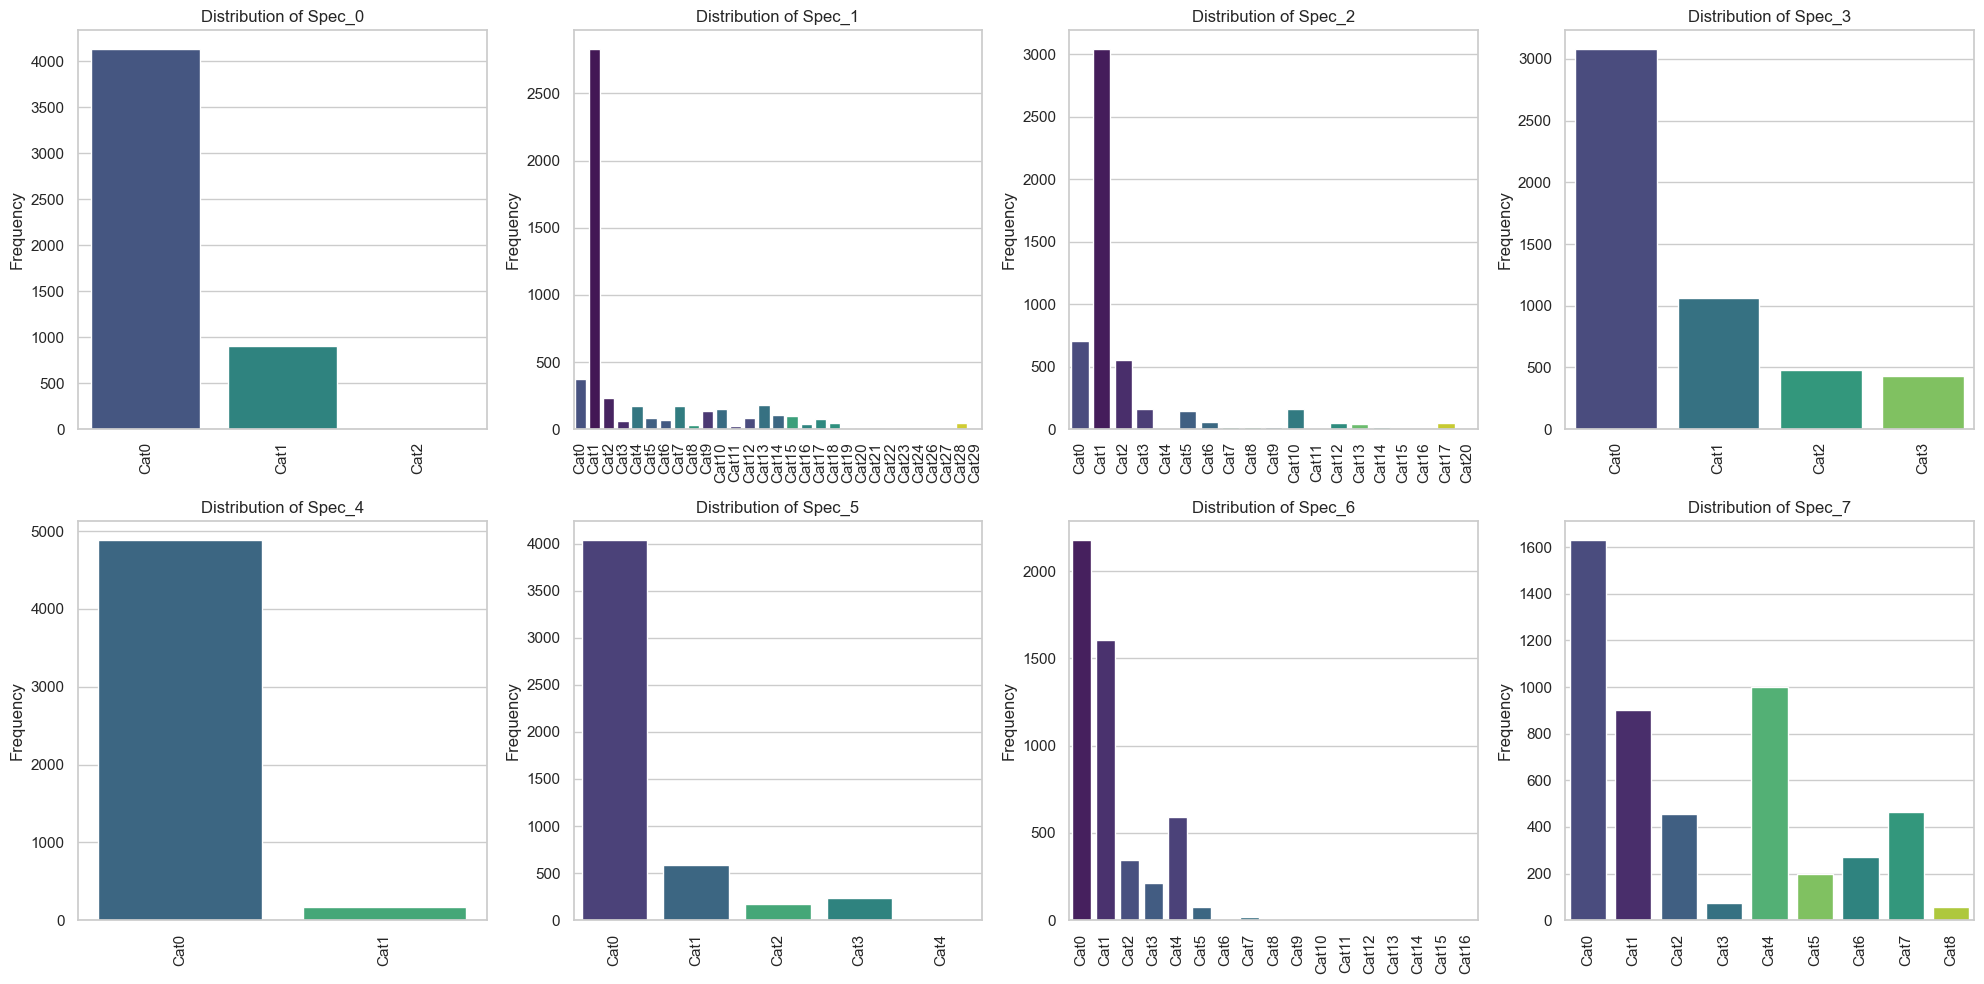

In [187]:
# Visualize the frequency distribution of each categorical feature using countplots
plt.figure(figsize=(20, 10))
for i, col in enumerate(test_spec_columns):
    plt.subplot(2, 4, i + 1)
    # Sort the categories numerically
    order = sorted(test_spec[col].unique(), key=lambda x: int(x.replace("Cat", "")))
    sns.countplot(data=test_spec, x=col, order=order, hue=col, palette="viridis", legend=False)
    plt.title(f"Distribution of {col}")
    plt.xlabel("")
    plt.ylabel("Frequency")
    plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [188]:
# Chi-Square test
test_spec_chi_square_results = []
for col1, col2 in combinations(test_spec_columns, 2):
    contingency_table = pd.crosstab(test_spec[col1], test_spec[col2])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    test_spec_chi_square_results.append((col1, col2, p))

# Convert results to a DataFrame and format the p-values
test_spec_chi_square_df = pd.DataFrame(test_spec_chi_square_results, columns=["Feature1", "Feature2", "Chi2_p_value"])
test_spec_chi_square_df["Chi2_p_value"] = test_spec_chi_square_df["Chi2_p_value"].apply(lambda x: f"({x:.3f})")

print("Chi-Square Test Results:")
print(test_spec_chi_square_df)

Chi-Square Test Results:
   Feature1 Feature2 Chi2_p_value
0    Spec_0   Spec_1      (0.000)
1    Spec_0   Spec_2      (0.000)
2    Spec_0   Spec_3      (0.000)
3    Spec_0   Spec_4      (0.000)
4    Spec_0   Spec_5      (0.000)
5    Spec_0   Spec_6      (0.000)
6    Spec_0   Spec_7      (0.000)
7    Spec_1   Spec_2      (0.000)
8    Spec_1   Spec_3      (0.000)
9    Spec_1   Spec_4      (0.000)
10   Spec_1   Spec_5      (0.000)
11   Spec_1   Spec_6      (0.000)
12   Spec_1   Spec_7      (0.000)
13   Spec_2   Spec_3      (0.000)
14   Spec_2   Spec_4      (0.000)
15   Spec_2   Spec_5      (0.000)
16   Spec_2   Spec_6      (0.000)
17   Spec_2   Spec_7      (0.000)
18   Spec_3   Spec_4      (0.000)
19   Spec_3   Spec_5      (0.000)
20   Spec_3   Spec_6      (0.000)
21   Spec_3   Spec_7      (0.000)
22   Spec_4   Spec_5      (0.000)
23   Spec_4   Spec_6      (0.000)
24   Spec_4   Spec_7      (0.000)
25   Spec_5   Spec_6      (0.000)
26   Spec_5   Spec_7      (0.000)
27   Spec_6   Spec_7   

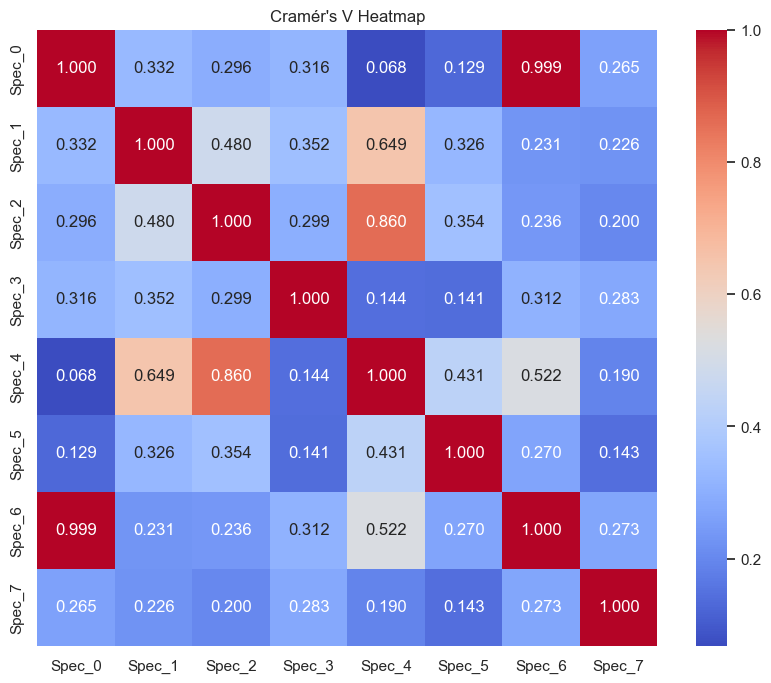

In [189]:
# Define Cramér"s V function
def cramers_v(confusion_matrix):
    chi2, p, dof, expected = chi2_contingency(confusion_matrix)
    n = confusion_matrix.to_numpy().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    # Correction for bias
    phi2corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    rcorr = r - ((r - 1)**2) / (n - 1)
    kcorr = k - ((k - 1)**2) / (n - 1)
    return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))

# Initialize the matrix for storing Cramér"s V values
features = test_spec_columns
n_features = len(features)
test_spec_cramers_v_matrix = pd.DataFrame(np.zeros((n_features, n_features)), index=features, columns=features)

# Fill diagonal with 1"s (a feature is perfectly associated with itself)
np.fill_diagonal(test_spec_cramers_v_matrix.values, 1.0)

# Compute Cramér"s V for each unique pair and fill the symmetric matrix
for col1, col2 in combinations(features, 2):
    table = pd.crosstab(test_spec[col1], test_spec[col2])
    v = cramers_v(table)
    test_spec_cramers_v_matrix.loc[col1, col2] = v
    test_spec_cramers_v_matrix.loc[col2, col1] = v

# Visualize the Cramér"s V results in a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(test_spec_cramers_v_matrix, annot=True, cmap="coolwarm", fmt=".3f")
plt.title("Cramér's V Heatmap")
plt.show()

In [190]:
test_spec_cramers_v_matrix

Spec_0    Spec_1    Spec_2    Spec_3    Spec_4    Spec_5    Spec_6  \
Spec_0  1.000000  0.331626  0.296410  0.316270  0.068322  0.128966  0.998611   
Spec_1  0.331626  1.000000  0.479711  0.351993  0.649003  0.326083  0.231441   
Spec_2  0.296410  0.479711  1.000000  0.298972  0.860175  0.353623  0.236048   
Spec_3  0.316270  0.351993  0.298972  1.000000  0.144333  0.140853  0.311525   
Spec_4  0.068322  0.649003  0.860175  0.144333  1.000000  0.431407  0.522488   
Spec_5  0.128966  0.326083  0.353623  0.140853  0.431407  1.000000  0.269780   
Spec_6  0.998611  0.231441  0.236048  0.311525  0.522488  0.269780  1.000000   
Spec_7  0.264582  0.225576  0.199690  0.282781  0.190057  0.142819  0.272668   

          Spec_7  
Spec_0  0.264582  
Spec_1  0.225576  
Spec_2  0.199690  
Spec_3  0.282781  
Spec_4  0.190057  
Spec_5  0.142819  
Spec_6  0.272668  
Spec_7  1.000000

In [191]:
# Check common vehicle_ids between datasets
spec_common_train_val = set(train_spec["vehicle_id"]) & set(val_spec["vehicle_id"])
spec_common_train_test = set(train_spec["vehicle_id"]) & set(test_spec["vehicle_id"])
spec_common_val_test = set(val_spec["vehicle_id"]) & set(test_spec["vehicle_id"])

# Check if train vehicles are in validation
if spec_common_train_val:
    print("Vehicles in train_spec that also appear in val_spec:")
    print(train_spec[train_spec["vehicle_id"].isin(val_spec["vehicle_id"])])
else:
    print("No trucks are present in both train_spec and val_spec.")

# Check if train vehicles are in test
if spec_common_train_test:
    print("\nVehicles in train_spec that also appear in test_spec:")
    print(train_spec[train_spec["vehicle_id"].isin(test_spec["vehicle_id"])])
else:
    print("\nNo trucks are present in both train_spec and test_spec.")

# Check if validation vehicles are in test (if relevant)
if spec_common_val_test:
    print("\nVehicles in val_spec that also appear in test_spec:")
    print(val_spec[val_spec["vehicle_id"].isin(test_spec["vehicle_id"])])
else:
    print("\nNo trucks are present in both val_spec and test_spec.")

No trucks are present in both train_spec and val_spec.

No trucks are present in both train_spec and test_spec.

No trucks are present in both val_spec and test_spec.


It is important to verify whether any vehicles (identified by vehicle_id) in the train_spec dataset are also present in the val_spec and test_spec datasets, and vice versa. This validation step ensures the integrity of the dataset split and is essential for accurately assessing the evaluation metrics during the modeling phase. The results confirm that no trucks are present in multiple datasets, indicating a proper separation of data.

## Repair Records

### Train - Repair Records

In [192]:
train_repair = pd.read_csv("train_tte.csv")
train_repair

vehicle_id  length_of_study_time_step  in_study_repair
0               0                      510.0                0
1               2                      281.8                0
2               3                      293.4                0
3               4                      210.0                0
4               5                      360.4                0
...           ...                        ...              ...
23545       33639                      137.4                0
23546       33640                      124.6                0
23547       33641                      123.0                0
23548       33642                      126.6                0
23549       33643                      130.2                0

[23550 rows x 3 columns]

The Train Repair Records dataset (train_repair) contains 3 variables:
* **vehicle_id:** identifies the vehicle in question;
* **length_of_study_time_step:** corresponds to the TTE (Time-To-Event).
* **in_study_repair:** identifies if the vehicle was repaired or not.

According to the dataset documentation, "the in_study_repair" is the class label, where it’s set to 1 if Component X was repaired at the time equal to its corresponding length_of_study_time_step, or it can take the value of zero in case no failure or repair event occurs during the first length_of_study_time_step of operation.


As such, the objectives of this analysis are the following:



1. Examine whether failure probability increases as operational time progresses, which would indicate wear-related degradation;
2. Investigate whether a high failure probability occurs early in the operational cycle, which could suggest manufacturing defects or installation issues (infant mortality);
3. Calculate the mean and minimum TTE values to estimate expected failure times and support maintenance planning.

Ultimately, this information can help maintenance planning and help develop the subsequent phases of this PdM strategy.

Having this information, the next step will be to analyze the presence of missing values, duplicated values, as well as the identification of faulty vehicles.

In [193]:
# Presence of Missing and Duplicated Values
print("Number of missing values:")
print(train_repair.isnull().sum())
print("Number of duplicated values: ", train_repair.duplicated().sum())

Number of missing values:
vehicle_id                   0
length_of_study_time_step    0
in_study_repair              0
dtype: int64
Number of duplicated values:  0


In [194]:
print("Number of unique vehicles:", train_repair["vehicle_id"].nunique())

Number of unique vehicles: 23550


As mentioned in the dataset documentation, this data source has no missing values. This code (dataset information) confirms that. In addition, there are no duplicated values.

Now, faulty vehicles will be identified and analyzed. In particular, the TTE from healthy and faulty vehicles will be compared.

In [195]:
# Identify Vehicles with Failures

train_repair_failures = train_repair[train_repair["in_study_repair"] == 1]
faulty_vehicles = train_repair_failures["vehicle_id"].unique()

print("Number of vehicles with failures:", len(faulty_vehicles))
print("Percentage of vehicles with failures:", round((len(faulty_vehicles)/len(train_repair)*100),2),"%")
print("Vehicle IDs with failures:")
print(faulty_vehicles)

Number of vehicles with failures: 2272
Percentage of vehicles with failures: 9.65 %
Vehicle IDs with failures:
[   22    27    29 ... 33467 33472 33528]


In [196]:
# Identify Healthy Vehicles

train_repair_healthy = train_repair[train_repair["in_study_repair"] == 0]
healthy_vehicles = train_repair_healthy["vehicle_id"].unique()

print("Number of healthy vehicles:", len(healthy_vehicles))
print("Percentage of healthy vehicles:", round((len(healthy_vehicles)/len(train_repair)*100),2),"%")
print("Vehicle IDs without failures:")
print(healthy_vehicles)

Number of healthy vehicles: 21278
Percentage of healthy vehicles: 90.35 %
Vehicle IDs without failures:
[    0     2     3 ... 33641 33642 33643]


This information is in lign with the one provided in the dataset documentation.

It is possible to observe that this dataset is imbalanced, i.e., healthy trucks are much more frequent than faulty ones, representing 90,35% and 9,65% respectively.

In [197]:
# TTE statistics for vehicles with failures

tte_failures = train_repair_failures["length_of_study_time_step"]
print("Time-to-Event (TTE) Statistics for Failures:")
print(tte_failures.describe())

print("Minimum TTE for failure:", round(tte_failures.min(),2))
print("Average TTE for failure:", round(tte_failures.mean(),2))
print("Median TTE for failure:", round(tte_failures.median(),2))
print("TTE Coefficient of Variation for faulty vehicles:", round((tte_failures.std()/tte_failures.mean()) * 100, 2),"%")

Time-to-Event (TTE) Statistics for Failures:
count    2272.000000
mean      214.007130
std        80.293009
min        73.400000
25%       148.550000
50%       208.400000
75%       276.250000
max       482.000000
Name: length_of_study_time_step, dtype: float64
Minimum TTE for failure: 73.4
Average TTE for failure: 214.01
Median TTE for failure: 208.4
TTE Coefficient of Variation for faulty vehicles: 37.52 %


In [198]:
# TTE statistics for healthy vehicles

tte_healthy = train_repair_healthy["length_of_study_time_step"]
print("Time-to-Event (TTE) Statistics for Healthy Vehicles:")
print(tte_healthy.describe())

print("Minimum TTE for healthy vehicles:", round(tte_healthy.min(),2))
print("Average TTE for healthy vehicles:", round(tte_healthy.mean(),2))
print("Median TTE for healthy vehicles:", round(tte_healthy.median(),2))
print("TTE Coefficient of Variation for healthy vehicles:", round((tte_healthy.std()/tte_healthy.mean()) * 100, 2),"%")

Time-to-Event (TTE) Statistics for Healthy Vehicles:
count    21278.000000
mean       243.161726
std         89.184566
min        121.000000
25%        165.200000
50%        219.000000
75%        316.400000
max        510.000000
Name: length_of_study_time_step, dtype: float64
Minimum TTE for healthy vehicles: 121.0
Average TTE for healthy vehicles: 243.16
Median TTE for healthy vehicles: 219.0
TTE Coefficient of Variation for healthy vehicles: 36.68 %


From these statistics, it"s possible to conclude the following:

* The **minimum TTE** for faulty vehicles (73,4) is notably lower than that of healthy vehciles (121.0). This indicates that, in some cases, failures can occur relatively early in the operational life.
* The **average TTE** for faulty vehicles is 214,01, compared to 243,16 for healthy bechiles. This aligns with the expectation that vehicles classified as faulty fail earlier, on average.
* The **median TTE** follows a similar pattern, with 208,4 for faulty vehicles and 219,0 for healthy ones.
* The **maximum TTE** for faulty vehicles is 482,0, while healthy vehicles can reach up to 510,0. This difference implies that if a failure is to occur, it is more likely to happen earlier in the operational life cycle. Vehicles that ultimately fail do not tend to operate for as long as those that remain healthy, suggesting that once a vehicle surpasses a certain operational threshold, the likelihood of failure decreases. Therefore, the fact that the highest TTE observed among healthy vehicles is greater than that for faulty vehicles supports the hypothesis that failure events tend to cluster in the earlier period of operation.  
* The **cofficient of variation (CV)** is slightly higher for faulty vehciles (37,52%) than for healthy vehicles (36,68%), suggesting that TTE values for failed components show a marginally wider relative dispersion around the mean.


The average (mean) TTE for faulty vehicles is 214,01 compared to 243,16 for healthy vehicles, and the median values are 208,4 and 219,0, respectively. Although these differences align with the expectation that vehicles failing tend to do so earlier, the differences in means and medians are not very large. This observation may be partly attributed to the staggered start times in recording TTE. Some vehicles began operation later than others; while the TTE is measured from the point at which each vehicle begins operation (i.e., time zero), vehicles that started being recorded more recently have had less time to accumulate high TTE values. This reduced monitoring duration can pull down both the average and median TTE values for the healthy vehicles, thereby influencing the coefficient of variation. Consequently, the CV values for both groups (37,52% for faulty and 36,68% for healthy) might be affected by the difference in observation periods, which should be taken into account when interpreting these statistics.

These conclusions can be visualized below.

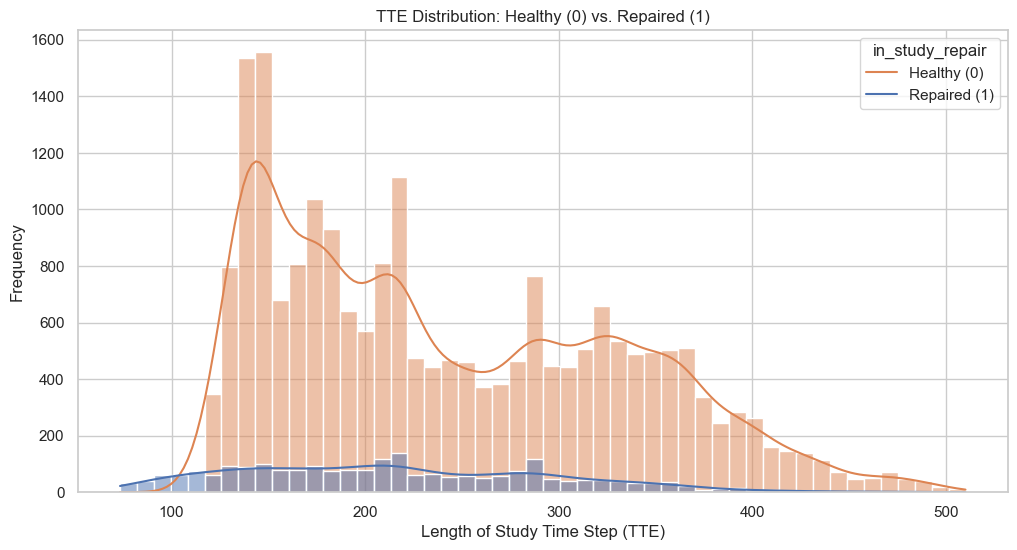

In [199]:
# TTE Distribution for Healthy vs. Repaired

plt.figure(figsize=(12, 6))
sns.histplot(data=train_repair, x="length_of_study_time_step", hue="in_study_repair", bins=50, kde=True, hue_order=[1, 0])
plt.xlabel("Length of Study Time Step (TTE)")
plt.ylabel("Frequency")
plt.title("TTE Distribution: Healthy (0) vs. Repaired (1)")
plt.legend(title="in_study_repair", labels=["Healthy (0)", "Repaired (1)"])
plt.show()

In order to visualize how failures are distributed over time, the dataset can be divided into discrete intervals (bins). In this case, 20 bins were chosen. This specific number aims to balance:

* **Granularity:** having enough intervals to capture relevant differences in failure times;

* **Interpretability:** avoiding an excessive number of bins, which can lead to very small counts per bin and obscure overall trends.

It is important to notice that it is not intended to predict the exact probability of failure in any given bin. Instead, the objective is to obseve when failures occured among the monitored trucks. Survival analysis methods, such as the Kaplan-Meier estimator, are more appropriate for estiamting failure probability or the hazar rate over continuous time. This analysis will be performed later.

In [200]:
# Create bins for TTE
num_bins = 20
tte_bins = np.linspace(train_repair["length_of_study_time_step"].min(), train_repair["length_of_study_time_step"].max(), num = num_bins + 1)
train_repair["tte_bin"] = pd.cut(train_repair["length_of_study_time_step"], bins = tte_bins, include_lowest = True)

In [201]:
# Contagem de falhas por intervalo
failure_distribution = train_repair[train_repair["in_study_repair"] == 1].groupby("tte_bin", observed = False).size().reset_index(name = "failure_count")
failure_distribution["failure_percentage"] = failure_distribution["failure_count"]/len(faulty_vehicles)

In [202]:
failure_distribution

tte_bin  failure_count  failure_percentage
0    (73.399, 95.23]            105            0.046215
1    (95.23, 117.06]            161            0.070863
2   (117.06, 138.89]            192            0.084507
3   (138.89, 160.72]            224            0.098592
4   (160.72, 182.55]            207            0.091109
5   (182.55, 204.38]            197            0.086708
6   (204.38, 226.21]            287            0.126320
7   (226.21, 248.04]            147            0.064701
8   (248.04, 269.87]            135            0.059419
9    (269.87, 291.7]            220            0.096831
10   (291.7, 313.53]            111            0.048856
11  (313.53, 335.36]            101            0.044454
12  (335.36, 357.19]             85            0.037412
13  (357.19, 379.02]             45            0.019806
14  (379.02, 400.85]             27            0.011884
15  (400.85, 422.68]             13            0.005722
16  (422.68, 444.51]              6            0.002641
17  (444.51, 466.34]              4            0.001761
18  (466.34, 488.17]              5            0.002201
19   (488.17, 510.0]              0            0.000000

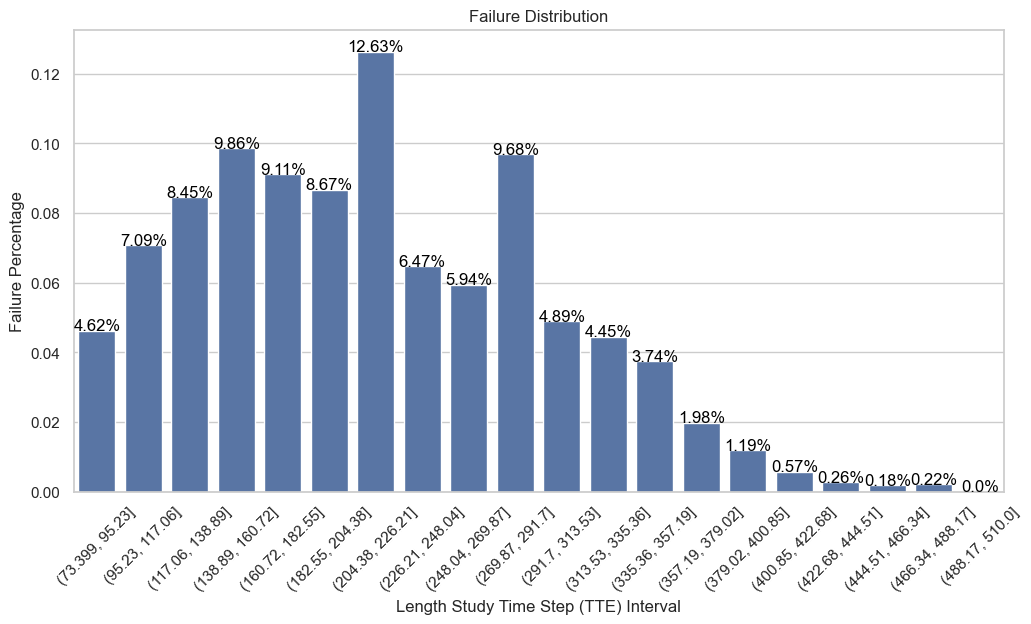

In [203]:
# Plot figure

plt.figure(figsize=(12, 6))
barplot = sns.barplot(data=failure_distribution, x = "tte_bin", y = "failure_percentage")

# Add labels for each bar
for index, row in failure_distribution.iterrows():
    barplot.text(index, row["failure_percentage"], f"{round(row["failure_percentage"] * 100, 2)}%",  color = "black", ha = "center")

plt.xlabel("Length Study Time Step (TTE) Interval")
plt.ylabel("Failure Percentage")
plt.title("Failure Distribution")
plt.xticks(rotation=45)
plt.show()

In [204]:
train_repair

vehicle_id  length_of_study_time_step  in_study_repair  \
0               0                      510.0                0   
1               2                      281.8                0   
2               3                      293.4                0   
3               4                      210.0                0   
4               5                      360.4                0   
...           ...                        ...              ...   
23545       33639                      137.4                0   
23546       33640                      124.6                0   
23547       33641                      123.0                0   
23548       33642                      126.6                0   
23549       33643                      130.2                0   

                tte_bin  
0       (488.17, 510.0]  
1       (269.87, 291.7]  
2       (291.7, 313.53]  
3      (204.38, 226.21]  
4      (357.19, 379.02]  
...                 ...  
23545  (117.06, 138.89]  
23546  (117.06, 138.89]  
23547  (117.06, 138.89]  
23548  (117.06, 138.89]  
23549  (117.06, 138.89]  

[23550 rows x 4 columns]

In [205]:
# Prepare the dataset
survival_analysis = train_repair[["vehicle_id","length_of_study_time_step","in_study_repair"]]
survival_analysis

vehicle_id  length_of_study_time_step  in_study_repair
0               0                      510.0                0
1               2                      281.8                0
2               3                      293.4                0
3               4                      210.0                0
4               5                      360.4                0
...           ...                        ...              ...
23545       33639                      137.4                0
23546       33640                      124.6                0
23547       33641                      123.0                0
23548       33642                      126.6                0
23549       33643                      130.2                0

[23550 rows x 3 columns]

In [206]:
# Rename columns for clarity
survival_analysis.columns = ["vehicle_id","tte", "event"]
survival_analysis

vehicle_id    tte  event
0               0  510.0      0
1               2  281.8      0
2               3  293.4      0
3               4  210.0      0
4               5  360.4      0
...           ...    ...    ...
23545       33639  137.4      0
23546       33640  124.6      0
23547       33641  123.0      0
23548       33642  126.6      0
23549       33643  130.2      0

[23550 rows x 3 columns]

In [207]:
# Compute mean/median TTE for failed vs. censored components
failed = survival_analysis[survival_analysis["event"] == 1]["tte"]
censored = survival_analysis[survival_analysis["event"] == 0]["tte"]

mean_failed = failed.mean()
median_failed = failed.median()
mean_censored = censored.mean()
median_censored = censored.median()

print(f"Mean TTE (Failed): {mean_failed:.2f}, Median TTE (Failed): {median_failed:.2f}")
print(f"Mean TTE (Censored): {mean_censored:.2f}, Median TTE (Censored): {median_censored:.2f}")

Mean TTE (Failed): 214.01, Median TTE (Failed): 208.40
Mean TTE (Censored): 243.16, Median TTE (Censored): 219.00


In [208]:
# Log-rank test to compare distributions
log_rank_test = statistics.logrank_test(failed, censored)
print(f"Log-rank test p-value: {log_rank_test.p_value:.4f}")

Log-rank test p-value: 0.0000


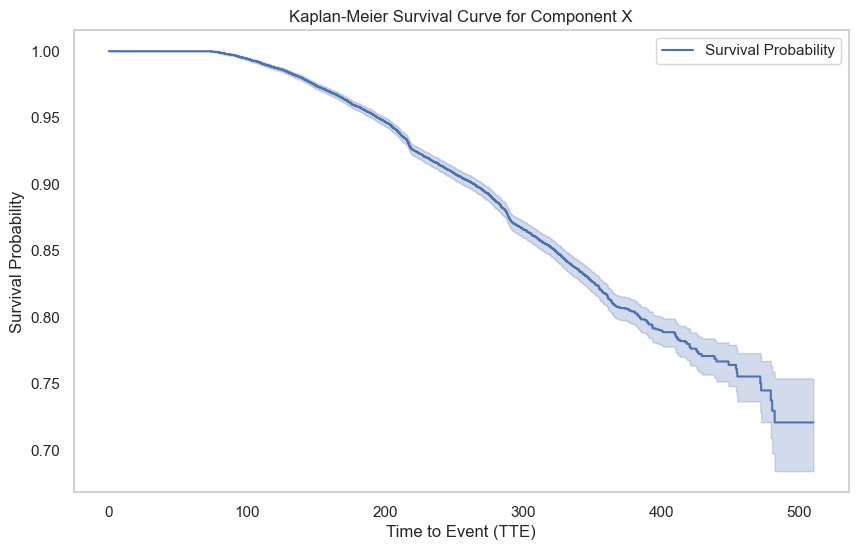

In [209]:
# Kaplan-Meier Survival Curve
kmf = KaplanMeierFitter()
plt.figure(figsize=(10, 6))

# Fit and plot survival function for the dataset
kmf.fit(durations=survival_analysis["tte"], event_observed=survival_analysis["event"], label="Survival Probability")
kmf.plot_survival_function()

plt.title("Kaplan-Meier Survival Curve for Component X")
plt.xlabel("Time to Event (TTE)")
plt.ylabel("Survival Probability")
plt.grid()
plt.show()

In [210]:
# Extract Kaplan-Meier survival table
survival_table = kmf.survival_function_
survival_table.reset_index(inplace=True)
survival_table.columns = ["TTE", "Survival Probability"]
print(survival_table.head())

    TTE  Survival Probability
0   0.0              1.000000
1  73.4              0.999958
2  73.6              0.999873
3  74.0              0.999745
4  74.8              0.999703


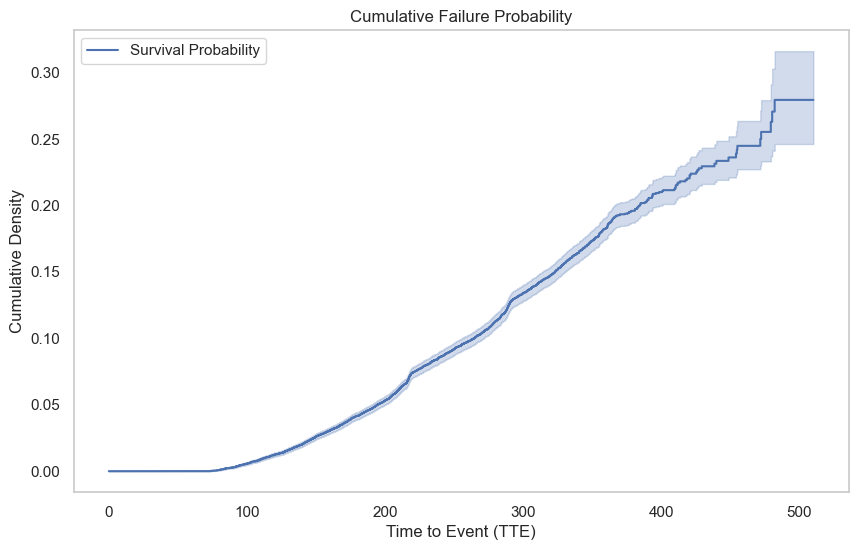

In [211]:
# Hazard Function (Approximate)
plt.figure(figsize=(10, 6))
kmf.plot_cumulative_density()
plt.title("Cumulative Failure Probability")
plt.xlabel("Time to Event (TTE)")
plt.ylabel("Cumulative Density")
plt.grid()
plt.show()

In [212]:
# Conditional Survival Probability Example
# Probability of surviving at least 50 more steps given survival up to TTE = 100
s_100 = kmf.survival_function_at_times(100).values[0]  # P(Surviving past 100)
s_150 = kmf.survival_function_at_times(150).values[0]  # P(Surviving past 150)
conditional_survival = s_150 / s_100
print(f"Probability of surviving 50 more steps given survival up to 100: {conditional_survival:.2f}")

Probability of surviving 50 more steps given survival up to 100: nan


In [213]:
survival_table

TTE  Survival Probability
0       0.0              1.000000
1      73.4              0.999958
2      73.6              0.999873
3      74.0              0.999745
4      74.8              0.999703
...     ...                   ...
1948  504.6              0.720727
1949  504.8              0.720727
1950  505.0              0.720727
1951  509.6              0.720727
1952  510.0              0.720727

[1953 rows x 2 columns]

In [214]:
# Define the TTE values of interest
time_points = [73.4, 100, 150, 200, 250, 300, 350, 400, 450, 510]

# Filter the survival table for these exact TTE values
selected_survival = survival_table[survival_table["TTE"].isin(time_points)].copy()

# Round survival probabilities for better readability
selected_survival["Survival Probability"] = selected_survival["Survival Probability"].round(4)

selected_survival

TTE  Survival Probability
1      73.4                1.0000
81    100.0                0.9943
305   150.0                0.9739
555   200.0                0.9469
805   250.0                0.9081
1055  300.0                0.8659
1305  350.0                0.8267
1555  400.0                0.7901
1952  510.0                0.7207

In [215]:
# Assuming the dataset is already loaded as "train_repair"
train_repair_sorted = train_repair.sort_values(by="length_of_study_time_step")

# Calculate number of at-risk trucks at each TTE
at_risk = []
total_trucks = len(train_repair_sorted)

for index, row in train_repair_sorted.iterrows():
    # At each row, the number of trucks at risk decreases if it"s a failure
    if row["in_study_repair"] == 1:
        # Failed truck, we add the current number of trucks at risk before updating
        at_risk.append(total_trucks)
    else:
        # Censored truck, just append the current number of trucks at risk
        at_risk.append(total_trucks)

    total_trucks -= 1  # Decrement the at-risk count as we move through the data

train_repair_sorted["at_risk"] = at_risk

# Number of trucks at risk at each TTE
print(train_repair_sorted[["length_of_study_time_step", "in_study_repair", "at_risk"]].head())

       length_of_study_time_step  in_study_repair  at_risk
12291                       73.4                1    23550
4992                        73.6                1    23549
17640                       73.6                1    23548
4605                        74.0                1    23547
6486                        74.0                1    23546


In [216]:
train_repair_sorted

vehicle_id  length_of_study_time_step  in_study_repair  \
12291       17604                       73.4                1   
4992         7168                       73.6                1   
17640       25215                       73.6                1   
4605         6615                       74.0                1   
6486         9317                       74.0                1   
...           ...                        ...              ...   
116           159                      504.8                0   
112           152                      504.8                0   
75            106                      505.0                0   
45             68                      509.6                0   
0               0                      510.0                0   

               tte_bin  at_risk  
12291  (73.399, 95.23]    23550  
4992   (73.399, 95.23]    23549  
17640  (73.399, 95.23]    23548  
4605   (73.399, 95.23]    23547  
6486   (73.399, 95.23]    23546  
...                ...      ...  
116    (488.17, 510.0]        5  
112    (488.17, 510.0]        4  
75     (488.17, 510.0]        3  
45     (488.17, 510.0]        2  
0      (488.17, 510.0]        1  

[23550 rows x 5 columns]

In [217]:
train_repair[train_repair["length_of_study_time_step"] >= 505]

vehicle_id  length_of_study_time_step  in_study_repair          tte_bin
0            0                      510.0                0  (488.17, 510.0]
45          68                      509.6                0  (488.17, 510.0]
75         106                      505.0                0  (488.17, 510.0]

### Validation - Repair Records

In [218]:
val_repair = pd.read_csv("validation_labels.csv")
val_repair

vehicle_id  class_label
0             10            0
1             16            0
2             18            0
3             23            0
4             45            0
...          ...          ...
5041       33596            0
5042       33601            0
5043       33605            0
5044       33612            0
5045       33625            0

[5046 rows x 2 columns]

Contrary to the train dataset, the validation dataset only contains two variables: one that identifies the vehicles, and other that classifies it as healthy or faulty. No information on the TTE is available.

In [219]:
# Presence of Missing and Duplicated Values.
print("Number of missing values:")
print(val_repair.isnull().sum())
print("Number of duplicated values: ", val_repair.duplicated().sum())

#Analysis of unique values.
print("Number of unique trucks:", val_repair["vehicle_id"].nunique())

Number of missing values:
vehicle_id     0
class_label    0
dtype: int64
Number of duplicated values:  0
Number of unique trucks: 5046


This dataset doesn"t contain any missing values nor any duplicated values. Each observation corresponds to a truck (and no trucks are repeated).

In [220]:
val_repair_class_counts = val_repair["class_label"].value_counts().sort_index()
val_repair_class_counts

class_label
0    4910
1      16
2      14
3      30
4      76
Name: count, dtype: int64

In the **training** dataset, the class label only contained two classes: 0 (healthy) or 1 (faulty).

In this dataset, however, 5 classes can be distinguished: 0, 1, 2, 3 and 4 (with 0 being the most common, and 2 the less frequent). These classes are related to readouts within a time window of: (more than 48), (48 to 24), (24 to 12), (12 to 6), and (6 to 0) time_step before the failure, respectively.

In [221]:
val_repair_class_percentages = val_repair_class_counts/val_repair_class_counts.sum()
val_repair_class_percentages

class_label
0    0.973048
1    0.003171
2    0.002774
3    0.005945
4    0.015061
Name: count, dtype: float64

In [222]:
val_repair_class_distribution = pd.DataFrame({
    "Class Label": sorted(val_repair["class_label"].unique()),
    "Count": val_repair_class_counts.values,
    "Percentage (%)": round(val_repair_class_percentages * 100, 2)
})

val_repair_class_distribution

Class Label  Count  Percentage (%)
class_label                                    
0                      0   4910           97.30
1                      1     16            0.32
2                      2     14            0.28
3                      3     30            0.59
4                      4     76            1.51

Finally, it is important to verify whether any vehicles (identified by vehicle_id) in the train_repair dataset are also present in the val_repair dataset, and vice versa. This validation step ensures the integrity of the dataset split and is essential for accurately assessing the evaluation metrics during the modeling phase.

In [223]:
repair_common_vehicles = set(train_repair["vehicle_id"]) & set(val_repair["vehicle_id"])

if repair_common_vehicles:
    print("Vehicles in train_repair that also appear in val_repair:")
    print(train_repair[train_repair["vehicle_id"].isin(val_repair["vehicle_id"])])

    print("\nVehicles in val_repair that also appear in train_repair:")
    print(val_repair[val_repair["vehicle_id"].isin(train_repair["vehicle_id"])])
else:
    print("No trucks are present in both datasets.")

No trucks are present in both datasets.


### Test - Repair Records

In [224]:
test_repair = pd.read_csv("test_labels.csv")
test_repair

vehicle_id  class_label
0              1            0
1              6            0
2              7            0
3              9            0
4             11            0
...          ...          ...
5040       33617            0
5041       33619            0
5042       33632            0
5043       33634            0
5044       33638            0

[5045 rows x 2 columns]

Contrary to the train dataset, the test dataset only contains two variables: one that identifies the vehicles, and other that classifies it as healthy or faulty. No information on the TTE is available.

In [225]:
# Presence of Missing and Duplicated Values.
print("Number of missing values:")
print(test_repair.isnull().sum())
print("Number of duplicated values: ", test_repair.duplicated().sum())

#Analysis of unique values.
print("Number of unique trucks:", test_repair["vehicle_id"].nunique())

Number of missing values:
vehicle_id     0
class_label    0
dtype: int64
Number of duplicated values:  0
Number of unique trucks: 5045


This dataset doesn"t contain any missing values nor any duplicated values. Each observation corresponds to a truck (and no trucks are repeated).

In [226]:
test_repair_class_counts = test_repair["class_label"].value_counts().sort_index()
test_repair_class_counts

class_label
0    4903
1      26
2      15
3      41
4      60
Name: count, dtype: int64

In the **training** dataset, the class label only contained two classes: 0 (healthy) or 1 (faulty).

In this dataset, however, 5 classes can be distinguished: 0, 1, 2, 3 and 4 (with 0 being the most common, and 2 the less frequent). These classes are related to readouts within a time window of: (more than 48), (48 to 24), (24 to 12), (12 to 6), and (6 to 0) time_step before the failure, respectively.

This **test** dataset follows the same structure as the validation dataset.

In [227]:
test_repair_class_percentages = test_repair_class_counts/test_repair_class_counts.sum()
test_repair_class_percentages

class_label
0    0.971853
1    0.005154
2    0.002973
3    0.008127
4    0.011893
Name: count, dtype: float64

In [228]:
test_repair_class_distribution = pd.DataFrame({
    "Class Label": sorted(test_repair["class_label"].unique()),
    "Count": test_repair_class_counts.values,
    "Percentage (%)": round(test_repair_class_percentages * 100, 2)
})

test_repair_class_distribution

Class Label  Count  Percentage (%)
class_label                                    
0                      0   4903           97.19
1                      1     26            0.52
2                      2     15            0.30
3                      3     41            0.81
4                      4     60            1.19

In [229]:
# Check common vehicle_ids between datasets
repair_common_train_val = set(train_repair["vehicle_id"]) & set(val_repair["vehicle_id"])
repair_common_train_test = set(train_repair["vehicle_id"]) & set(test_repair["vehicle_id"])
repair_common_val_test = set(val_repair["vehicle_id"]) & set(test_repair["vehicle_id"])

# Check if train vehicles are in validation
if repair_common_train_val:
    print("Vehicles in train_repair that also appear in val_repair:")
    print(train_repair[train_repair["vehicle_id"].isin(val_repair["vehicle_id"])])
else:
    print("No trucks are present in both train_repair and val_repair.")

# Check if train vehicles are in test
if repair_common_train_test:
    print("\nVehicles in train_repair that also appear in test_repair:")
    print(train_repair[train_repair["vehicle_id"].isin(test_repair["vehicle_id"])])
else:
    print("\nNo trucks are present in both train_repair and test_repair.")

# Check if validation vehicles are in test (if relevant)
if repair_common_val_test:
    print("\nVehicles in val_repair that also appear in test_repair:")
    print(val_repair[val_repair["vehicle_id"].isin(test_repair["vehicle_id"])])
else:
    print("\nNo trucks are present in both val_repair and test_repair.")

No trucks are present in both train_repair and val_repair.

No trucks are present in both train_repair and test_repair.

No trucks are present in both val_repair and test_repair.


## Truck Specifications and Failures

This section aims to analyze the relationship between different specification components and the occurrence of truck failures. To achieve this, the training datasets from both the Repair Records and Vehicle Specifications data sources will be utilized. Since the primary objective of this phase is to identify patterns and potential associations rather than evaluate model performance, restricting the analysis to the training data ensures that insights are derived from the same dataset that will later be used for model development. While other datasets are examined for data quality aspects such as missing values and inconsistencies, the statistical investigation of relationships is confined to the training set to prevent premature exposure of validation data, therefore maintaining its integrity for subsequent model evaluation.

In particular, the variations in the categorical distributions of specifications between healthy and faulty trucks will be examined. The process will, therefore, involve calculating the overall proportion of each category for a given specification, and then comparing these proportions between trucks that experienced failures and those that did not, followed by a Chi-Square test to determine the statistical significance of the observed differences. Finally, if an association is identified, the Cramér"s V will be computed to measure the strength of that association.

The first step involves merging these two datasets on the shared variable "vehicle_id".

In [230]:
train_repair = pd.read_csv("train_tte.csv")
train_spec = pd.read_csv("train_specifications.csv")

train_repair_spec = train_spec.merge(train_repair, on = "vehicle_id")
train_repair_spec

vehicle_id Spec_0 Spec_1 Spec_2 Spec_3 Spec_4 Spec_5 Spec_6 Spec_7  \
0               0   Cat0   Cat0   Cat0   Cat0   Cat0   Cat0   Cat0   Cat0   
1               2   Cat0   Cat1   Cat1   Cat0   Cat0   Cat0   Cat0   Cat1   
2               3   Cat0   Cat1   Cat1   Cat1   Cat0   Cat0   Cat0   Cat1   
3               4   Cat0   Cat0   Cat2   Cat1   Cat0   Cat0   Cat0   Cat1   
4               5   Cat0   Cat2   Cat2   Cat0   Cat0   Cat0   Cat0   Cat1   
...           ...    ...    ...    ...    ...    ...    ...    ...    ...   
23545       33639   Cat0   Cat1   Cat1   Cat0   Cat0   Cat0   Cat1   Cat4   
23546       33640   Cat0  Cat14   Cat1   Cat3   Cat0   Cat0   Cat1   Cat4   
23547       33641   Cat0   Cat1   Cat1   Cat0   Cat0   Cat0   Cat1   Cat4   
23548       33642   Cat0   Cat1   Cat1   Cat0   Cat0   Cat0   Cat1   Cat4   
23549       33643   Cat0   Cat0   Cat2   Cat0   Cat0   Cat0   Cat1   Cat4   

       length_of_study_time_step  in_study_repair  
0                          510.0                0  
1                          281.8                0  
2                          293.4                0  
3                          210.0                0  
4                          360.4                0  
...                          ...              ...  
23545                      137.4                0  
23546                      124.6                0  
23547                      123.0                0  
23548                      126.6                0  
23549                      130.2                0  

[23550 rows x 11 columns]

An initial visual inspection of how the categorical variables are distributed between these faulty and healthy trucks is provided. In addition, this visualization illustrates the imbalance problem in the dataset.

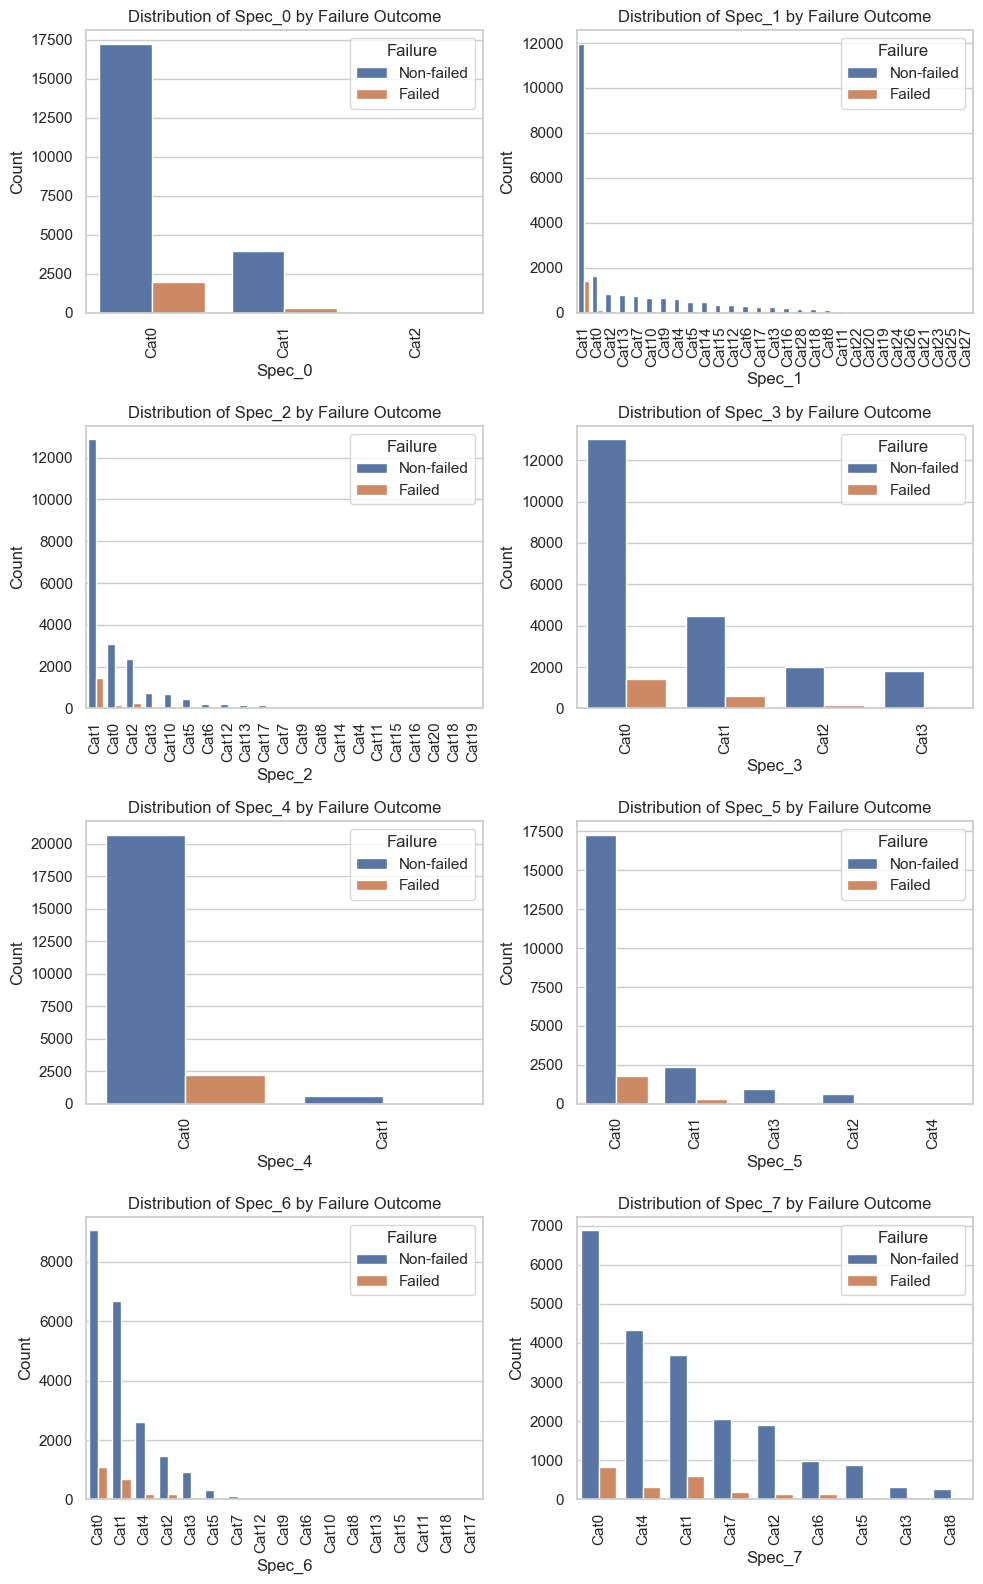

In [231]:
spec_columns = [col for col in train_repair_spec.columns if col.startswith("Spec_")]

num_specs = len(spec_columns)

cols = 2
rows = math.ceil(num_specs / cols)

plt.figure(figsize=(5 * cols, 4 * rows))

for i, spec in enumerate(spec_columns, 1):
    plt.subplot(rows, cols, i)

    # Order categories by frequency
    order = train_repair_spec[spec].value_counts().index
    sns.countplot(data=train_repair_spec, x=spec, hue="in_study_repair", order=order)

    plt.title(f"Distribution of {spec} by Failure Outcome")
    plt.xlabel(spec)
    plt.ylabel("Count")
    plt.legend(title="Failure", labels=["Non-failed", "Failed"])
    plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

Before applying the Chi-Square test, contingency tables for each specification will be constructed to summarize the frequency distribution of categories with respect to repair outcomes. To ensure the validity of the Chi-Square test, Cochran"s condition is going to be checked by calculating the expected frequencies for each cell in the tables. In the cases where the conditions are violated -- specifically, if any expected frequency was less than 1 or if more than 20\% of the cells had expected frequencies below 5 -- low-frequency categories are going to be combined into an "Other" category to maintain the validity of the subsequent statistical analysis.

In [232]:
import numpy as np
import pandas as pd

def check_cochran_condition(expected_frequencies, row_labels, threshold=5, ignore_rows=None):
    """
    Check Cochran's condition while ignoring rows in ignore_rows.
    expected_frequencies: 2D numpy array (rows x columns)
    row_labels: index labels of the contingency table (list-like)
    """
    if ignore_rows is None:
        ignore_rows = []
    # Determine the indices to include (i.e. not in ignore_rows)
    valid_indices = [i for i, label in enumerate(row_labels) if label not in ignore_rows]
    # Only check the expected frequencies for these rows
    valid_expected = expected_frequencies[valid_indices, :]
    low_freq_mask = valid_expected < 1
    below_five_mask = valid_expected < threshold
    violations = {
        "low_freq_violations": low_freq_mask.any(),
        "below_five_violations": (below_five_mask.sum() / valid_expected.size) > 0.2
    }
    return violations

def combine_low_freq_categories(contingency_table, threshold=5):
    combined_table = contingency_table.copy()

    # Ensure that the "Other" row exists with 0 in all columns.
    if "Other" not in combined_table.index:
        combined_table.loc["Other"] = [0] * combined_table.shape[1]
    else:
        # Fill any missing values in "Other" with 0
        combined_table.loc["Other"] = combined_table.loc["Other"].fillna(0)

    # Use a list of columns to avoid issues when modifying the table.
    for column in list(combined_table.columns):
        # Only consider rows other than "Other"
        rows_to_check = combined_table.index.difference(["Other"])
        # Identify rows where the value is below threshold
        low_freq_rows = combined_table.loc[rows_to_check, column][combined_table.loc[rows_to_check, column] < threshold]

        if not low_freq_rows.empty:
            # Add the low-frequency sum to the "Other" row for that column
            combined_table.loc["Other", column] += low_freq_rows.sum()
            # Drop the low-frequency rows from the table
            combined_table.drop(index=low_freq_rows.index, inplace=True)

    return combined_table

# Example usage within loop:
for spec in spec_columns:
    print(f"Contingency Table for {spec}:")
    contingency_table = pd.crosstab(train_repair_spec[spec], train_repair_spec["in_study_repair"])
    print(contingency_table)

    # Calculate expected frequencies from the original table
    row_totals = contingency_table.sum(axis=1).values
    col_totals = contingency_table.sum(axis=0).values
    grand_total = contingency_table.values.sum()
    expected_frequencies = np.outer(row_totals, col_totals) / grand_total
    rounded_expected_frequencies = np.round(expected_frequencies, 2)

    print("Rounded Expected Frequencies:")
    for row in rounded_expected_frequencies:
        print(" ".join([f"{val:.2f}" for val in row]))

    # Exclude "Other" row if present when checking conditions.
    violations = check_cochran_condition(rounded_expected_frequencies, contingency_table.index, ignore_rows=["Other"])

    if violations["low_freq_violations"]:
        print("Warning: Some expected frequencies are less than 1. Cochran condition is violated!")
    if violations["below_five_violations"]:
        print("Warning: More than 20% of expected frequencies are less than 5. Cochran condition is violated!")
    if not violations["low_freq_violations"] and not violations["below_five_violations"]:
        print("Cochran condition is satisfied (no expected frequencies < 1 and no more than 20% < 5).")

    # If Cochran condition is violated, combine categories and check again
    iteration = 1
    combined_table = contingency_table.copy()  # Start with the original table
    while violations["low_freq_violations"] or violations["below_five_violations"]:
        print(f"Attempt {iteration} to combine low-frequency categories...")
        combined_table = combine_low_freq_categories(combined_table, threshold=5)

        # Recalculate expected frequencies after combining categories
        row_totals_combined = combined_table.sum(axis=1).values
        col_totals_combined = combined_table.sum(axis=0).values
        grand_total_combined = combined_table.values.sum()
        expected_frequencies_combined = np.outer(row_totals_combined, col_totals_combined) / grand_total_combined
        rounded_expected_frequencies_combined = np.round(expected_frequencies_combined, 2)

        print("Updated Contingency Table after Combining Categories:")
        print(combined_table)
        print("Updated Rounded Expected Frequencies:")
        for row in rounded_expected_frequencies_combined:
            print(" ".join([f"{val:.2f}" for val in row]))

        # Now, when checking the Cochran condition, ignore the "Other" row.
        violations = check_cochran_condition(rounded_expected_frequencies_combined, combined_table.index, ignore_rows=["Other"])
        if violations["low_freq_violations"]:
            print("Warning: Some expected frequencies (excluding 'Other') are less than 1. Cochran condition is still violated!")
        if violations["below_five_violations"]:
            print("Warning: More than 20% of expected frequencies (excluding 'Other') are less than 5. Cochran condition is still violated!")
        if not violations["low_freq_violations"] and not violations["below_five_violations"]:
            print("Cochran condition is satisfied after combining categories (excluding 'Other').")
        iteration += 1

    print("\n")

Contingency Table for Spec_0:
in_study_repair      0     1
Spec_0                      
Cat0             17244  1977
Cat1              3998   293
Cat2                36     2
Rounded Expected Frequencies:
17366.64 1854.36
3877.02 413.98
34.33 3.67
Cochran condition is satisfied (no expected frequencies < 1 and no more than 20% < 5).


Contingency Table for Spec_1:
in_study_repair      0     1
Spec_1                      
Cat0              1623   135
Cat1             11962  1400
Cat10              676    73
Cat11              100     8
Cat12              359    25
Cat13              780    80
Cat14              473    21
Cat15              368    32
Cat16              214     6
Cat17              263    48
Cat18              153     8
Cat19               31     2
Cat2               838    97
Cat20               37     1
Cat21               10     0
Cat22               30    16
Cat23                4     1
Cat24               22     5
Cat25                1     1
Cat26               12  

In [233]:
# Apply Chi-Square test for each specification
for spec in spec_columns:
    print(f"Chi-Square Test for {spec}:")

    # Create contingency table
    contingency_table = pd.crosstab(train_repair_spec[spec], train_repair_spec["in_study_repair"])

    # Apply Chi-Square test
    chi2, p, dof, expected = stats.chi2_contingency(contingency_table)

    # Interpret the result
    print(f"Chi-Square Statistic: {chi2:.2f}")
    print(f"Degrees of Freedom: {dof}")
    print(f"P-Value: {p:.5f}")

    # Interpretation of p-value
    if p < 0.05:
        print("Reject the null hypothesis: It is possible to conclude that there is a significant association between the variables, for a significance level of 5%.")
    else:
        print("Fail to reject the null hypothesis: It is possible to conclude that there is no significant association between the variables, for a significance level of 5%.")

    print("\n")

Chi-Square Test for Spec_0:
Chi-Square Statistic: 48.94
Degrees of Freedom: 2
P-Value: 0.00000
Reject the null hypothesis: It is possible to conclude that there is a significant association between the variables, for a significance level of 5%.


Chi-Square Test for Spec_1:
Chi-Square Statistic: 158.62
Degrees of Freedom: 28
P-Value: 0.00000
Reject the null hypothesis: It is possible to conclude that there is a significant association between the variables, for a significance level of 5%.


Chi-Square Test for Spec_2:
Chi-Square Statistic: 208.03
Degrees of Freedom: 20
P-Value: 0.00000
Reject the null hypothesis: It is possible to conclude that there is a significant association between the variables, for a significance level of 5%.


Chi-Square Test for Spec_3:
Chi-Square Statistic: 115.11
Degrees of Freedom: 3
P-Value: 0.00000
Reject the null hypothesis: It is possible to conclude that there is a significant association between the variables, for a significance level of 5%.


Chi-Squ

In [234]:
# Define a helper function to merge low-frequency categories until Cochran"s condition is satisfied.
def merge_until_cochran_satisfied(contingency_table, threshold=5):
    merged_table = contingency_table.copy()
    # Compute initial expected frequencies.
    row_totals = merged_table.sum(axis=1).values
    col_totals = merged_table.sum(axis=0).values
    grand_total = merged_table.values.sum()
    expected_frequencies = np.outer(row_totals, col_totals) / grand_total
    rounded_expected = np.round(expected_frequencies, 2)
    # Check violations while ignoring the "Other" row.
    violations = check_cochran_condition(rounded_expected, merged_table.index, ignore_rows=["Other"])
    iteration = 1
    while violations["low_freq_violations"] or violations["below_five_violations"]:
        merged_table = combine_low_freq_categories(merged_table, threshold=threshold)
        row_totals = merged_table.sum(axis=1).values
        col_totals = merged_table.sum(axis=0).values
        grand_total = merged_table.values.sum()
        expected_frequencies = np.outer(row_totals, col_totals) / grand_total
        rounded_expected = np.round(expected_frequencies, 2)
        violations = check_cochran_condition(rounded_expected, merged_table.index, ignore_rows=["Other"])
        iteration += 1
    # Return the final merged table and its expected frequencies as a DataFrame.
    expected_df = pd.DataFrame(rounded_expected, index=merged_table.index, columns=merged_table.columns)
    return merged_table, expected_df

# Residual analysis for each specification.
for spec in spec_columns:
    print(f"\nResidual Analysis for {spec}:")
    # Create the original contingency table.
    contingency_table = pd.crosstab(train_repair_spec[spec], train_repair_spec["in_study_repair"])

    # Merge categories until the Cochran condition is satisfied.
    merged_table, expected_df = merge_until_cochran_satisfied(contingency_table, threshold=5)

    # Compute standardized residuals.
    # Standardized residual = (Observed - Expected) / sqrt(Expected)
    standardized_residuals = (merged_table - expected_df) / np.sqrt(expected_df)
    standardized_residuals = standardized_residuals.round(2)

    # Print the merged contingency table, expected frequencies, and residuals.
    print("Merged Contingency Table:")
    print(merged_table)
    print("\nExpected Frequencies:")
    print(expected_df)
    print("\nStandardized Residuals:")
    print(standardized_residuals)

#Interpretation:
print("\nInterpretation:")
print("Cells with standardized residuals greater than 1.96 or less than -1.96 indicate statistically significant deviations")
print("from the expected frequencies at the 5% significance level. A positive residual suggests that the observed")
print("frequency is higher than expected, implying that the component in that cell is more strongly associated with")
print("failure (or with the alternative outcome) than would be predicted by chance. A negative residual")
print("indicates that the observed frequency is lower than expected.")
print("This residual analysis provides information into which specification components contribute most to the")
print("overall association between truck specifications and failure occurrences.\n")


Residual Analysis for Spec_0:
Merged Contingency Table:
in_study_repair      0     1
Spec_0                      
Cat0             17244  1977
Cat1              3998   293
Cat2                36     2

Expected Frequencies:
in_study_repair         0        1
Spec_0                            
Cat0             17366.64  1854.36
Cat1              3877.02   413.98
Cat2                34.33     3.67

Standardized Residuals:
in_study_repair     0     1
Spec_0                     
Cat0            -0.93  2.85
Cat1             1.94 -5.95
Cat2             0.29 -0.87

Residual Analysis for Spec_1:
Merged Contingency Table:
in_study_repair      0     1
Spec_1                      
Cat0              1623   135
Cat1             11962  1400
Cat10              676    73
Cat11              100     8
Cat12              359    25
Cat13              780    80
Cat14              473    21
Cat15              368    32
Cat16              214     6
Cat17              263    48
Cat18              153     8
C

As the Chi-Square test for all specifications showed statistical significance (for a 5% significance level), Cramér"s V is calculated for each specification to measure the strength of the identified association.

In [235]:
# Function to calculate Cramér"s V
def cramers_v(chi2_stat, n, table):
    # Get the smaller dimension of the contingency table
    min_dim = min(table.shape) - 1
    return np.sqrt(chi2_stat / (n * min_dim))

# Apply Cramér"s V for each specification
for spec in spec_columns:
    print(f"Cramér's V Test for {spec}:")

    # Create contingency table
    contingency_table = pd.crosstab(train_repair_spec[spec], train_repair_spec["in_study_repair"])

    # Apply Chi-Square test
    chi2, p, dof, expected = stats.chi2_contingency(contingency_table)

    # Calculate Cramér"s V
    n = contingency_table.sum().sum()  # Total sample size
    v = cramers_v(chi2, n, contingency_table)

    # Print the result
    print(f"Cramér's V: {v:.3f}")
    print("\n")

Cramér's V Test for Spec_0:
Cramér's V: 0.046


Cramér's V Test for Spec_1:
Cramér's V: 0.082


Cramér's V Test for Spec_2:
Cramér's V: 0.094


Cramér's V Test for Spec_3:
Cramér's V: 0.070


Cramér's V Test for Spec_4:
Cramér's V: 0.015


Cramér's V Test for Spec_5:
Cramér's V: 0.029


Cramér's V Test for Spec_6:
Cramér's V: 0.060


Cramér's V Test for Spec_7:
Cramér's V: 0.108




All associations are very weak (as the values are close to zero).

In summary, while specification factors (for all cases) contribute to failure patterns (i.e., truck specifications are statistically related to repair outcomes), the weak strength of these associations suggests that more complex models or additional variables may be required to improve prediction accuracy for truck failures.

# Data Preprocessing

In [236]:
# Constants
SEED = 42

# Load datasets
train_op = pd.read_csv("train_op_clean_3.csv").drop(columns=["Unnamed: 0"], errors="ignore")
train_spec = pd.read_csv("train_specifications.csv")
train_tte = pd.read_csv("train_tte.csv")

val_op = pd.read_csv("val_op_clean3.csv").drop(columns=["Unnamed: 0"], errors="ignore")
val_spec = pd.read_csv("validation_specifications.csv")
val_labels = pd.read_csv("validation_labels.csv")

test_op = pd.read_csv("test_op_clean3.csv").drop(columns=["Unnamed: 0"], errors="ignore")
test_spec = pd.read_csv("test_specifications.csv")
test_labels = pd.read_csv("test_labels.csv")

print("Train / Val / Test data loaded.")

Train / Val / Test data loaded.


In [237]:
# Encode specs

def encode_specs(df_spec):
    return df_spec.set_index("vehicle_id").applymap(lambda x: int(x.replace("Cat", "")))

train_spec_enc = encode_specs(train_spec)
val_spec_enc = encode_specs(val_spec)
test_spec_enc = encode_specs(test_spec)

In [238]:
# Merge train + compute labels

train_df = (
    train_op
    .merge(train_spec_enc, left_on="vehicle_id", right_index=True, how="left")
    .merge(train_tte, on="vehicle_id", how="left")
    .fillna(0)
)

# Compute remaining TTE and class_label
train_df["remaining_tte"] = train_df["length_of_study_time_step"] - train_df["time_step"]
bins = [-np.inf, 0, 6, 12, 24, 48, np.inf]
labels = [-1, 4, 3, 2, 1, 0]
train_df["class_label"] = pd.cut(train_df["remaining_tte"], bins=bins, labels=labels).astype(int)

# Drop irrelevant rows
mask = (train_df["class_label"] >= 0) & ~(
    (train_df["in_study_repair"] == 0) & (train_df["remaining_tte"] <= 48)
)
train_df = train_df[mask].reset_index(drop=True)

In [239]:
# Compute final class per vehicle
final_labels = (
    train_df
    .sort_values(["vehicle_id","time_step"])
    .groupby("vehicle_id")["class_label"]
    .last()
)

print("Number of vehicles ending in each class:")
print(final_labels.value_counts().sort_index())

Number of vehicles ending in each class:
class_label
0    21287
1       31
2       70
3      167
4     1994
Name: count, dtype: int64


In [240]:
# Augmentation

# Identify vehicles that end in class 4
class4_vids = final_labels[final_labels==4].index.tolist()
print(f"{len(class4_vids)} vehicles end in class 4")

new_rows = []
new_vid = train_df["vehicle_id"].max() + 1

for vid in class4_vids:
    grp = (
        train_df[train_df["vehicle_id"]==vid]
        .sort_values("time_step")
        .reset_index(drop=True)
    )
    # find first index where class_label == k, for k in 1,2,3
    for k in [1,2,3]:
        idxs = grp.index[grp["class_label"]==k]
        if len(idxs)==0:
            continue
        cut = idxs[0] + 1         # include that row
        new_grp = grp.iloc[:cut].copy()
        new_grp["vehicle_id"] = new_vid
        new_vid += 1
        new_rows.append(new_grp)

# Concatenate
aug = pd.concat([train_df] + new_rows, ignore_index=True)

# Check new vehicle-level distribution
aug_final = (
    aug.sort_values(["vehicle_id","time_step"])
       .groupby("vehicle_id")["class_label"]
       .last()
)
print("After augmentation, vehicles ending in each class:")
print(aug_final.value_counts().sort_index())

1994 vehicles end in class 4
After augmentation, vehicles ending in each class:
class_label
0    21287
1     2009
2     2001
3     1913
4     1994
Name: count, dtype: int64


In [241]:
# Z-score standardization (Standardize operational variables)

# Identify operational features (float) to standardize
exclude_feats = ["time_step", "length_of_study_time_step", "in_study_repair", "remaining_tte", "class_label"]
ops_feats = [
    col for col in train_df.select_dtypes(include='float').columns
    if col not in exclude_feats
]

# Fit scaler on train operational features
scaler = StandardScaler()
train_df[ops_feats] = scaler.fit_transform(train_df[ops_feats])
train_df

vehicle_id  time_step     171_0     666_0     427_0     837_0  \
0                0       11.2 -1.842363 -0.949454 -1.707999 -0.580688   
1                0       19.6 -0.350314 -0.449052 -0.301252 -0.513936   
2                0       28.0  0.409629  0.075821  0.370195 -0.405779   
3                0       31.2  1.795431  0.647736  1.691191 -0.403636   
4                0       33.6 -0.024117  0.297462  0.018209  0.002029   
...            ...        ...       ...       ...       ...       ...   
782944       33643       61.6 -0.378710 -0.624161 -0.309044 -0.554280   
782945       33643       67.6 -0.122837 -0.579337 -0.036367 -0.520670   
782946       33643       75.0  0.468904 -0.305089  0.493865 -0.510467   
782947       33643       78.6  0.126681 -0.240506  0.060197 -0.496663   
782948       33643       82.0  0.240506 -0.421814  0.238879 -0.542276   

           309_0     100_0     167_0     167_1  ...  Spec_2  Spec_3  Spec_4  \
0      -0.235828 -1.221285  1.117797 -1.118156  ...       0       0       0   
1      -0.235828 -0.455872  1.121721 -1.122082  ...       0       0       0   
2      -0.235828 -0.470897  1.121721 -1.122082  ...       0       0       0   
3      -0.235828 -0.231116  1.121721 -1.122082  ...       0       0       0   
4      -0.235828 -0.606941  1.121721 -1.122082  ...       0       0       0   
...          ...       ...       ...       ...  ...     ...     ...     ...   
782944 -0.235828  0.184848 -0.420783  0.423457  ...       2       0       0   
782945 -0.235828  0.425544 -0.212089  0.214873  ...       2       0       0   
782946 -0.229933  0.671011 -0.099171  0.102033  ...       2       0       0   
782947 -0.216177  0.065437 -0.076996  0.080015  ...       2       0       0   
782948 -0.235828  0.470337 -0.021902  0.025028  ...       2       0       0   

        Spec_5  Spec_6  Spec_7  length_of_study_time_step  in_study_repair  \
0            0       0       0                      510.0                0   
1            0       0       0                      510.0                0   
2            0       0       0                      510.0                0   
3            0       0       0                      510.0                0   
4            0       0       0                      510.0                0   
...        ...     ...     ...                        ...              ...   
782944       0       1       4                      130.2                0   
782945       0       1       4                      130.2                0   
782946       0       1       4                      130.2                0   
782947       0       1       4                      130.2                0   
782948       0       1       4                      130.2                0   

        remaining_tte  class_label  
0               498.8            0  
1               490.4            0  
2               482.0            0  
3               478.8            0  
4               476.4            0  
...               ...          ...  
782944           68.6            0  
782945           62.6            0  
782946           55.2            0  
782947           51.6            0  
782948           48.2            0  

[782949 rows x 44 columns]

k        Inertia     Silhouette       DBI         CHI
-------------------------------------------------------
2     1360483.08         0.4300    1.2319    10391.78
3     1274888.28         0.1668    1.8557     6334.93
4     1156173.44         0.1791    1.9421     5462.59
5     1063640.81         0.1889    1.6803     4965.23
6     1009628.42         0.1889    1.7016     4436.41
7      821747.69         0.1897    1.4534     5439.17
8      781565.08         0.1829    1.4690     5074.53
9      756248.97         0.1784    1.5430     4687.17
10     724355.89         0.1777    1.4755     4464.78

Selected best number of clusters (k): 2


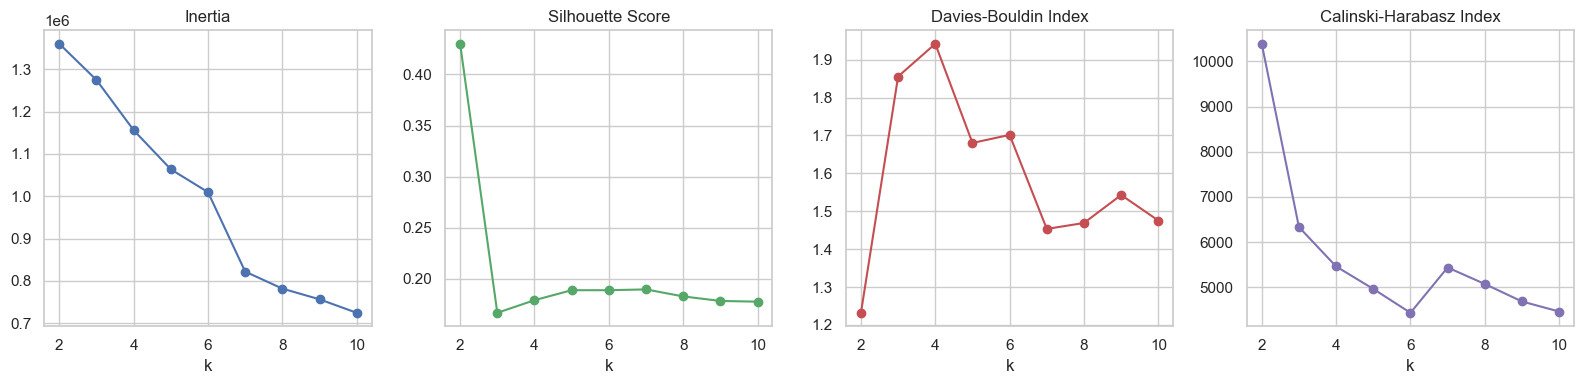

In [242]:
# Clustering

# Step 1: Aggregate standardized operational features
ops_agg = train_df.groupby("vehicle_id")[ops_feats].agg(["mean", "std"])
ops_agg.columns = ["_".join(c) for c in ops_agg.columns]

# Step 2: Merge with encoded spec features
veh_feats = ops_agg.merge(train_spec_enc, left_index=True, right_index=True).fillna(0)

# Step 3: Prepare data for clustering
X = veh_feats.values
MAX_K = 10
K_range = range(2, min(MAX_K, len(X)) + 1)

# Step 4: Evaluate clustering metrics
inertias, sil_scores, dbi_scores, chi_scores = [], [], [], []

print(f"{'k':<4}{'Inertia':>12}{'Silhouette':>15}{'DBI':>10}{'CHI':>12}")
print("-" * 55)

for k in K_range:
    kmeans = KMeans(n_clusters=k, n_init="auto", random_state=42)
    labels = kmeans.fit_predict(X)

    inertia = kmeans.inertia_
    sil = silhouette_score(X, labels)
    dbi = davies_bouldin_score(X, labels)
    chi = calinski_harabasz_score(X, labels)

    inertias.append(inertia)
    sil_scores.append(sil)
    dbi_scores.append(dbi)
    chi_scores.append(chi)

    print(f"{k:<4}{inertia:>12.2f}{sil:>15.4f}{dbi:>10.4f}{chi:>12.2f}")

# Step 5: Choose best k using CHI
best_k_idx = int(np.argmax(chi_scores))
best_k = K_range[best_k_idx]

print("\n" + "="*60)
print(f"Selected best number of clusters (k): {best_k}")
print("="*60)

# Step 6: Final clustering
final_kmeans = KMeans(n_clusters=best_k, n_init="auto", random_state=42)
veh_feats["cluster"] = final_kmeans.fit_predict(X)

# Step 7: Merge cluster labels back to train_df
train_df = train_df.merge(veh_feats["cluster"], left_on="vehicle_id", right_index=True)

# Step 8: Plot metrics
plt.figure(figsize=(16, 4))

plt.subplot(1, 4, 1)
plt.plot(K_range, inertias, 'b-o')
plt.title("Inertia")
plt.xlabel("k")

plt.subplot(1, 4, 2)
plt.plot(K_range, sil_scores, 'g-o')
plt.title("Silhouette Score")
plt.xlabel("k")

plt.subplot(1, 4, 3)
plt.plot(K_range, dbi_scores, 'r-o')
plt.title("Davies-Bouldin Index")
plt.xlabel("k")

plt.subplot(1, 4, 4)
plt.plot(K_range, chi_scores, 'm-o')
plt.title("Calinski-Harabasz Index")
plt.xlabel("k")

plt.tight_layout()
plt.show()

In [243]:
# Process val/test

val_df = (
    val_op
    .merge(val_spec_enc, left_on="vehicle_id", right_index=True, how="left")
    .merge(val_labels, on="vehicle_id", how="left")
    .fillna(0)
)

test_df = (
    test_op
    .merge(test_spec_enc, left_on="vehicle_id", right_index=True, how="left")
    .merge(test_labels, on="vehicle_id", how="left")
    .fillna(0)
)

def assign_cluster(df_op, df_spec_enc):
    # Step 1: Standardize operational features using pre-fit scaler
    df_op_std = df_op.copy()
    df_op_std[ops_feats] = scaler.transform(df_op_std[ops_feats])

    # Step 2: Aggregate standardized operational features
    ops_agg = df_op_std.groupby("vehicle_id")[ops_feats].agg(["mean", "std"])
    ops_agg.columns = ["_".join(c) for c in ops_agg.columns]

    # Step 3: Merge with unstandardized encoded specs
    features = ops_agg.merge(df_spec_enc, left_index=True, right_index=True).fillna(0)

    # Step 4: Cluster prediction using the trained model
    clusters = final_kmeans.predict(features)

    return pd.Series(clusters, index=features.index, name="cluster")


# Apply cluster assignment to val/test (after standardizing ops)
val_df[ops_feats] = scaler.transform(val_df[ops_feats])
test_df[ops_feats] = scaler.transform(test_df[ops_feats])

val_clusters = assign_cluster(val_op, val_spec_enc)
test_clusters = assign_cluster(test_op, test_spec_enc)

val_df = val_df.merge(val_clusters, left_on="vehicle_id", right_index=True)
test_df = test_df.merge(test_clusters, left_on="vehicle_id", right_index=True)

In [244]:
def count_trucks_per_cluster(df):
    # One row per vehicle_id + cluster
    unique = df[['vehicle_id','cluster']].drop_duplicates()
    # Count unique vehicles per cluster
    return unique.groupby('cluster').size().sort_index()

# Compute counts
train_counts = count_trucks_per_cluster(train_df)
val_counts   = count_trucks_per_cluster(val_df)
test_counts  = count_trucks_per_cluster(test_df)

# Build a single DataFrame
counts_df = pd.DataFrame({
    'cluster': train_counts.index,
    'train':   train_counts.values,
    'validation': val_counts.reindex(train_counts.index, fill_value=0).values,
    'test':    test_counts.reindex(train_counts.index, fill_value=0).values,
})

# Print
counts_df

cluster  train  validation  test
0        0  17979        3835  3834
1        1   5570        1211  1211

In [245]:
# Final Cleanup

train_df = train_df.drop(columns=["length_of_study_time_step", "in_study_repair", "remaining_tte"])
train_df = train_df.reset_index(drop=True)

In [246]:
train_df

vehicle_id  time_step     171_0     666_0     427_0     837_0  \
0                0       11.2 -1.842363 -0.949454 -1.707999 -0.580688   
1                0       19.6 -0.350314 -0.449052 -0.301252 -0.513936   
2                0       28.0  0.409629  0.075821  0.370195 -0.405779   
3                0       31.2  1.795431  0.647736  1.691191 -0.403636   
4                0       33.6 -0.024117  0.297462  0.018209  0.002029   
...            ...        ...       ...       ...       ...       ...   
782944       33643       61.6 -0.378710 -0.624161 -0.309044 -0.554280   
782945       33643       67.6 -0.122837 -0.579337 -0.036367 -0.520670   
782946       33643       75.0  0.468904 -0.305089  0.493865 -0.510467   
782947       33643       78.6  0.126681 -0.240506  0.060197 -0.496663   
782948       33643       82.0  0.240506 -0.421814  0.238879 -0.542276   

           309_0     100_0     167_0     167_1  ...  Spec_0  Spec_1  Spec_2  \
0      -0.235828 -1.221285  1.117797 -1.118156  ...       0       0       0   
1      -0.235828 -0.455872  1.121721 -1.122082  ...       0       0       0   
2      -0.235828 -0.470897  1.121721 -1.122082  ...       0       0       0   
3      -0.235828 -0.231116  1.121721 -1.122082  ...       0       0       0   
4      -0.235828 -0.606941  1.121721 -1.122082  ...       0       0       0   
...          ...       ...       ...       ...  ...     ...     ...     ...   
782944 -0.235828  0.184848 -0.420783  0.423457  ...       0       0       2   
782945 -0.235828  0.425544 -0.212089  0.214873  ...       0       0       2   
782946 -0.229933  0.671011 -0.099171  0.102033  ...       0       0       2   
782947 -0.216177  0.065437 -0.076996  0.080015  ...       0       0       2   
782948 -0.235828  0.470337 -0.021902  0.025028  ...       0       0       2   

        Spec_3  Spec_4  Spec_5  Spec_6  Spec_7  class_label  cluster  
0            0       0       0       0       0            0        0  
1            0       0       0       0       0            0        0  
2            0       0       0       0       0            0        0  
3            0       0       0       0       0            0        0  
4            0       0       0       0       0            0        0  
...        ...     ...     ...     ...     ...          ...      ...  
782944       0       0       0       1       4            0        0  
782945       0       0       0       1       4            0        0  
782946       0       0       0       1       4            0        0  
782947       0       0       0       1       4            0        0  
782948       0       0       0       1       4            0        0  

[782949 rows x 42 columns]

In [247]:
val_df

vehicle_id  time_step     171_0     666_0     427_0     837_0  \
0               10        3.0 -1.842363 -0.949454 -1.707999 -0.580688   
1               10        7.4 -0.474218  2.298813  0.157960  0.732881   
2               10        8.0  0.264056  4.319625  0.826245  1.129816   
3               10       12.0 -1.028485  0.331591 -0.807329  0.405103   
4               10       12.2 -1.836756 -0.949454 -1.707999 -0.580688   
...            ...        ...       ...       ...       ...       ...   
196222       33625       67.8 -0.156854 -0.907740  0.123678 -0.580688   
196223       33625       73.8 -0.270305 -0.912131  0.017172 -0.580688   
196224       33625       77.4 -0.351484 -0.938476 -0.031139 -0.580688   
196225       33625       83.4 -1.014561 -0.949454 -0.824019 -0.580688   
196226       33625       89.4 -0.362075 -0.947258 -0.099619 -0.580688   

           309_0     100_0     167_0     167_1  ...  Spec_0  Spec_1  Spec_2  \
0      -0.235828 -1.221285  0.843385 -0.846710  ...       0       0       0   
1      -0.235828 -0.314576 -0.033799  0.036989  ...       0       0       0   
2      -0.235828 -0.382956 -0.136550  0.140109  ...       0       0       0   
3      -0.231407 -0.931305 -0.168864  0.165317  ...       0       0       0   
4      -0.235828 -1.221225 -0.168864  0.165317  ...       0       0       0   
...          ...       ...       ...       ...  ...     ...     ...     ...   
196222 -0.235828 -0.793056  1.046304 -1.041285  ...       0       1       1   
196223 -0.235828 -0.822312  1.054348 -1.049336  ...       0       1       1   
196224 -0.235828 -0.847315  1.086762 -1.081776  ...       0       1       1   
196225 -0.235828 -1.020684  1.100621 -1.095645  ...       0       1       1   
196226 -0.235828 -0.888645  1.126196 -1.121241  ...       0       1       1   

        Spec_3  Spec_4  Spec_5  Spec_6  Spec_7  class_label  cluster  
0            0       0       1       0       1            0        0  
1            0       0       1       0       1            0        0  
2            0       0       1       0       1            0        0  
3            0       0       1       0       1            0        0  
4            0       0       1       0       1            0        0  
...        ...     ...     ...     ...     ...          ...      ...  
196222       0       0       0       1       5            0        0  
196223       0       0       0       1       5            0        0  
196224       0       0       0       1       5            0        0  
196225       0       0       0       1       5            0        0  
196226       0       0       0       1       5            0        0  

[196227 rows x 42 columns]

In [248]:
test_df

vehicle_id  time_step     171_0     666_0     427_0     837_0  \
0                1        4.4 -1.842363 -0.949454 -1.707999 -0.580688   
1                1        5.0 -0.472349  1.238678 -0.627960  1.219843   
2                1        8.2  0.705035  3.911408  0.372471  2.111668   
3                1        9.8  0.295363  3.010588  0.144545  4.500184   
4                1       20.6 -0.045375  1.982589 -0.228862  2.687775   
...            ...        ...       ...       ...       ...       ...   
198135       33638       59.6 -0.466632  0.970757 -0.588021 -0.032585   
198136       33638       65.6  0.275084  1.095973 -0.027087 -0.251791   
198137       33638       69.8  0.236021  0.749406 -0.102908 -0.432787   
198138       33638       70.8 -0.310490  0.606022 -0.456034 -0.526672   
198139       33638       71.4 -0.263016  0.764826 -0.416165 -0.310608   

           309_0     100_0     167_0     167_1  ...  Spec_0  Spec_1  Spec_2  \
0      -0.235828 -1.221285  0.649099 -0.685886  ...       0       1       1   
1      -0.130554 -0.882728  0.573775 -0.613364  ...       0       1       1   
2      -0.220037 -0.700215 -0.076212  0.041664  ...       0       1       1   
3      -0.014752 -0.603227 -0.202412  0.154503  ...       0       1       1   
4      -0.011243 -0.754679 -0.511722  0.449979  ...       0       1       1   
...          ...       ...       ...       ...  ...     ...     ...     ...   
198135 -0.235828 -0.947662 -0.722408  0.728852  ...       0       1       1   
198136 -0.235828 -0.889774 -0.763379  0.769856  ...       0       1       1   
198137 -0.235828 -0.951633 -0.796466  0.802970  ...       0       1       1   
198138 -0.235828 -0.886737 -0.796945  0.803449  ...       0       1       1   
198139 -0.235828 -0.865393 -0.794427  0.800929  ...       0       1       1   

        Spec_3  Spec_4  Spec_5  Spec_6  Spec_7  class_label  cluster  
0            0       0       0       0       1            0        0  
1            0       0       0       0       1            0        0  
2            0       0       0       0       1            0        0  
3            0       0       0       0       1            0        0  
4            0       0       0       0       1            0        0  
...        ...     ...     ...     ...     ...          ...      ...  
198135       0       0       0       1       4            0        0  
198136       0       0       0       1       4            0        0  
198137       0       0       0       1       4            0        0  
198138       0       0       0       1       4            0        0  
198139       0       0       0       1       4            0        0  

[198140 rows x 42 columns]